# PARTE 1: Extraçao de features de imagens


In [ ]:
"""
# =============================================================================
# PARTE 1: Extraçao de features de imagens
EXTRAÇÃO DE FEATURES HANDCRAFTED - TOMATES
Dissertação: Predição de Brix via Visão Computacional e ML

INSTRUÇÕES DE USO (Google Colab):
1. Faça upload deste arquivo para o Colab
2. Faça upload das 66 imagens PNG para uma pasta
3. Faça upload do dataset_unificado.csv
4. Ajuste os caminhos no final do script
5. Execute

Autor: UENDER
================================================================================
"""

import numpy as np
import pandas as pd
import cv2
from skimage.feature import graycomatrix, graycoprops
import os
from pathlib import Path
import re
import warnings
warnings.filterwarnings('ignore')


# =============================================================================
# FUNÇÕES DE EXTRAÇÃO DE FEATURES
# =============================================================================

def criar_mascara(img):
    """Cria máscara binária para isolar o tomate do fundo preto."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mask = gray > 5  # Pixels não-pretos
    return mask


def extrair_features_cor(img, mask):
    """
    Extrai 21 features de cor nos espaços RGB, HSV e LAB.
    """
    features = {}
    pixels_validos = img[mask]

    if len(pixels_validos) == 0:
        return {k: 0 for k in ['R_mean', 'R_std', 'G_mean', 'G_std', 'B_mean', 'B_std',
                               'R_ratio', 'G_ratio', 'B_ratio', 'RG_ratio', 'RG_diff_norm',
                               'H_mean', 'H_std', 'S_mean', 'S_std', 'V_mean', 'V_std',
                               'L_mean', 'L_std', 'a_mean', 'a_std', 'b_mean', 'b_std']}

    # === RGB ===
    B, G, R = pixels_validos[:, 0].astype(float), pixels_validos[:, 1].astype(float), pixels_validos[:, 2].astype(float)

    features['R_mean'] = np.mean(R)
    features['R_std'] = np.std(R)
    features['G_mean'] = np.mean(G)
    features['G_std'] = np.std(G)
    features['B_mean'] = np.mean(B)
    features['B_std'] = np.std(B)

    # Índices de cor normalizados
    soma_rgb = R + G + B + 1e-6
    features['R_ratio'] = np.mean(R / soma_rgb)
    features['G_ratio'] = np.mean(G / soma_rgb)
    features['B_ratio'] = np.mean(B / soma_rgb)

    # RG_ratio com proteção contra divisão por zero
    features['RG_ratio'] = np.mean(R) / (np.mean(G) + 1e-6)
    features['RG_diff_norm'] = (np.mean(R) - np.mean(G)) / (np.mean(R) + np.mean(G) + 1e-6)

    # === HSV ===
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    pixels_hsv = img_hsv[mask].astype(float)

    H, S, V = pixels_hsv[:, 0], pixels_hsv[:, 1], pixels_hsv[:, 2]

    features['H_mean'] = np.mean(H)
    features['H_std'] = np.std(H)
    features['S_mean'] = np.mean(S)
    features['S_std'] = np.std(S)
    features['V_mean'] = np.mean(V)
    features['V_std'] = np.std(V)

    # === LAB ===
    img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    pixels_lab = img_lab[mask].astype(float)

    L, A, B_lab = pixels_lab[:, 0], pixels_lab[:, 1], pixels_lab[:, 2]

    features['L_mean'] = np.mean(L)
    features['L_std'] = np.std(L)
    features['a_mean'] = np.mean(A) - 128  # Centralizar (OpenCV usa 0-255, padrão é -128 a 127)
    features['a_std'] = np.std(A)
    features['b_mean'] = np.mean(B_lab) - 128
    features['b_std'] = np.std(B_lab)

    return features


def extrair_features_textura(img, mask):
    """
    Extrai 4 features de textura usando GLCM (Gray Level Co-occurrence Matrix).
    """
    features = {}

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Recortar região do tomate
    coords = np.where(mask)
    if len(coords[0]) == 0:
        return {'GLCM_contrast': 0, 'GLCM_homogeneity': 0, 'GLCM_energy': 0, 'GLCM_correlation': 0}

    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()
    roi = gray[y_min:y_max+1, x_min:x_max+1]

    # Reduzir níveis de cinza (256 -> 64)
    roi_reduced = (roi // 4).astype(np.uint8)

    try:
        glcm = graycomatrix(roi_reduced, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                           levels=64, symmetric=True, normed=True)

        features['GLCM_contrast'] = np.mean(graycoprops(glcm, 'contrast'))
        features['GLCM_homogeneity'] = np.mean(graycoprops(glcm, 'homogeneity'))
        features['GLCM_energy'] = np.mean(graycoprops(glcm, 'energy'))
        features['GLCM_correlation'] = np.mean(graycoprops(glcm, 'correlation'))
    except:
        features['GLCM_contrast'] = 0
        features['GLCM_homogeneity'] = 0
        features['GLCM_energy'] = 0
        features['GLCM_correlation'] = 0

    return features


def extrair_features_forma(mask):
    """
    Extrai 3 features de forma a partir do contorno.
    """
    features = {}

    mask_uint8 = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return {'area_px': 0, 'perimetro_px': 0, 'circularidade_img': 0}

    contour = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(contour)
    perimetro = cv2.arcLength(contour, True)
    circularidade = (4 * np.pi * area) / (perimetro ** 2) if perimetro > 0 else 0

    features['area_px'] = area
    features['perimetro_px'] = perimetro
    features['circularidade_img'] = circularidade

    return features


def processar_imagem(caminho_imagem):
    """Processa uma imagem e retorna todas as features."""
    img = cv2.imread(str(caminho_imagem))

    if img is None:
        print(f"  ERRO: Não foi possível carregar {caminho_imagem}")
        return None

    mask = criar_mascara(img)

    features = {}
    features.update(extrair_features_cor(img, mask))
    features.update(extrair_features_textura(img, mask))
    features.update(extrair_features_forma(mask))

    return features


# =============================================================================
# FUNÇÕES DE MAPEAMENTO ARQUIVO -> AMOSTRA
# =============================================================================

def extrair_info_arquivo(nome_arquivo):
    """
    Extrai tratamento e número do nome do arquivo.

    Padrão esperado: tratamento_numero.png
        - verde_1.png -> amostra 1
        - alaranjado_23.png -> amostra 23
        - vermelho_45.png -> amostra 45
    """
    nome_lower = nome_arquivo.lower()

    # Extrair número (pega o último número no nome do arquivo)
    match = re.search(r'_(\d+)', nome_arquivo)
    if not match:
        match = re.search(r'(\d+)', nome_arquivo)

    numero = int(match.group(1)) if match else None

    # Identificar tratamento
    if 'verde' in nome_lower:
        tratamento = 'verde'
    elif 'alaranjado' in nome_lower:
        tratamento = 'alaranjado'
    elif 'vermelho' in nome_lower:
        tratamento = 'vermelho'
    else:
        tratamento = 'desconhecido'

    return tratamento, numero


def mapear_para_amostra_csv(tratamento, numero):
    """
    Mapeia o arquivo para o número de amostra no CSV.

    Nomenclatura: o número do arquivo JÁ É o número da amostra.
        - verde_1.png -> amostra 1
        - alaranjado_23.png -> amostra 23
        - vermelho_45.png -> amostra 45
    """
    # O número extraído já corresponde diretamente à amostra no CSV
    return numero


# =============================================================================
# FUNÇÃO PRINCIPAL
# =============================================================================

def extrair_features_dataset(pasta_imagens, csv_path, output_path):
    """
    Processa todas as imagens e gera dataset com features.

    Args:
        pasta_imagens: Caminho para pasta com as 66 imagens PNG
        csv_path: Caminho para dataset_unificado.csv
        output_path: Caminho para salvar o CSV com features

    Returns:
        DataFrame com features + variáveis alvo
    """
    print("="*70)
    print("EXTRAÇÃO DE FEATURES - TOMATES")
    print("="*70)

    # Carregar CSV
    df_lab = pd.read_csv(csv_path)
    print(f"\nCSV carregado: {len(df_lab)} amostras")
    print(f"Tratamentos: {df_lab['tratamento'].value_counts().to_dict()}")

    # Listar imagens
    pasta = Path(pasta_imagens)
    arquivos = list(pasta.glob('*.png')) + list(pasta.glob('*.PNG'))
    arquivos += list(pasta.glob('*.jpg')) + list(pasta.glob('*.jpeg'))
    print(f"Imagens encontradas: {len(arquivos)}")

    # Processar cada imagem
    resultados = []
    erros = []

    print("\nProcessando imagens...")
    print("-"*70)

    for arquivo in sorted(arquivos):
        nome = arquivo.name

        # Extrair info do nome
        tratamento, numero = extrair_info_arquivo(nome)

        if numero is None:
            erros.append(f"{nome}: não foi possível extrair número")
            continue

        # Mapear para amostra no CSV
        amostra = mapear_para_amostra_csv(tratamento, numero)

        # Verificar se amostra existe no CSV
        if amostra not in df_lab['amostra'].values:
            erros.append(f"{nome}: amostra {amostra} não encontrada no CSV")
            continue

        # Extrair features
        features = processar_imagem(arquivo)
        if features is None:
            erros.append(f"{nome}: erro ao processar imagem")
            continue

        features['amostra'] = amostra
        features['arquivo'] = nome

        resultados.append(features)
        print(f"  OK: {nome} -> amostra {amostra}")

    # Reportar erros
    if erros:
        print(f"\n⚠️  ERROS ({len(erros)}):")
        for erro in erros[:10]:  # Mostrar primeiros 10
            print(f"  - {erro}")
        if len(erros) > 10:
            print(f"  ... e mais {len(erros)-10} erros")

    # Criar DataFrame
    df_features = pd.DataFrame(resultados)
    print(f"\n✓ Features extraídas de {len(df_features)} imagens")

    # Merge com dados laboratoriais
    df_final = pd.merge(df_features, df_lab, on='amostra', how='inner')
    print(f"✓ Merge realizado: {len(df_final)} amostras combinadas")

    # Reordenar colunas (variáveis alvo primeiro)
    cols_alvo = ['amostra', 'arquivo', 'tratamento', 'brix', 'dureza', 'ph', 'acidez_pct']
    cols_features = [c for c in df_final.columns if c not in cols_alvo +
                     ['teor_agua_bu_pct', 'teor_agua_bs_pct', 'luminosidade', 'croma',
                      'angulo_hue', 'massa_especifica_real', 'circularidade', 'esfericidade',
                      'deformacao', 'adesividade', 'fraturabilidade', 'coesividade',
                      'elasticidade', 'gomosidade', 'mastigabilidade']]

    cols_final = [c for c in cols_alvo if c in df_final.columns] + sorted(cols_features)
    df_final = df_final[cols_final]

    # Salvar
    df_final.to_csv(output_path, index=False)
    print(f"\n✓ Dataset salvo em: {output_path}")

    # Resumo final
    print("\n" + "="*70)
    print("RESUMO DO DATASET FINAL")
    print("="*70)
    print(f"Amostras: {len(df_final)}")
    print(f"Features de imagem: {len(cols_features)}")
    print(f"\nDistribuição por tratamento:")
    print(df_final['tratamento'].value_counts().to_string())
    print(f"\nEstatísticas de Brix por tratamento:")
    print(df_final.groupby('tratamento')['brix'].agg(['mean', 'std', 'min', 'max']).round(2).to_string())
    print(f"\nEstatísticas de Dureza por tratamento:")
    print(df_final.groupby('tratamento')['dureza'].agg(['mean', 'std', 'min', 'max']).round(2).to_string())

    return df_final


# =============================================================================
# EXECUÇÃO
# =============================================================================

if __name__ == "__main__":

    # =========================================================================
    # ⚠️  CONFIGURE ESTES CAMINHOS ANTES DE EXECUTAR
    # =========================================================================

    # Pasta com as 66 imagens PNG (fundo preto já removido)
    PASTA_IMAGENS = "/content/imagens_tomate"  # Ajustar para seu caminho no Colab

    # CSV com dados laboratoriais
    CSV_PATH = "/content/dataset_unificado.csv"  # Ajustar

    # Onde salvar o resultado
    OUTPUT_PATH = "/content/dataset_features_imagens.csv"  # Ajustar

    # =========================================================================

    df = extrair_features_dataset(PASTA_IMAGENS, CSV_PATH, OUTPUT_PATH)

    print("\n" + "="*70)
    print("✓ PROCESSAMENTO CONCLUÍDO!")
    print("="*70)
    print("\nPróximo passo: usar o dataset_features_extraidas.csv para treinar os modelos")

EXTRAÇÃO DE FEATURES - TOMATES

CSV carregado: 66 amostras
Tratamentos: {'verde': 22, 'alaranjado': 22, 'vermelho': 22}
Imagens encontradas: 66

Processando imagens...
----------------------------------------------------------------------
  OK: alaranjado_23.png -> amostra 23
  OK: alaranjado_24.png -> amostra 24
  OK: alaranjado_25.png -> amostra 25
  OK: alaranjado_26.png -> amostra 26
  OK: alaranjado_27.png -> amostra 27
  OK: alaranjado_28.png -> amostra 28
  OK: alaranjado_29.png -> amostra 29
  OK: alaranjado_30.png -> amostra 30
  OK: alaranjado_31.png -> amostra 31
  OK: alaranjado_32.png -> amostra 32
  OK: alaranjado_33.png -> amostra 33
  OK: alaranjado_34.png -> amostra 34
  OK: alaranjado_35.png -> amostra 35
  OK: alaranjado_36.png -> amostra 36
  OK: alaranjado_37.png -> amostra 37
  OK: alaranjado_38.png -> amostra 38
  OK: alaranjado_39.png -> amostra 39
  OK: alaranjado_40.png -> amostra 40
  OK: alaranjado_41.png -> amostra 41
  OK: alaranjado_42.png -> amostra 42
 

# PARTE 2: PREPARAÇÃO DOS DADOS

In [ ]:
# =============================================================================
# PARTE 2: PREPARAÇÃO DOS DADOS
# Sistema para Estimar Parâmetros de Qualidade em Tomates
# Dissertação de Mestrado - PPGTA
# =============================================================================

# =============================================================================
# 1. CONFIGURAÇÃO E IMPORTS
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuração de visualização
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
sns.set_palette("Set2")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Criar diretórios
OUTPUT_DIR = 'resultados_dissertacao'
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/figuras', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/tabelas', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/modelos', exist_ok=True)
os.makedirs(f'{OUTPUT_DIR}/dados', exist_ok=True)

print("="*80)
print("SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES")
print("PARTE 2: PREPARAÇÃO DOS DADOS")
print("="*80)
print("✓ Bibliotecas importadas com sucesso!")
print(f"✓ Diretório de saída criado: {OUTPUT_DIR}/")

# =============================================================================
# 2. CARREGAMENTO DOS DADOS
# =============================================================================

print("\n" + "="*80)
print("2. CARREGAMENTO DOS DADOS")
print("="*80)

# AJUSTE OS CAMINHOS CONFORME SUA ESTRUTURA
# Para Google Colab com upload direto:
EXCEL_PATH = 'oficial_experimento_tomates_2025.xlsx'
FEATURES_PATH = 'dataset_features_imagens.csv'

# Carregar arquivo Excel
print("Carregando dados do Excel...")
xlsx = pd.ExcelFile(EXCEL_PATH)
print(f"Abas disponíveis: {xlsx.sheet_names}")

# Carregar cada aba
df_texturometro = pd.read_excel(xlsx, sheet_name='texturometro')
df_forma = pd.read_excel(xlsx, sheet_name='forma_e_tamanho')
df_teor_agua = pd.read_excel(xlsx, sheet_name='teor_agua')
df_acidez = pd.read_excel(xlsx, sheet_name='acidez_ph_brix')
df_colorimetria = pd.read_excel(xlsx, sheet_name='colorimetria')

# Carregar features de imagem
df_features_img = pd.read_csv(FEATURES_PATH)

print("\n--- Resumo das abas carregadas ---")
print(f"Texturômetro: {df_texturometro.shape}")
print(f"Forma e Tamanho: {df_forma.shape}")
print(f"Teor de Água: {df_teor_agua.shape}")
print(f"Acidez/pH/Brix: {df_acidez.shape}")
print(f"Colorimetria: {df_colorimetria.shape}")
print(f"Features de Imagem: {df_features_img.shape}")

# Verificar tipos de dados de cada aba
print("\n--- Verificando tipos de dados ---")
print("\nAcidez/pH/Brix - dtypes:")
print(df_acidez.dtypes)
print("\nColorimetria - dtypes:")
print(df_colorimetria.dtypes)
print("\nTeor de Água - dtypes:")
print(df_teor_agua.dtypes)

print("\n✓ Dados carregados com sucesso!")

# =============================================================================
# 3. PREPARAÇÃO DO DATASET DE LABORATÓRIO
# =============================================================================

print("\n" + "="*80)
print("3. PREPARAÇÃO DO DATASET DE LABORATÓRIO")
print("="*80)

# 3.1 Processar acidez_ph_brix (3 repetições -> média)
# Converter brix para numérico (pode ter valores como string)
df_acidez['brix'] = pd.to_numeric(df_acidez['brix'], errors='coerce')
df_acidez['ph'] = pd.to_numeric(df_acidez['ph'], errors='coerce')
df_acidez['acidez_pct'] = pd.to_numeric(df_acidez['acidez_pct'], errors='coerce')

# Selecionar apenas colunas numéricas para agregação
df_acidez_media = df_acidez.groupby(['amostra', 'tratamento']).agg({
    'acidez_pct': 'mean',
    'ph': 'mean',
    'brix': 'mean'
}).reset_index()

print(f"✓ Acidez/pH/Brix após média: {df_acidez_media.shape}")

# 3.2 Processar colorimetria (3 repetições -> média)
df_colorimetria.columns = df_colorimetria.columns.str.strip()

# Converter para numérico
cols_color_num = ['luminosidade', 'cor_verde_vermelho', 'cor_azul_amarelo', 'croma', 'angulo_hue']
for col in cols_color_num:
    if col in df_colorimetria.columns:
        df_colorimetria[col] = pd.to_numeric(df_colorimetria[col], errors='coerce')

df_colorimetria_media = df_colorimetria.groupby(['amostra', 'tratamento']).agg({
    'luminosidade': 'mean',
    'cor_verde_vermelho': 'mean',
    'cor_azul_amarelo': 'mean',
    'croma': 'mean',
    'angulo_hue': 'mean'
}).reset_index()

df_colorimetria_media.columns = ['amostra', 'tratamento', 'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab']
print(f"✓ Colorimetria após média: {df_colorimetria_media.shape}")

# 3.3 Processar teor_agua (2 repetições -> média)
df_teor_agua['teor_agua_bu_pct'] = pd.to_numeric(df_teor_agua['teor_agua_bu_pct'], errors='coerce')
df_teor_agua['teor_agua_bs_pct'] = pd.to_numeric(df_teor_agua['teor_agua_bs_pct'], errors='coerce')

df_teor_agua_media = df_teor_agua.groupby(['amostra', 'tratamento']).agg({
    'teor_agua_bu_pct': 'mean',
    'teor_agua_bs_pct': 'mean'
}).reset_index()

df_teor_agua_media.columns = ['amostra', 'tratamento', 'teor_agua_bu', 'teor_agua_bs']
print(f"✓ Teor de água após média: {df_teor_agua_media.shape}")

# 3.4 Preparar forma_e_tamanho
df_forma.columns = df_forma.columns.str.strip()

# Verificar nomes das colunas disponíveis
print(f"\nColunas em forma_e_tamanho: {df_forma.columns.tolist()}")

# Identificar coluna de volume (pode ter espaço)
col_volume = [c for c in df_forma.columns if 'volume' in c.lower()][0]
col_massa_esp = [c for c in df_forma.columns if 'massa_especifica' in c.lower()][0]

df_forma_clean = df_forma[['amostra', 'tratamento', 'comprimento', 'largura',
                           'espessura', 'peso', col_volume, col_massa_esp,
                           'circularidade', 'esfericidade']].copy()

df_forma_clean.columns = ['amostra', 'tratamento', 'comprimento', 'largura',
                          'espessura', 'peso', 'volume', 'massa_especifica',
                          'circularidade_lab', 'esfericidade']

print(f"✓ Forma e Tamanho: {df_forma_clean.shape}")

# 3.5 Preparar texturômetro
df_textura = df_texturometro[['amostra', 'tratamento', 'dureza', 'deformacao',
                              'adesividade', 'fraturabilidade', 'coesividade',
                              'elasticidade', 'gomosidade', 'mastigabilidade']].copy()
print(f"✓ Texturômetro: {df_textura.shape}")

# 3.6 Merge de todos os datasets de laboratório
df_lab = df_forma_clean.merge(df_acidez_media, on=['amostra', 'tratamento'], how='left')
df_lab = df_lab.merge(df_teor_agua_media, on=['amostra', 'tratamento'], how='left')
df_lab = df_lab.merge(df_textura[['amostra', 'dureza', 'deformacao', 'adesividade',
                                   'fraturabilidade', 'coesividade', 'elasticidade',
                                   'gomosidade', 'mastigabilidade']], on='amostra', how='left')
df_lab = df_lab.merge(df_colorimetria_media, on=['amostra', 'tratamento'], how='left')

print(f"\n✓ Dataset de laboratório consolidado: {df_lab.shape}")
print(f"\nColunas do dataset de laboratório:")
print(df_lab.columns.tolist())

print(f"\nDistribuição por tratamento:")
print(df_lab['tratamento'].value_counts().sort_index())

# Verificar valores faltantes
print(f"\nValores faltantes por coluna:")
missing = df_lab.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "Nenhum valor faltante!")

# Salvar dataset de laboratório
df_lab.to_csv(f'{OUTPUT_DIR}/dados/dataset_laboratorio.csv', index=False)
print(f"\n✓ Salvo: {OUTPUT_DIR}/dados/dataset_laboratorio.csv")

# =============================================================================
# 4. PREPARAÇÃO DO DATASET PARA ML
# =============================================================================

print("\n" + "="*80)
print("4. PREPARAÇÃO DO DATASET PARA MACHINE LEARNING")
print("="*80)

# Verificar estrutura do dataset de features de imagem
print("Features de imagem disponíveis:")
print(f"  Colunas: {df_features_img.columns.tolist()}")
print(f"  Shape: {df_features_img.shape}")

# Merge: features de imagem + targets de laboratório
df_ml = df_features_img.merge(
    df_lab[['amostra', 'peso', 'volume', 'brix', 'dureza',
            'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab']],
    on='amostra',
    how='inner'
)

print(f"\n✓ Dataset ML final: {df_ml.shape}")
print(f"  Amostras: {df_ml['amostra'].nunique()}")
print(f"  ✓ Confirmado: 1 imagem por amostra (sem data leakage)")

# Definir grupos de features
FEATURES_FORMA = ['area_cm2', 'perimetro_cm', 'diametro_equiv_cm', 'circularidade_img']

FEATURES_COR_RGB = ['R_mean', 'G_mean', 'B_mean', 'R_ratio', 'G_ratio', 'B_ratio',
                    'RG_ratio', 'RG_diff_norm']

FEATURES_COR_HSV = ['H_mean', 'S_mean', 'V_mean']

FEATURES_COR_LAB = ['L_mean', 'a_mean', 'b_mean']

FEATURES_TEXTURA = ['GLCM_contrast', 'GLCM_homogeneity', 'GLCM_energy', 'GLCM_correlation']

ALL_FEATURES = FEATURES_FORMA + FEATURES_COR_RGB + FEATURES_COR_HSV + FEATURES_COR_LAB + FEATURES_TEXTURA

print(f"\nFeatures selecionadas para modelagem: {len(ALL_FEATURES)}")
print(f"  - Forma: {len(FEATURES_FORMA)} {FEATURES_FORMA}")
print(f"  - Cor RGB: {len(FEATURES_COR_RGB)}")
print(f"  - Cor HSV: {len(FEATURES_COR_HSV)}")
print(f"  - Cor LAB: {len(FEATURES_COR_LAB)}")
print(f"  - Textura GLCM: {len(FEATURES_TEXTURA)}")

# Verificar se todas as features existem
features_faltantes = [f for f in ALL_FEATURES if f not in df_ml.columns]
if features_faltantes:
    print(f"\n⚠ Features não encontradas: {features_faltantes}")
else:
    print(f"\n✓ Todas as {len(ALL_FEATURES)} features encontradas no dataset!")

# Verificar valores faltantes no dataset ML
print(f"\nValores faltantes no dataset ML:")
missing_ml = df_ml[ALL_FEATURES].isnull().sum()
print(missing_ml[missing_ml > 0] if missing_ml.sum() > 0 else "Nenhum valor faltante nas features!")

# Preview do dataset
print(f"\nPreview do dataset ML:")
print(df_ml[['amostra', 'tratamento', 'peso', 'volume'] + ALL_FEATURES[:5]].head())

# Estatísticas básicas
print(f"\nEstatísticas das features:")
print(df_ml[ALL_FEATURES].describe().round(2))

# Salvar dataset ML
df_ml.to_csv(f'{OUTPUT_DIR}/dados/dataset_ml_final.csv', index=False)
print(f"\n✓ Salvo: {OUTPUT_DIR}/dados/dataset_ml_final.csv")

# Salvar lista de features para uso na Parte 2
import json
features_config = {
    'FEATURES_FORMA': FEATURES_FORMA,
    'FEATURES_COR_RGB': FEATURES_COR_RGB,
    'FEATURES_COR_HSV': FEATURES_COR_HSV,
    'FEATURES_COR_LAB': FEATURES_COR_LAB,
    'FEATURES_TEXTURA': FEATURES_TEXTURA,
    'ALL_FEATURES': ALL_FEATURES
}
with open(f'{OUTPUT_DIR}/dados/features_config.json', 'w') as f:
    json.dump(features_config, f, indent=2)

print(f"✓ Salvo: {OUTPUT_DIR}/dados/features_config.json")

# =============================================================================
# RESUMO PARTE 2
# =============================================================================

print("\n" + "="*80)
print("RESUMO - PARTE 2 CONCLUÍDA")
print("="*80)

print(f"""
Arquivos gerados:
  ✓ {OUTPUT_DIR}/dados/dataset_laboratorio.csv ({df_lab.shape[0]} amostras, {df_lab.shape[1]} colunas)
  ✓ {OUTPUT_DIR}/dados/dataset_ml_final.csv ({df_ml.shape[0]} amostras, {df_ml.shape[1]} colunas)
  ✓ {OUTPUT_DIR}/dados/features_config.json

Dataset de laboratório contém:
  - Forma e tamanho: comprimento, largura, espessura, peso, volume
  - Físico-químico: brix, ph, acidez_pct, teor_agua
  - Textura: dureza, deformacao, elasticidade, etc.
  - Colorimetria lab: L_lab, a_lab, b_lab, croma_lab, hue_lab

Dataset ML contém:
  - {len(ALL_FEATURES)} features de imagem
  - Targets: tratamento (classificação), peso, volume (regressão)
  - Validação: L_lab, a_lab, b_lab (correlação com imagem)

Distribuição das classes:
""")
print(df_ml['tratamento'].value_counts().sort_index())

print("\n" + "="*80)
print("✓ PARTE 2 FINALIZADA - Execute a PARTE 3 para análises e modelagem")
print("="*80)

SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES
PARTE 2: PREPARAÇÃO DOS DADOS
✓ Bibliotecas importadas com sucesso!
✓ Diretório de saída criado: resultados_dissertacao/

2. CARREGAMENTO DOS DADOS
Carregando dados do Excel...
Abas disponíveis: ['texturometro', 'forma_e_tamanho', 'teor_agua', 'acidez_ph_brix', 'colorimetria']

--- Resumo das abas carregadas ---
Texturômetro: (66, 13)
Forma e Tamanho: (66, 10)
Teor de Água: (132, 10)
Acidez/pH/Brix: (198, 8)
Colorimetria: (198, 8)
Features de Imagem: (66, 36)

--- Verificando tipos de dados ---

Acidez/pH/Brix - dtypes:
amostra            int64
tratamento        object
repeticao          int64
massa_amostra    float64
naoh             float64
acidez_pct       float64
ph               float64
brix              object
dtype: object

Colorimetria - dtypes:
amostra                 int64
tratamento             object
repeticao               int64
luminosidade          float64
cor_verde_vermelho    float64
cor_azul_amarelo      flo

# PARTE 3: ANÁLISES ESTATÍSTICAS, GRÁFICOS E TABELAS

SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES
PARTE 3: ANÁLISES ESTATÍSTICAS, GRÁFICOS E TABELAS
✓ Dataset laboratório: (66, 28)
✓ Dataset ML: (66, 45)

2. ESTATÍSTICA DESCRITIVA

--- Estatísticas Descritivas (Média ± DP) ---

    Variável               verde          alaranjado            vermelho
        peso       64.47 ± 14.36       75.61 ± 16.51      104.21 ± 16.03
      volume 66952.45 ± 15694.73 75554.34 ± 14206.47 98005.48 ± 16434.78
        brix         3.73 ± 0.37         4.15 ± 0.31         4.16 ± 0.39
          ph         4.43 ± 0.19         4.40 ± 0.13         4.48 ± 0.07
  acidez_pct         0.32 ± 0.06         0.27 ± 0.07         0.03 ± 0.01
      dureza         6.70 ± 3.05         5.82 ± 3.18         3.19 ± 2.64
       L_lab        52.70 ± 4.00        47.40 ± 4.33        38.49 ± 1.61
       a_lab        -1.33 ± 5.60        16.68 ± 4.70        26.58 ± 2.67
       b_lab        37.23 ± 8.86        39.80 ± 5.46        29.85 ± 2.18
   croma_lab        37.86 ± 

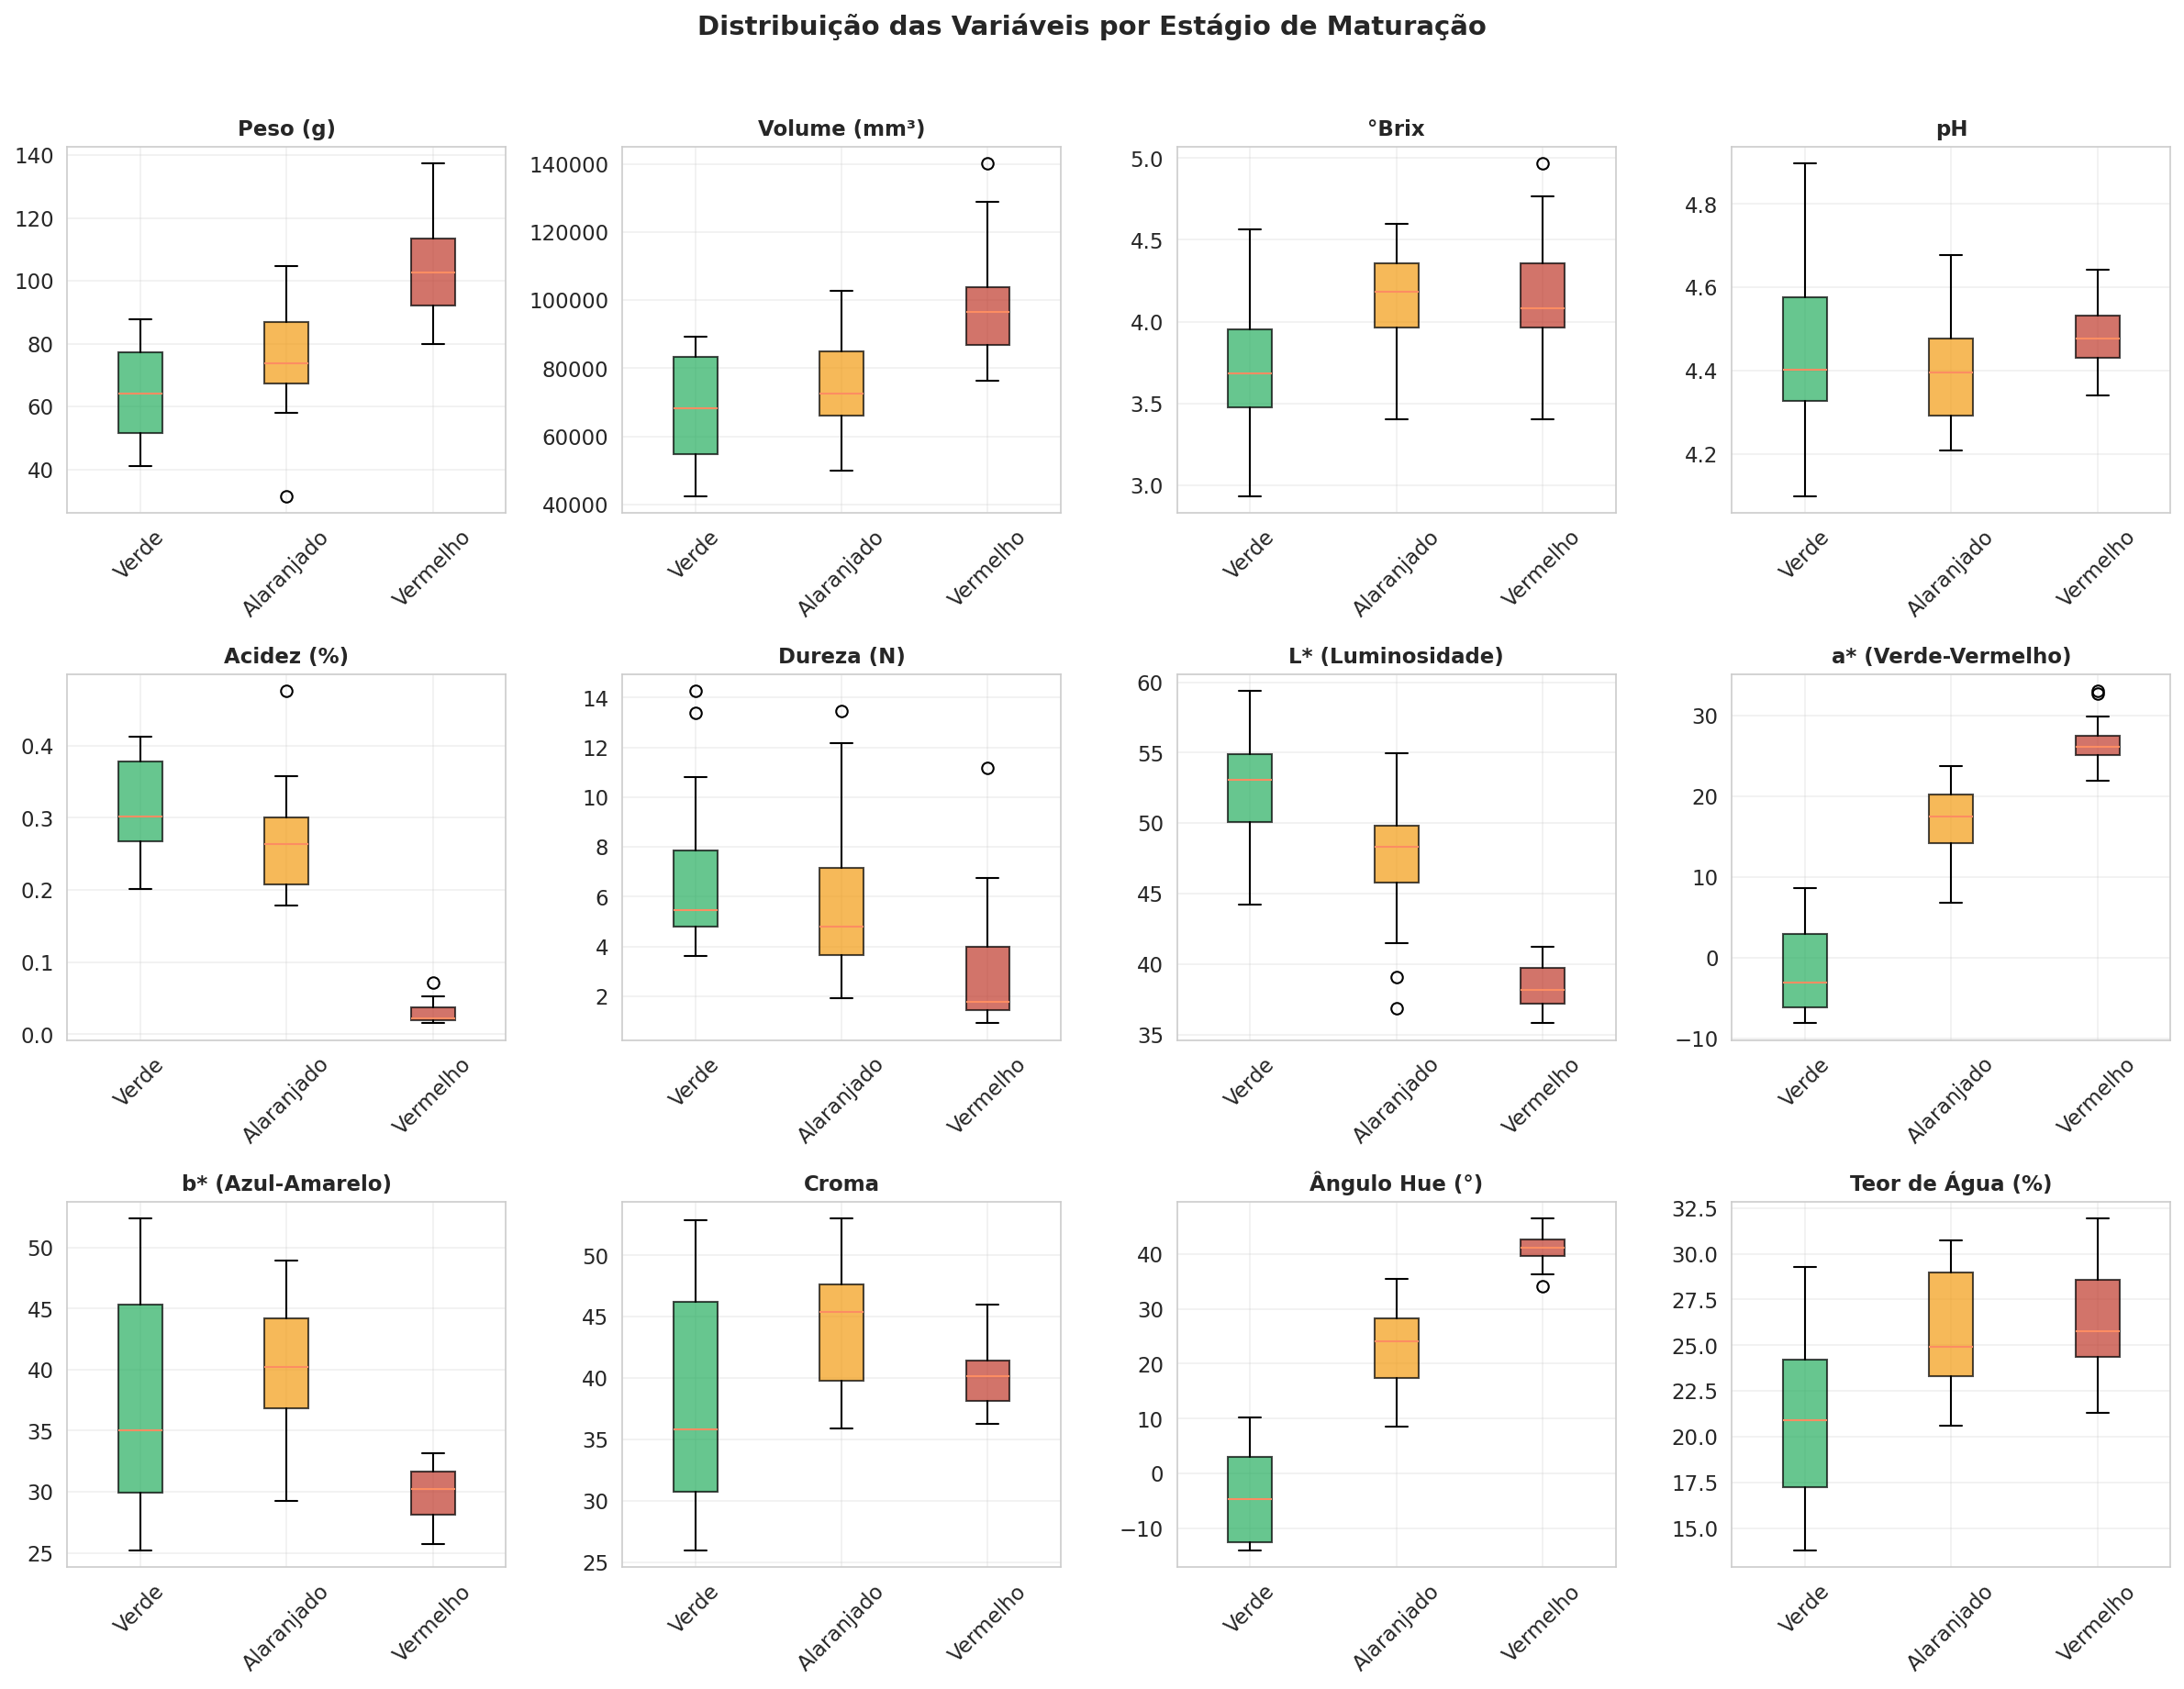

✓ Salvo: fig01_boxplots_variaveis.png/pdf

Gerando Figura 2: Matriz de Correlação...


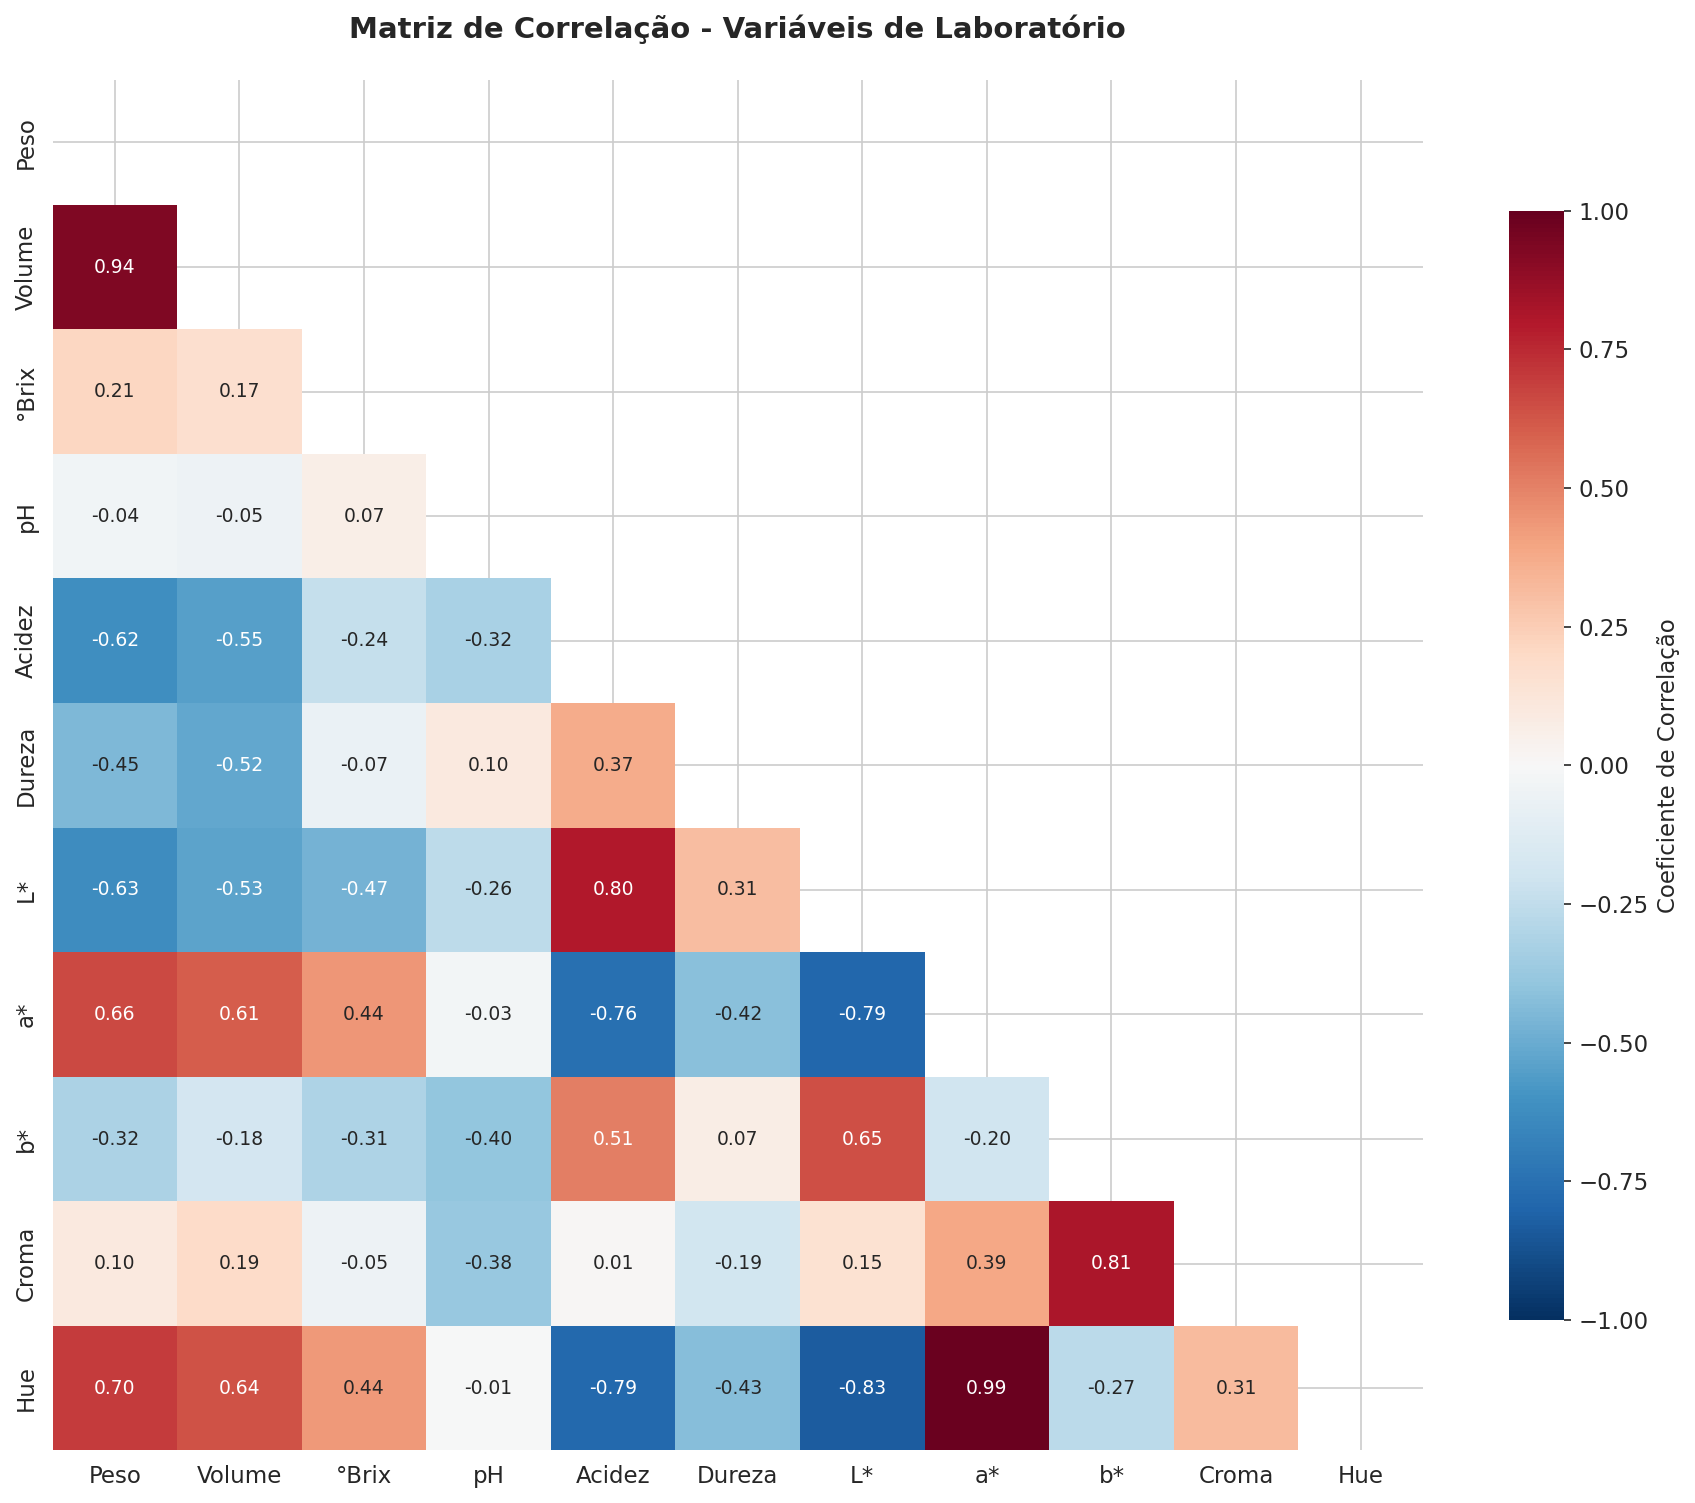

✓ Salvo: fig02_matriz_correlacao.png/pdf

Gerando Figura 3: Validação Metrológica...


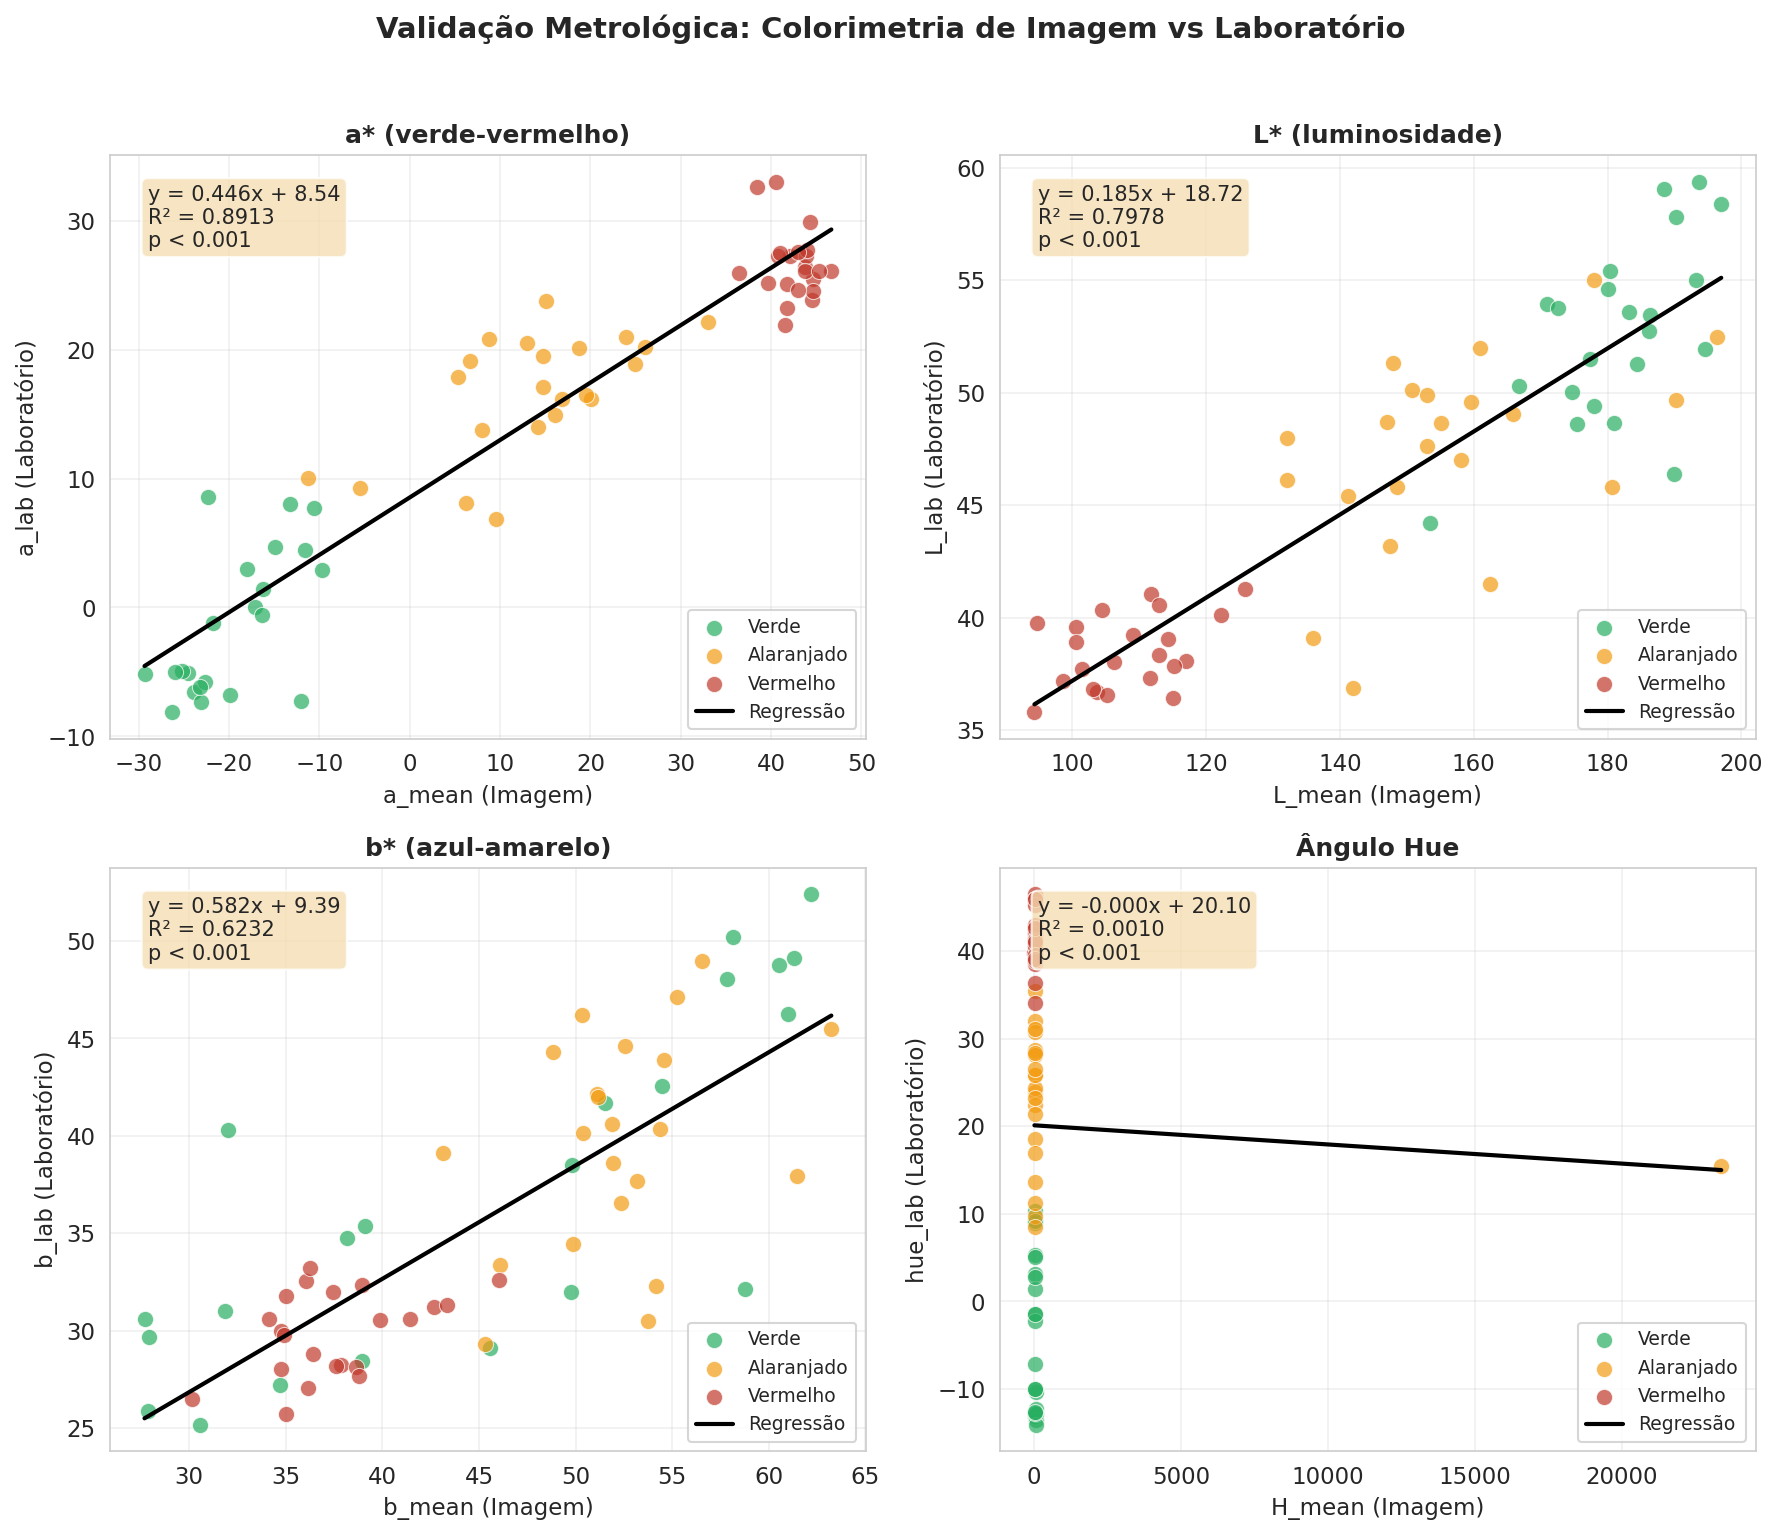

✓ Salvo: fig03_validacao_colorimetria.png/pdf

Gerando Figura 4: Análise de Brix...


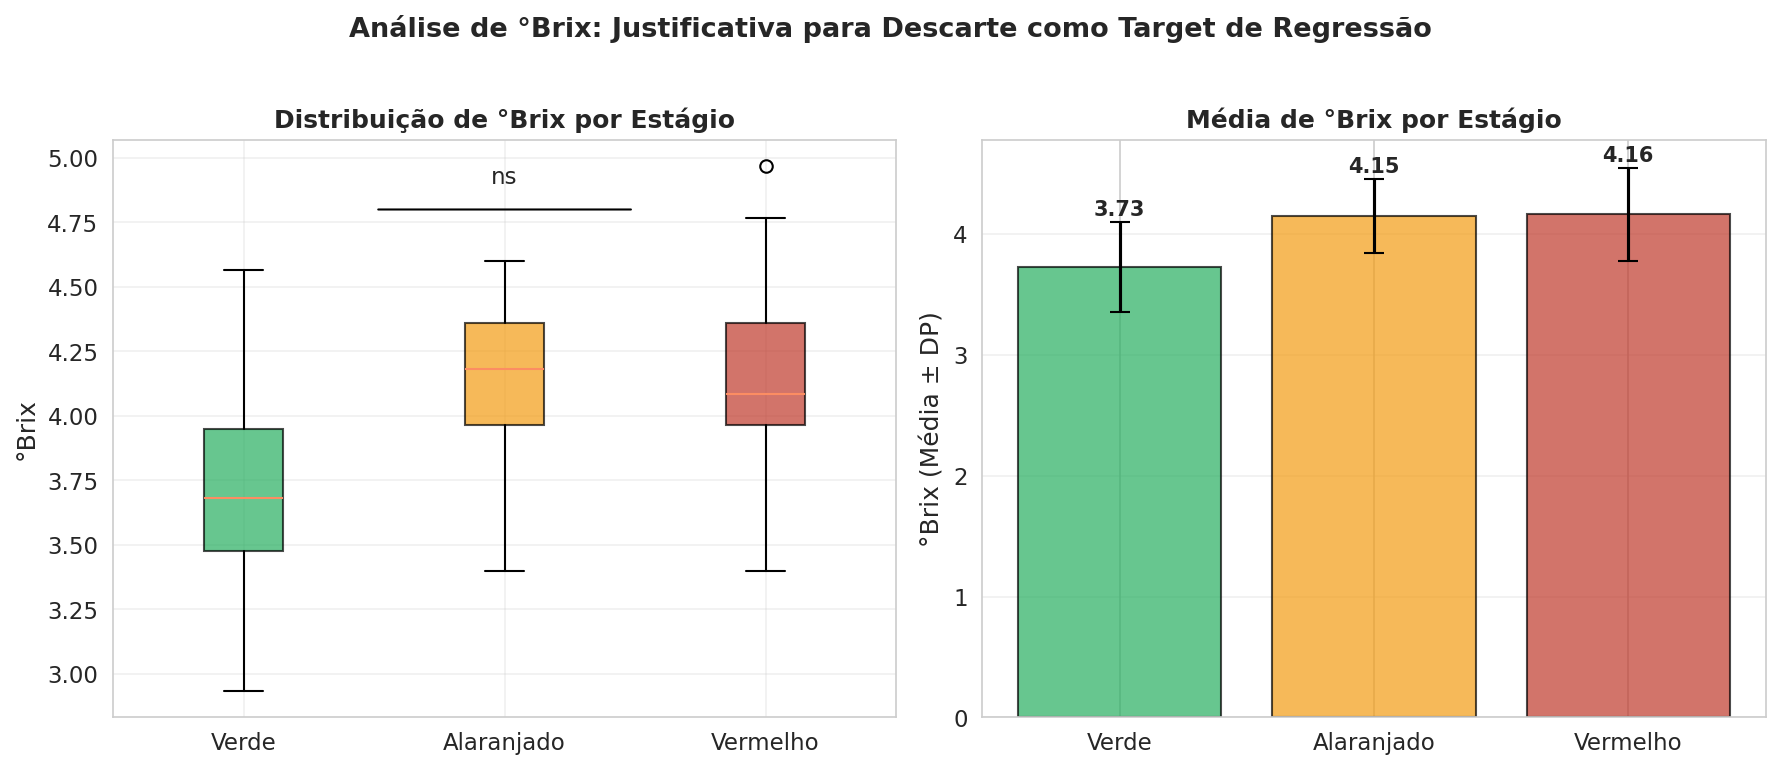

✓ Salvo: fig04_analise_brix.png/pdf

Gerando Figura 5: Evolução com Maturação...


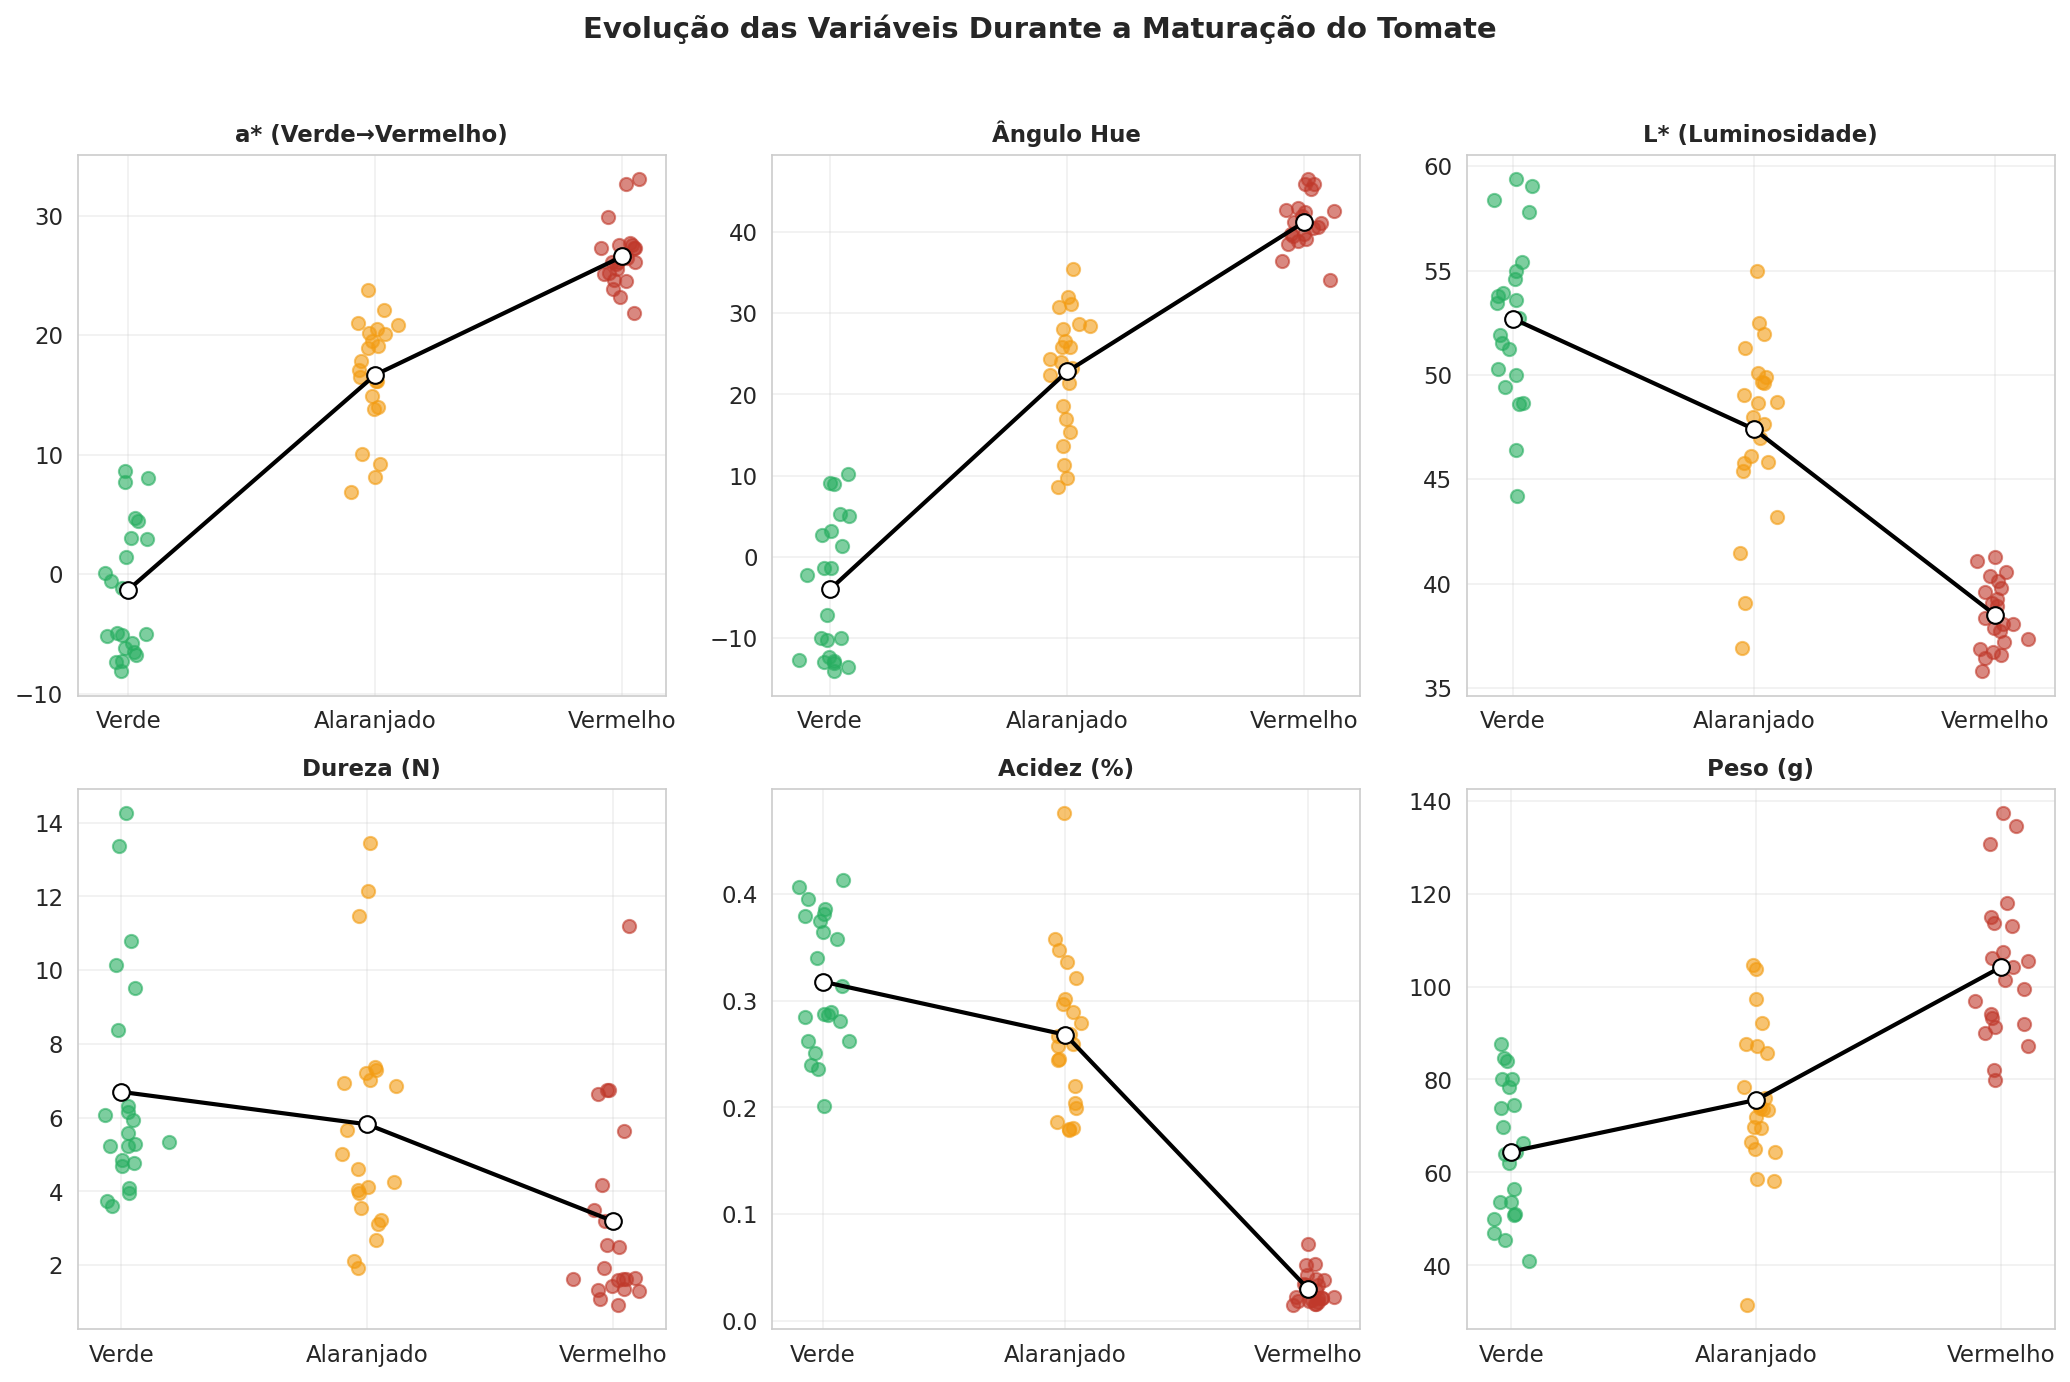

✓ Salvo: fig05_evolucao_maturacao.png/pdf

Gerando Figura 6: Correlação Features de Imagem...


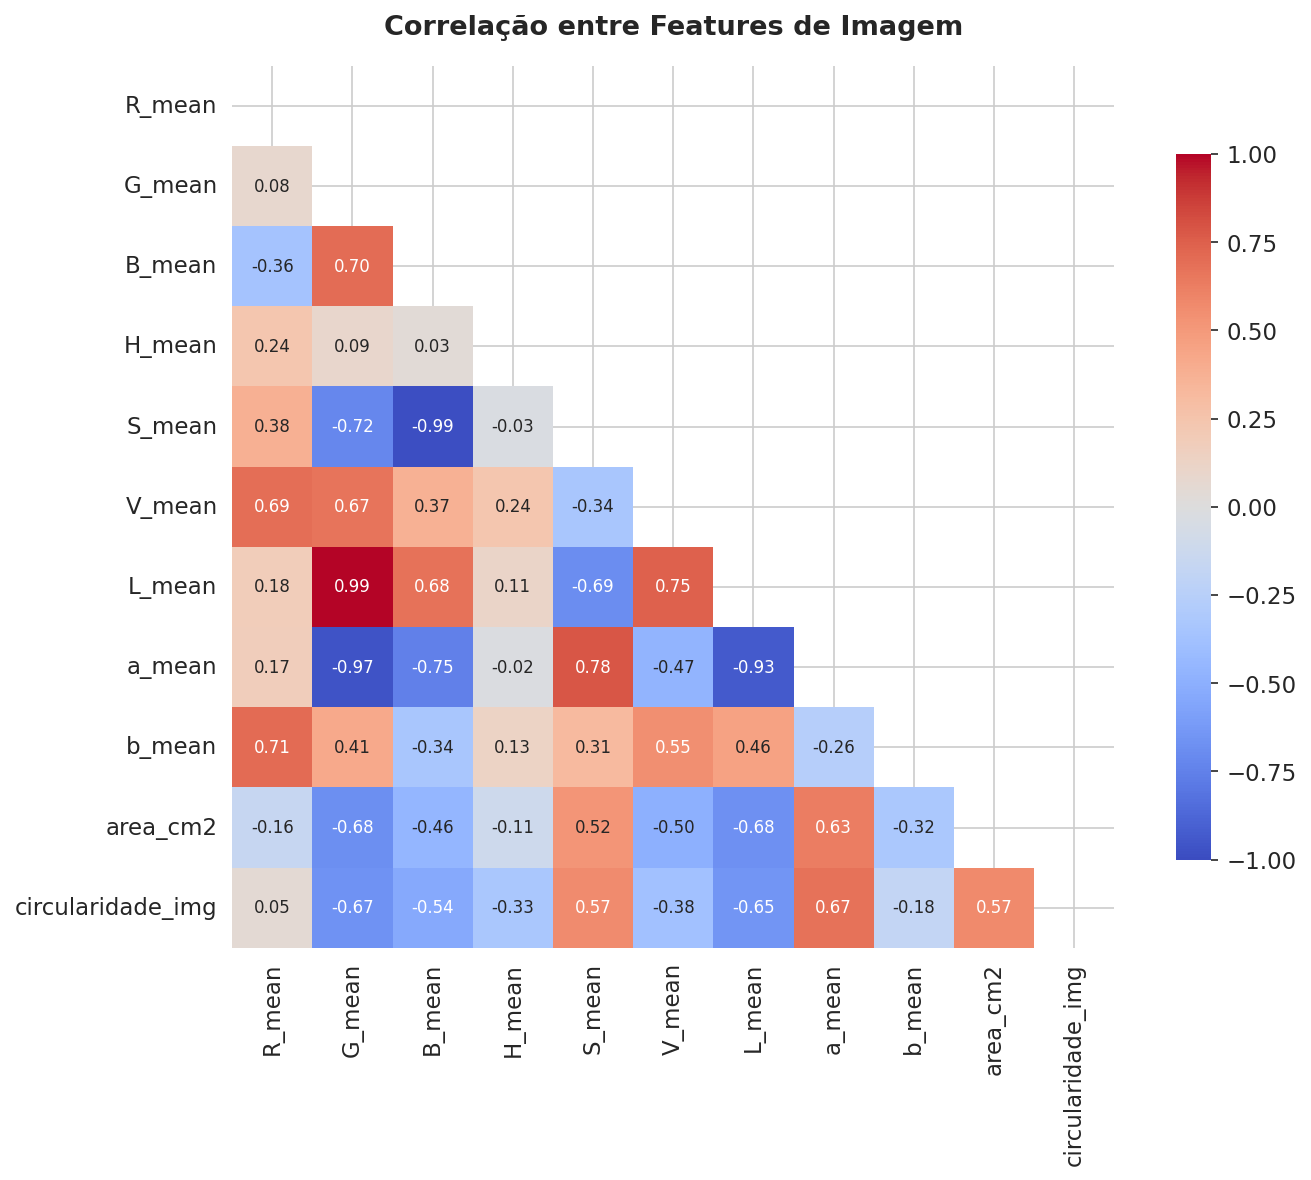

✓ Salvo: fig06_correlacao_features.png/pdf

RESUMO - PARTE 2 CONCLUÍDA

TABELAS GERADAS (resultados_dissertacao/tabelas/):
  ✓ estatisticas_descritivas_completa.csv
  ✓ estatisticas_descritivas_resumida.csv
  ✓ resultados_anova.csv
  ✓ resultados_tukey.csv
  ✓ tabela_dissertacao_anova_tukey.csv
  ✓ validacao_colorimetria.csv
  ✓ matriz_correlacao.csv

FIGURAS GERADAS (resultados_dissertacao/figuras/):
  ✓ fig01_boxplots_variaveis.png/pdf
  ✓ fig02_matriz_correlacao.png/pdf
  ✓ fig03_validacao_colorimetria.png/pdf
  ✓ fig04_analise_brix.png/pdf
  ✓ fig05_evolucao_maturacao.png/pdf
  ✓ fig06_correlacao_features.png/pdf

PRINCIPAIS RESULTADOS:

ANOVA - Variáveis Significativas (p < 0.05):

  peso, volume, brix, acidez_pct, dureza, L_lab, a_lab, b_lab, croma_lab, hue_lab, teor_agua_bu

VALIDAÇÃO METROLÓGICA:
  a* (imagem vs lab): r = 0.9441
  L* (imagem vs lab): r = 0.8932
  b* (imagem vs lab): r = 0.7894

ANÁLISE DE BRIX:
  Alaranjado vs Vermelho: p = 0.8909 (NÃO significativo)
  → Justif

In [ ]:
# =============================================================================
# PARTE 3: ANÁLISES ESTATÍSTICAS, GRÁFICOS E TABELAS
# Sistema para Estimar Parâmetros de Qualidade em Tomates
# Dissertação de Mestrado - PPGTA
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
from scipy.stats import f_oneway, pearsonr
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Configurações de visualização
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'DejaVu Sans'
sns.set_style("whitegrid")

OUTPUT_DIR = 'resultados_dissertacao'

print("="*80)
print("SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES")
print("PARTE 3: ANÁLISES ESTATÍSTICAS, GRÁFICOS E TABELAS")
print("="*80)

# =============================================================================
# 1. CARREGAR DADOS DA PARTE 3
# =============================================================================

df_lab = pd.read_csv(f'{OUTPUT_DIR}/dados/dataset_laboratorio.csv')
df_ml = pd.read_csv(f'{OUTPUT_DIR}/dados/dataset_ml_final.csv')

with open(f'{OUTPUT_DIR}/dados/features_config.json', 'r') as f:
    features_config = json.load(f)

ALL_FEATURES = features_config['ALL_FEATURES']

print(f"✓ Dataset laboratório: {df_lab.shape}")
print(f"✓ Dataset ML: {df_ml.shape}")

ordem_tratamento = ['verde', 'alaranjado', 'vermelho']
cores = {'verde': '#27ae60', 'alaranjado': '#f39c12', 'vermelho': '#c0392b'}

# =============================================================================
# 2. ESTATÍSTICA DESCRITIVA
# =============================================================================

print("\n" + "="*80)
print("2. ESTATÍSTICA DESCRITIVA")
print("="*80)

vars_descritivas = ['peso', 'volume', 'brix', 'ph', 'acidez_pct', 'dureza',
                    'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab', 'teor_agua_bu']

# Tabela completa
tabela_desc = []
for var in vars_descritivas:
    if var not in df_lab.columns:
        continue
    for trat in ordem_tratamento:
        dados = df_lab[df_lab['tratamento'] == trat][var].dropna()
        tabela_desc.append({
            'Variável': var,
            'Tratamento': trat,
            'n': len(dados),
            'Média': round(dados.mean(), 3),
            'DP': round(dados.std(), 3),
            'Mín': round(dados.min(), 3),
            'Máx': round(dados.max(), 3),
            'CV(%)': round((dados.std()/dados.mean())*100, 2) if dados.mean() != 0 else 0
        })

df_desc_completa = pd.DataFrame(tabela_desc)
df_desc_completa.to_csv(f'{OUTPUT_DIR}/tabelas/estatisticas_descritivas_completa.csv', index=False)

# Tabela resumida (formato dissertação)
tabela_resumida = []
for var in vars_descritivas:
    if var not in df_lab.columns:
        continue
    row = {'Variável': var}
    for trat in ordem_tratamento:
        dados = df_lab[df_lab['tratamento'] == trat][var].dropna()
        row[trat] = f"{dados.mean():.2f} ± {dados.std():.2f}"
    tabela_resumida.append(row)

df_desc_resumida = pd.DataFrame(tabela_resumida)
print("\n--- Estatísticas Descritivas (Média ± DP) ---\n")
print(df_desc_resumida.to_string(index=False))
df_desc_resumida.to_csv(f'{OUTPUT_DIR}/tabelas/estatisticas_descritivas_resumida.csv', index=False)

print(f"\n✓ Tabelas salvas em {OUTPUT_DIR}/tabelas/")

# =============================================================================
# 3. ANÁLISE DE VARIÂNCIA (ANOVA)
# =============================================================================

print("\n" + "="*80)
print("3. ANÁLISE DE VARIÂNCIA (ANOVA ONE-WAY)")
print("="*80)

vars_anova = ['peso', 'volume', 'brix', 'ph', 'acidez_pct', 'dureza',
              'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab', 'teor_agua_bu']

resultados_anova = []

for var in vars_anova:
    if var not in df_lab.columns:
        continue

    verde = df_lab[df_lab['tratamento'] == 'verde'][var].dropna()
    alaranjado = df_lab[df_lab['tratamento'] == 'alaranjado'][var].dropna()
    vermelho = df_lab[df_lab['tratamento'] == 'vermelho'][var].dropna()

    f_stat, p_value = f_oneway(verde, alaranjado, vermelho)

    sig = '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'

    resultados_anova.append({
        'Variável': var,
        'F': round(f_stat, 3),
        'p-value': p_value,
        'p_formatado': f'{p_value:.2e}' if p_value < 0.001 else f'{p_value:.4f}',
        'Significância': sig
    })

df_anova = pd.DataFrame(resultados_anova)
print("\n--- Resultados ANOVA One-Way ---\n")
print(df_anova[['Variável', 'F', 'p_formatado', 'Significância']].to_string(index=False))
print("\nLegenda: *** p<0.001, ** p<0.01, * p<0.05, ns = não significativo")

df_anova.to_csv(f'{OUTPUT_DIR}/tabelas/resultados_anova.csv', index=False)

# =============================================================================
# 4. TESTE DE TUKEY
# =============================================================================

print("\n" + "="*80)
print("4. TESTE DE TUKEY - COMPARAÇÕES MÚLTIPLAS")
print("="*80)

vars_tukey = ['brix', 'a_lab', 'hue_lab', 'dureza', 'peso', 'volume', 'L_lab', 'acidez_pct']
resultados_tukey = []

for var in vars_tukey:
    if var not in df_lab.columns:
        continue

    dados = df_lab[[var, 'tratamento']].dropna()
    tukey = pairwise_tukeyhsd(dados[var], dados['tratamento'], alpha=0.05)

    print(f"\n{'='*50}")
    print(f"Variável: {var.upper()}")
    print('='*50)
    print(tukey.summary())

    # Extrair resultados usando atributos corretos
    for i in range(len(tukey.meandiffs)):
        # Determinar os grupos comparados
        grupos = tukey.groupsunique
        n_grupos = len(grupos)

        # Calcular índices dos grupos
        idx = 0
        for g1_idx in range(n_grupos):
            for g2_idx in range(g1_idx + 1, n_grupos):
                if idx == i:
                    g1, g2 = grupos[g1_idx], grupos[g2_idx]
                    break
                idx += 1
            else:
                continue
            break

        resultados_tukey.append({
            'Variável': var,
            'Grupo1': g1,
            'Grupo2': g2,
            'Diferença': round(tukey.meandiffs[i], 4),
            'p-adj': round(tukey.pvalues[i], 4),
            'IC_inferior': round(tukey.confint[i, 0], 4),
            'IC_superior': round(tukey.confint[i, 1], 4),
            'Significativo': 'Sim' if tukey.reject[i] else 'Não'
        })

df_tukey = pd.DataFrame(resultados_tukey)
df_tukey.to_csv(f'{OUTPUT_DIR}/tabelas/resultados_tukey.csv', index=False)
print(f"\n✓ Resultados Tukey salvos: {OUTPUT_DIR}/tabelas/resultados_tukey.csv")

# =============================================================================
# 5. TABELA RESUMO ANOVA + TUKEY (FORMATO DISSERTAÇÃO)
# =============================================================================

print("\n" + "="*80)
print("5. TABELA RESUMO PARA DISSERTAÇÃO")
print("="*80)

# Função para obter letras do Tukey
# Função para obter letras do Tukey (CORRIGIDA)
def get_tukey_letters(var, df_tukey_results):
    """Gera letras de agrupamento baseado no Tukey."""
    subset = df_tukey_results[df_tukey_results['Variável'] == var]

    if len(subset) == 0:
        return {'verde': '', 'alaranjado': '', 'vermelho': ''}

    # Verificar cada comparação
    def check_sig(g1, g2):
        row = subset[((subset['Grupo1'] == g1) & (subset['Grupo2'] == g2)) |
                     ((subset['Grupo1'] == g2) & (subset['Grupo2'] == g1))]
        if len(row) > 0:
            return row['Significativo'].values[0] == 'Sim'
        return False

    diff_va = check_sig('verde', 'alaranjado')  # verde vs alaranjado
    diff_vv = check_sig('verde', 'vermelho')    # verde vs vermelho
    diff_av = check_sig('alaranjado', 'vermelho')  # alaranjado vs vermelho

    # Lógica de atribuição de letras
    if diff_va and diff_vv and diff_av:
        # Todos diferentes
        letters = {'verde': 'a', 'alaranjado': 'b', 'vermelho': 'c'}
    elif not diff_va and not diff_vv and not diff_av:
        # Nenhum diferente
        letters = {'verde': 'a', 'alaranjado': 'a', 'vermelho': 'a'}
    elif diff_vv and diff_av and not diff_va:
        # verde = alaranjado, ambos ≠ vermelho
        letters = {'verde': 'a', 'alaranjado': 'a', 'vermelho': 'b'}
    elif diff_va and diff_vv and not diff_av:
        # verde ≠ alaranjado, verde ≠ vermelho, alaranjado = vermelho
        letters = {'verde': 'a', 'alaranjado': 'b', 'vermelho': 'b'}
    elif diff_va and not diff_vv and diff_av:
        # verde ≠ alaranjado, verde = vermelho, alaranjado ≠ vermelho
        letters = {'verde': 'a', 'alaranjado': 'b', 'vermelho': 'a'}
    elif not diff_va and diff_vv and not diff_av:
        # verde = alaranjado, verde ≠ vermelho, alaranjado = vermelho
        letters = {'verde': 'a', 'alaranjado': 'ab', 'vermelho': 'b'}
    elif diff_va and not diff_vv and not diff_av:
        # verde ≠ alaranjado, verde = vermelho, alaranjado = vermelho
        letters = {'verde': 'a', 'alaranjado': 'b', 'vermelho': 'ab'}
    elif not diff_va and not diff_vv and diff_av:
        # verde = alaranjado, verde = vermelho, alaranjado ≠ vermelho
        letters = {'verde': 'ab', 'alaranjado': 'a', 'vermelho': 'b'}
    else:
        letters = {'verde': 'a', 'alaranjado': 'a', 'vermelho': 'a'}

    return letters

tabela_dissertacao = []
for var in vars_tukey:
    if var not in df_lab.columns:
        continue

    row = {'Variável': var}
    letters = get_tukey_letters(var, df_tukey)

    for trat in ordem_tratamento:
        dados = df_lab[df_lab['tratamento'] == trat][var].dropna()
        letra = letters.get(trat, '')
        row[trat] = f"{dados.mean():.2f} ± {dados.std():.2f} {letra}"

    # ANOVA p-value
    verde = df_lab[df_lab['tratamento'] == 'verde'][var].dropna()
    alaranjado = df_lab[df_lab['tratamento'] == 'alaranjado'][var].dropna()
    vermelho = df_lab[df_lab['tratamento'] == 'vermelho'][var].dropna()
    _, p_val = f_oneway(verde, alaranjado, vermelho)

    row['p-value'] = f'{p_val:.4f}' if p_val >= 0.0001 else '<0.0001'
    tabela_dissertacao.append(row)

df_dissertacao = pd.DataFrame(tabela_dissertacao)
print("\n--- Tabela para Dissertação (Média ± DP com letras Tukey) ---\n")
print(df_dissertacao.to_string(index=False))
df_dissertacao.to_csv(f'{OUTPUT_DIR}/tabelas/tabela_dissertacao_anova_tukey.csv', index=False)

# =============================================================================
# 6. ANÁLISE CRÍTICA: BRIX
# =============================================================================

print("\n" + "="*80)
print("6. ANÁLISE CRÍTICA: VIABILIDADE DE PREDIÇÃO DE BRIX")
print("="*80)

brix_verde = df_lab[df_lab['tratamento'] == 'verde']['brix'].dropna()
brix_alaranjado = df_lab[df_lab['tratamento'] == 'alaranjado']['brix'].dropna()
brix_vermelho = df_lab[df_lab['tratamento'] == 'vermelho']['brix'].dropna()

t_stat, p_val_brix = stats.ttest_ind(brix_alaranjado, brix_vermelho)

print(f"\nTeste t (Brix: alaranjado vs vermelho):")
print(f"  t = {t_stat:.3f}")
print(f"  p = {p_val_brix:.4f}")
print(f"  Conclusão: {'NÃO significativo (p > 0.05)' if p_val_brix > 0.05 else 'Significativo'}")

print(f"\nMédias de °Brix:")
print(f"  Verde:      {brix_verde.mean():.2f} ± {brix_verde.std():.2f}")
print(f"  Alaranjado: {brix_alaranjado.mean():.2f} ± {brix_alaranjado.std():.2f}")
print(f"  Vermelho:   {brix_vermelho.mean():.2f} ± {brix_vermelho.std():.2f}")

# =============================================================================
# 7. VALIDAÇÃO METROLÓGICA: CORRELAÇÕES
# =============================================================================

print("\n" + "="*80)
print("7. VALIDAÇÃO METROLÓGICA: IMAGEM vs LABORATÓRIO")
print("="*80)

correlacoes = [
    ('a_mean', 'a_lab', 'a* (verde-vermelho)'),
    ('L_mean', 'L_lab', 'L* (luminosidade)'),
    ('b_mean', 'b_lab', 'b* (azul-amarelo)'),
    ('H_mean', 'hue_lab', 'Ângulo Hue'),
]

resultados_corr = []

print("\n--- Correlações de Pearson ---\n")
for feat_img, feat_lab, nome in correlacoes:
    dados = df_ml[[feat_img, feat_lab]].dropna()
    r, p = pearsonr(dados[feat_img], dados[feat_lab])

    # Regressão linear
    slope, intercept, r_val, p_val, std_err = stats.linregress(dados[feat_img], dados[feat_lab])

    resultados_corr.append({
        'Parâmetro': nome,
        'Imagem': feat_img,
        'Laboratório': feat_lab,
        'r': round(r, 4),
        'R²': round(r**2, 4),
        'p-value': p,
        'p_fmt': f'{p:.2e}' if p < 0.001 else f'{p:.4f}',
        'Equação': f'y = {slope:.4f}x + {intercept:.4f}',
        'Slope': slope,
        'Intercept': intercept
    })

    print(f"{nome:20s}: r = {r:.4f}, R² = {r**2:.4f}, p = {p:.2e}")

df_corr = pd.DataFrame(resultados_corr)
df_corr.to_csv(f'{OUTPUT_DIR}/tabelas/validacao_colorimetria.csv', index=False)

# =============================================================================
# 8. MATRIZ DE CORRELAÇÃO - VARIÁVEIS DE LABORATÓRIO
# =============================================================================

print("\n" + "="*80)
print("8. MATRIZ DE CORRELAÇÃO")
print("="*80)

vars_corr_matrix = ['peso', 'volume', 'brix', 'ph', 'acidez_pct', 'dureza',
                    'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab']

corr_matrix = df_lab[vars_corr_matrix].corr()
corr_matrix.to_csv(f'{OUTPUT_DIR}/tabelas/matriz_correlacao.csv')
print("✓ Matriz de correlação salva")

# =============================================================================
# 9. GERAÇÃO DE FIGURAS
# =============================================================================

print("\n" + "="*80)
print("9. GERAÇÃO DE FIGURAS")
print("="*80)

# -------------------------------------------------------------------------
# FIGURA 1: BOXPLOTS DAS VARIÁVEIS PRINCIPAIS
# -------------------------------------------------------------------------
print("\nGerando Figura 1: Boxplots...")

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()

vars_boxplot = ['peso', 'volume', 'brix', 'ph', 'acidez_pct', 'dureza',
                'L_lab', 'a_lab', 'b_lab', 'croma_lab', 'hue_lab', 'teor_agua_bu']

titulos_pt = {
    'peso': 'Peso (g)', 'volume': 'Volume (mm³)', 'brix': '°Brix',
    'ph': 'pH', 'acidez_pct': 'Acidez (%)', 'dureza': 'Dureza (N)',
    'L_lab': 'L* (Luminosidade)', 'a_lab': 'a* (Verde-Vermelho)',
    'b_lab': 'b* (Azul-Amarelo)', 'croma_lab': 'Croma',
    'hue_lab': 'Ângulo Hue (°)', 'teor_agua_bu': 'Teor de Água (%)'
}

for i, var in enumerate(vars_boxplot):
    if var in df_lab.columns:
        bp = axes[i].boxplot([df_lab[df_lab['tratamento'] == t][var].dropna() for t in ordem_tratamento],
                             labels=['Verde', 'Alaranjado', 'Vermelho'],
                             patch_artist=True)

        for patch, color in zip(bp['boxes'], [cores['verde'], cores['alaranjado'], cores['vermelho']]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        axes[i].set_title(titulos_pt.get(var, var), fontweight='bold', fontsize=11)
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].grid(True, alpha=0.3)

plt.suptitle('Distribuição das Variáveis por Estágio de Maturação', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig01_boxplots_variaveis.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig01_boxplots_variaveis.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig01_boxplots_variaveis.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 2: MATRIZ DE CORRELAÇÃO
# -------------------------------------------------------------------------
print("\nGerando Figura 2: Matriz de Correlação...")

fig, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Labels em português
labels_pt = ['Peso', 'Volume', '°Brix', 'pH', 'Acidez', 'Dureza',
             'L*', 'a*', 'b*', 'Croma', 'Hue']

hm = sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r',
                 center=0, vmin=-1, vmax=1, square=True, ax=ax,
                 cbar_kws={'shrink': 0.8, 'label': 'Coeficiente de Correlação'},
                 annot_kws={'size': 9},
                 xticklabels=labels_pt, yticklabels=labels_pt)

ax.set_title('Matriz de Correlação - Variáveis de Laboratório', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig02_matriz_correlacao.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig02_matriz_correlacao.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig02_matriz_correlacao.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 3: VALIDAÇÃO METROLÓGICA (COM EQUAÇÕES)
# -------------------------------------------------------------------------
print("\nGerando Figura 3: Validação Metrológica...")

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (feat_img, feat_lab, nome) in enumerate(correlacoes):
    ax = axes[idx]
    dados = df_ml[[feat_img, feat_lab, 'tratamento']].dropna()

    # Scatter por tratamento
    for trat in ordem_tratamento:
        subset = dados[dados['tratamento'] == trat]
        ax.scatter(subset[feat_img], subset[feat_lab],
                  c=cores[trat], label=trat.capitalize(),
                  alpha=0.7, s=60, edgecolors='white', linewidth=0.5)

    # Regressão linear
    x = dados[feat_img].values
    y = dados[feat_lab].values
    slope, intercept, r_val, p_val, std_err = stats.linregress(x, y)

    x_line = np.linspace(x.min(), x.max(), 100)
    y_line = slope * x_line + intercept
    ax.plot(x_line, y_line, 'k-', linewidth=2, label='Regressão')

    # Equação e R² na figura
    eq_text = f'y = {slope:.3f}x + {intercept:.2f}\nR² = {r_val**2:.4f}\np < 0.001'
    ax.text(0.05, 0.95, eq_text, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.set_xlabel(f'{feat_img} (Imagem)', fontsize=11)
    ax.set_ylabel(f'{feat_lab} (Laboratório)', fontsize=11)
    ax.set_title(nome, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Validação Metrológica: Colorimetria de Imagem vs Laboratório',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig03_validacao_colorimetria.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig03_validacao_colorimetria.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig03_validacao_colorimetria.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 4: COMPARAÇÃO BRIX POR TRATAMENTO
# -------------------------------------------------------------------------
print("\nGerando Figura 4: Análise de Brix...")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Boxplot de Brix
ax1 = axes[0]
bp = ax1.boxplot([brix_verde, brix_alaranjado, brix_vermelho],
                 labels=['Verde', 'Alaranjado', 'Vermelho'],
                 patch_artist=True)
for patch, color in zip(bp['boxes'], [cores['verde'], cores['alaranjado'], cores['vermelho']]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('°Brix', fontsize=12)
ax1.set_title('Distribuição de °Brix por Estágio', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Adicionar anotação de significância
ax1.annotate('', xy=(1.5, brix_alaranjado.max() + 0.2), xytext=(2.5, brix_alaranjado.max() + 0.2),
             arrowprops=dict(arrowstyle='-', color='black'))
ax1.text(2, brix_alaranjado.max() + 0.3, 'ns', ha='center', fontsize=11)

# Barplot com erro
ax2 = axes[1]
medias = [brix_verde.mean(), brix_alaranjado.mean(), brix_vermelho.mean()]
erros = [brix_verde.std(), brix_alaranjado.std(), brix_vermelho.std()]
bars = ax2.bar(['Verde', 'Alaranjado', 'Vermelho'], medias,
               yerr=erros, capsize=5, color=[cores['verde'], cores['alaranjado'], cores['vermelho']],
               alpha=0.7, edgecolor='black')

ax2.set_ylabel('°Brix (Média ± DP)', fontsize=12)
ax2.set_title('Média de °Brix por Estágio', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Valores nas barras
for bar, media, erro in zip(bars, medias, erros):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + erro + 0.05,
             f'{media:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.suptitle('Análise de °Brix: Justificativa para Descarte como Target de Regressão',
             fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig04_analise_brix.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig04_analise_brix.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig04_analise_brix.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 5: EVOLUÇÃO DAS VARIÁVEIS COM MATURAÇÃO
# -------------------------------------------------------------------------
print("\nGerando Figura 5: Evolução com Maturação...")

fig, axes = plt.subplots(2, 3, figsize=(14, 9))
axes = axes.flatten()

vars_evolucao = ['a_lab', 'hue_lab', 'L_lab', 'dureza', 'acidez_pct', 'peso']
titulos_evol = ['a* (Verde→Vermelho)', 'Ângulo Hue', 'L* (Luminosidade)',
                'Dureza (N)', 'Acidez (%)', 'Peso (g)']

for i, (var, titulo) in enumerate(zip(vars_evolucao, titulos_evol)):
    ax = axes[i]

    # Dados por tratamento
    dados_plot = []
    for j, trat in enumerate(ordem_tratamento):
        valores = df_lab[df_lab['tratamento'] == trat][var].dropna()
        dados_plot.append(valores)

        # Scatter com jitter
        x_jitter = np.random.normal(j+1, 0.05, len(valores))
        ax.scatter(x_jitter, valores, c=cores[trat], alpha=0.6, s=40)

    # Linha conectando médias
    medias = [d.mean() for d in dados_plot]
    ax.plot([1, 2, 3], medias, 'k-o', linewidth=2, markersize=8, markerfacecolor='white')

    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(['Verde', 'Alaranjado', 'Vermelho'])
    ax.set_title(titulo, fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Evolução das Variáveis Durante a Maturação do Tomate',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig05_evolucao_maturacao.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig05_evolucao_maturacao.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig05_evolucao_maturacao.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 6: CORRELAÇÃO FEATURES DE IMAGEM
# -------------------------------------------------------------------------
print("\nGerando Figura 6: Correlação Features de Imagem...")

# Selecionar features principais
features_principais = ['R_mean', 'G_mean', 'B_mean', 'H_mean', 'S_mean', 'V_mean',
                       'L_mean', 'a_mean', 'b_mean', 'area_cm2', 'circularidade_img']

corr_features = df_ml[features_principais].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_features, dtype=bool))

sns.heatmap(corr_features, mask=mask, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True, ax=ax,
            cbar_kws={'shrink': 0.8}, annot_kws={'size': 8})

ax.set_title('Correlação entre Features de Imagem', fontsize=13, fontweight='bold', pad=15)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig06_correlacao_features.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig06_correlacao_features.pdf', bbox_inches='tight')
plt.show()
print(f"✓ Salvo: fig06_correlacao_features.png/pdf")

# =============================================================================
# 10. RESUMO PARTE 2
# =============================================================================

print("\n" + "="*80)
print("RESUMO - PARTE 2 CONCLUÍDA")
print("="*80)

print(f"""
TABELAS GERADAS ({OUTPUT_DIR}/tabelas/):
  ✓ estatisticas_descritivas_completa.csv
  ✓ estatisticas_descritivas_resumida.csv
  ✓ resultados_anova.csv
  ✓ resultados_tukey.csv
  ✓ tabela_dissertacao_anova_tukey.csv
  ✓ validacao_colorimetria.csv
  ✓ matriz_correlacao.csv

FIGURAS GERADAS ({OUTPUT_DIR}/figuras/):
  ✓ fig01_boxplots_variaveis.png/pdf
  ✓ fig02_matriz_correlacao.png/pdf
  ✓ fig03_validacao_colorimetria.png/pdf
  ✓ fig04_analise_brix.png/pdf
  ✓ fig05_evolucao_maturacao.png/pdf
  ✓ fig06_correlacao_features.png/pdf

PRINCIPAIS RESULTADOS:

ANOVA - Variáveis Significativas (p < 0.05):
""")

# Listar variáveis significativas
vars_sig = df_anova[df_anova['Significância'] != 'ns']['Variável'].tolist()
print(f"  {', '.join(vars_sig)}")

print(f"""
VALIDAÇÃO METROLÓGICA:
  a* (imagem vs lab): r = {df_corr[df_corr['Parâmetro']=='a* (verde-vermelho)']['r'].values[0]:.4f}
  L* (imagem vs lab): r = {df_corr[df_corr['Parâmetro']=='L* (luminosidade)']['r'].values[0]:.4f}
  b* (imagem vs lab): r = {df_corr[df_corr['Parâmetro']=='b* (azul-amarelo)']['r'].values[0]:.4f}

ANÁLISE DE BRIX:
  Alaranjado vs Vermelho: p = {p_val_brix:.4f} (NÃO significativo)
  → Justifica descarte como target de regressão
""")

print("="*80)
print("✓ PARTE 2 FINALIZADA")
print("  Execute a PARTE 3 para Machine Learning e aplicação Streamlit")
print("="*80)

# PARTE 4 REVISADA: MACHINE LEARNING COM CORREÇÃO DE OVERFITTING

SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES
PARTE 4 REVISADA: MACHINE LEARNING COM CORREÇÃO DE OVERFITTING

1. CARREGAMENTO DOS DADOS
✓ Dataset ML carregado: (66, 45)
✓ Features totais: 22
  - Forma: 4
  - Cor: 14
  - Textura: 4

2. PREPARAÇÃO DOS DADOS PARA MODELAGEM

Classificação:
  X shape: (66, 22)
  Features: 22 (todas)

Regressão:
  X shape: (66, 4)
  Features: 4 (apenas forma)
  Justificativa: features de cor não têm correlação física com peso/volume

Distribuição: verde=22, alaranjado=22, vermelho=22

✓ Scalers e LabelEncoder salvos

3. CLASSIFICAÇÃO DE MATURAÇÃO

--- Classificação (Validação Cruzada k=10) ---

Random Forest:
  Accuracy  = 0.9714 ± 0.0571
  Precision = 0.9722
  Recall    = 0.9697
  F1-Score  = 0.9696

SVM (RBF):
  Accuracy  = 0.9690 ± 0.0621
  Precision = 0.9722
  Recall    = 0.9697
  F1-Score  = 0.9696

KNN (k=5):
  Accuracy  = 0.9548 ± 0.0694
  Precision = 0.9551
  Recall    = 0.9545
  F1-Score  = 0.9545

★ Melhor modelo: Random Forest (Accu

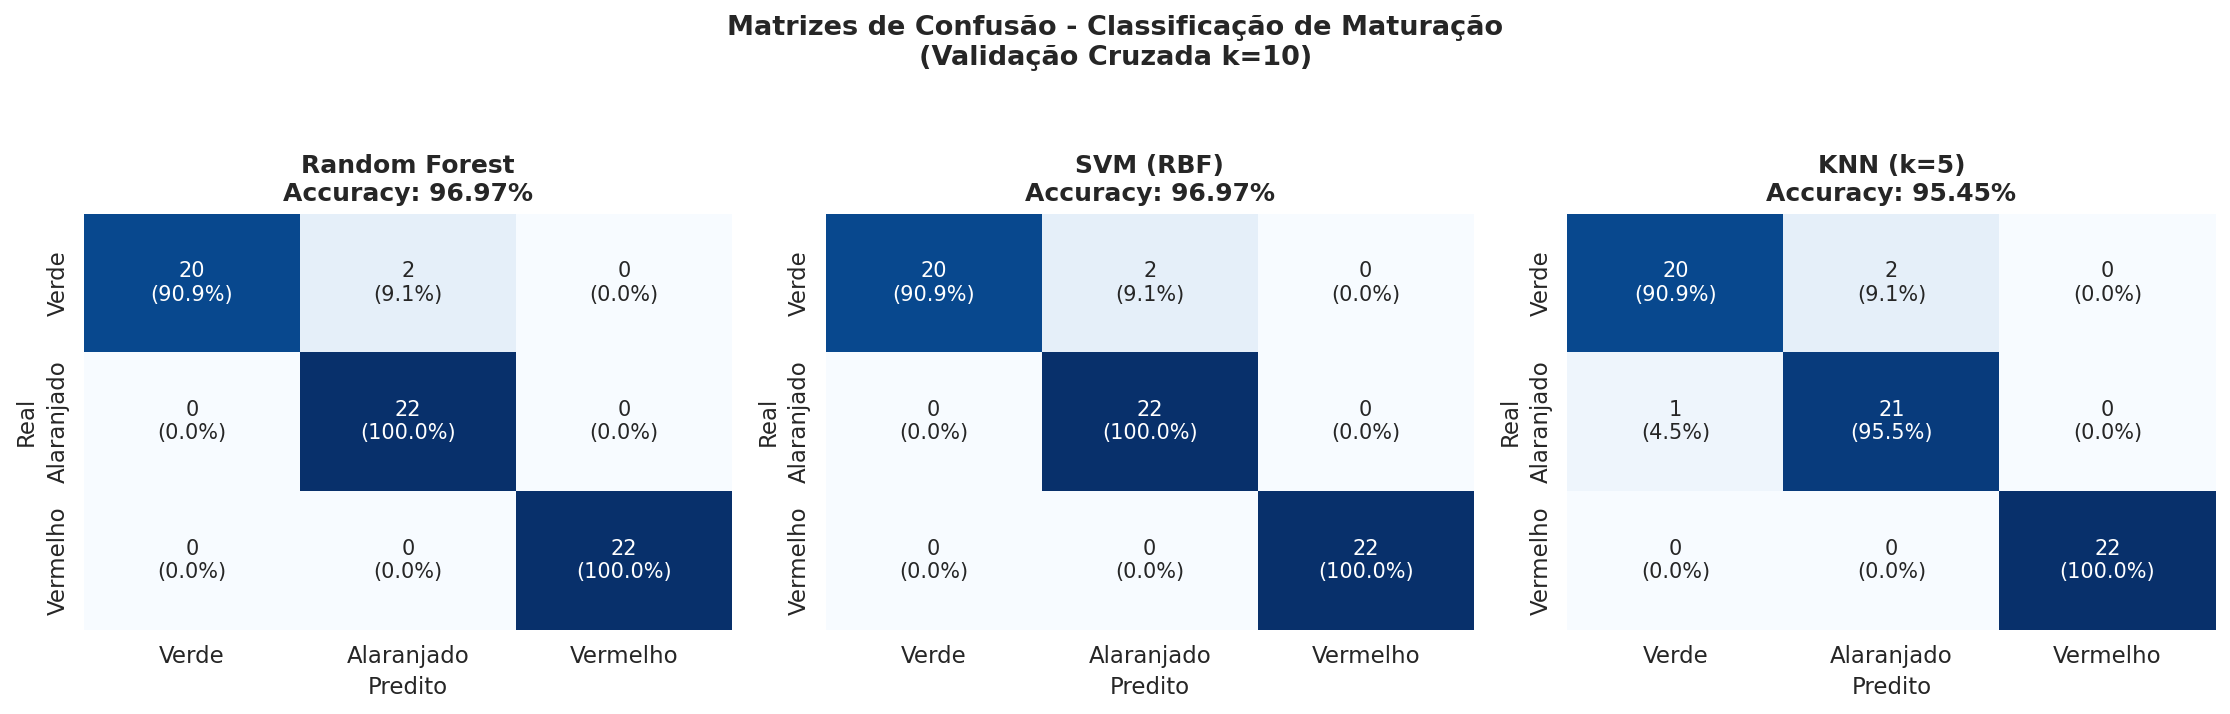

✓ Salvo: fig07_matrizes_confusao.png/pdf

Gerando Figura 8: Predito vs Real - Peso...


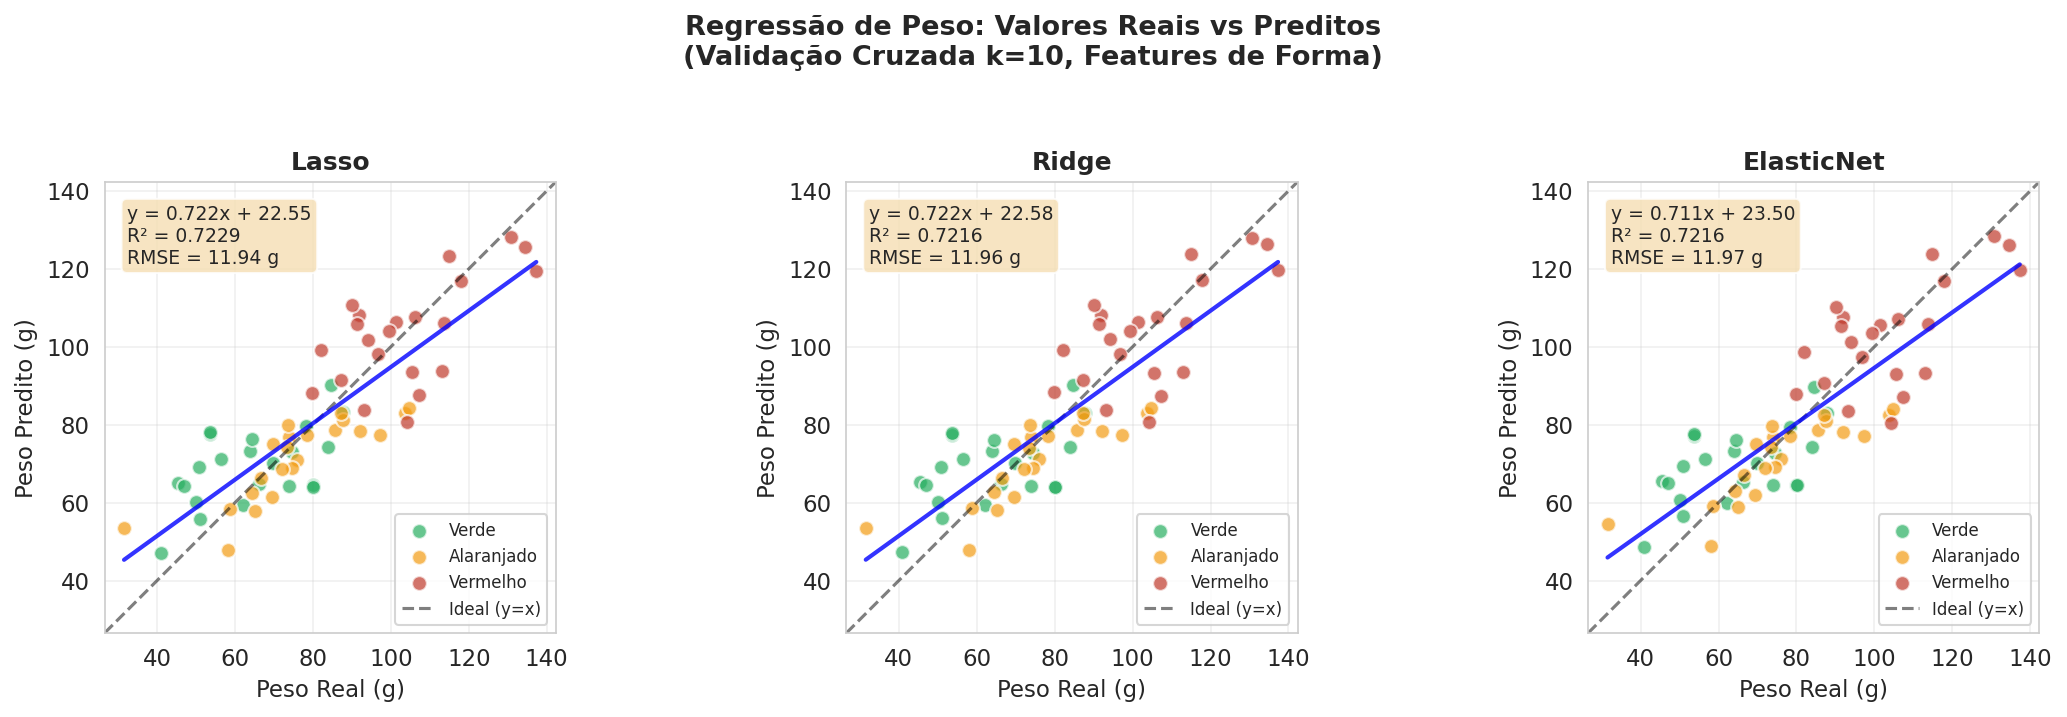

✓ Salvo: fig08_regressao_peso.png/pdf

Gerando Figura 9: Predito vs Real - Volume...


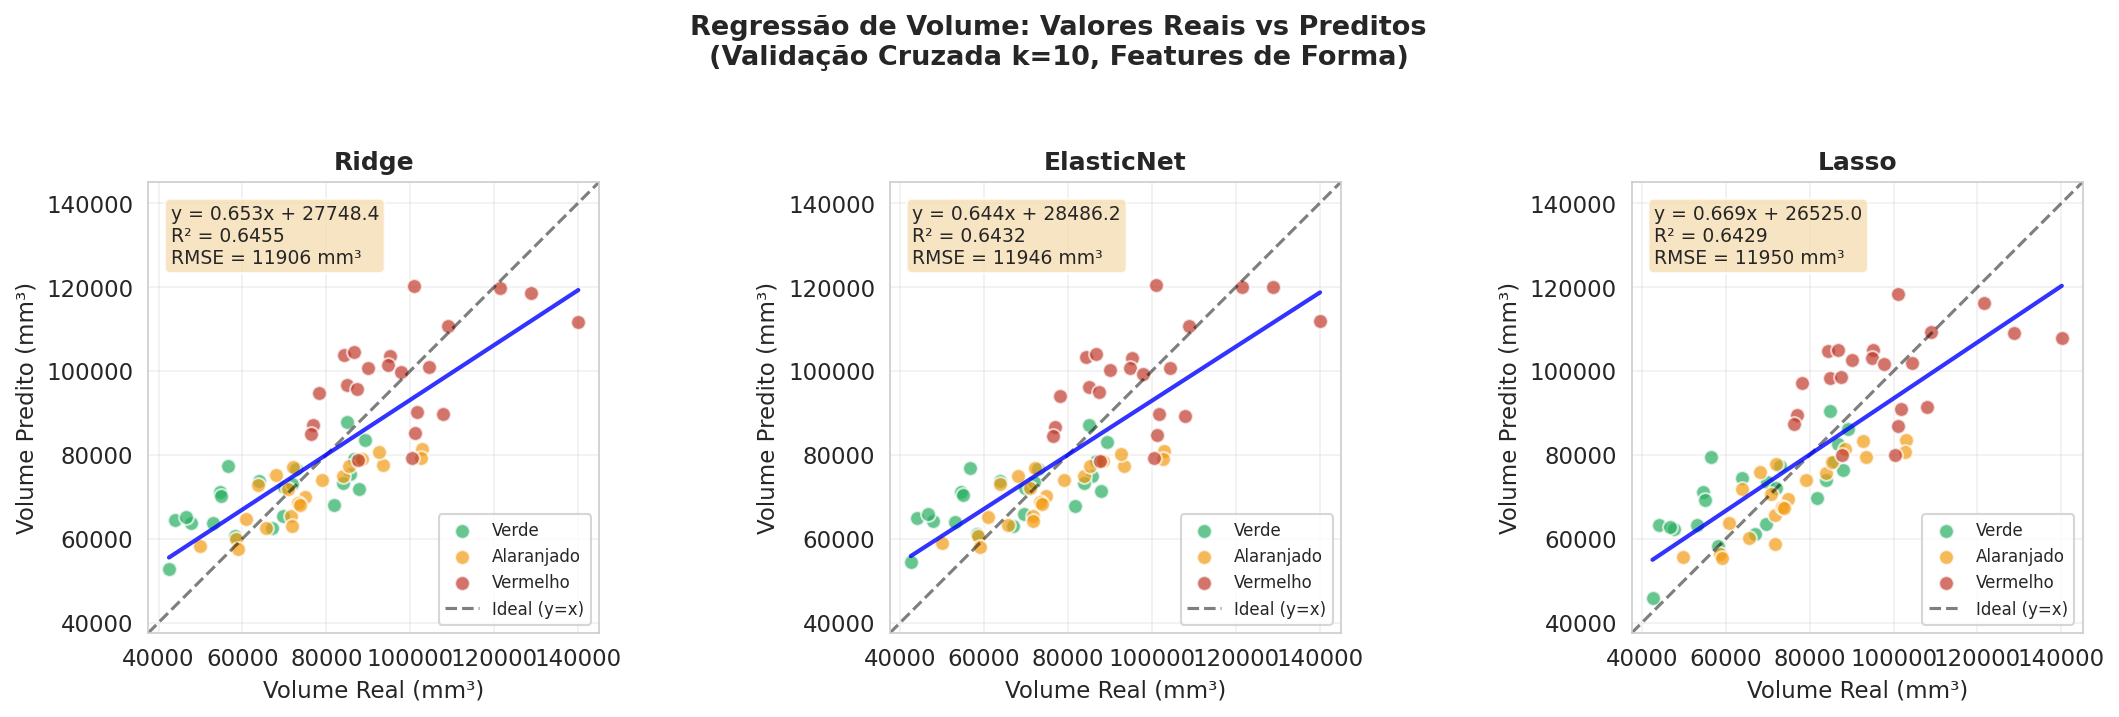

✓ Salvo: fig09_regressao_volume.png/pdf

Gerando Figura 10: Feature Importance...


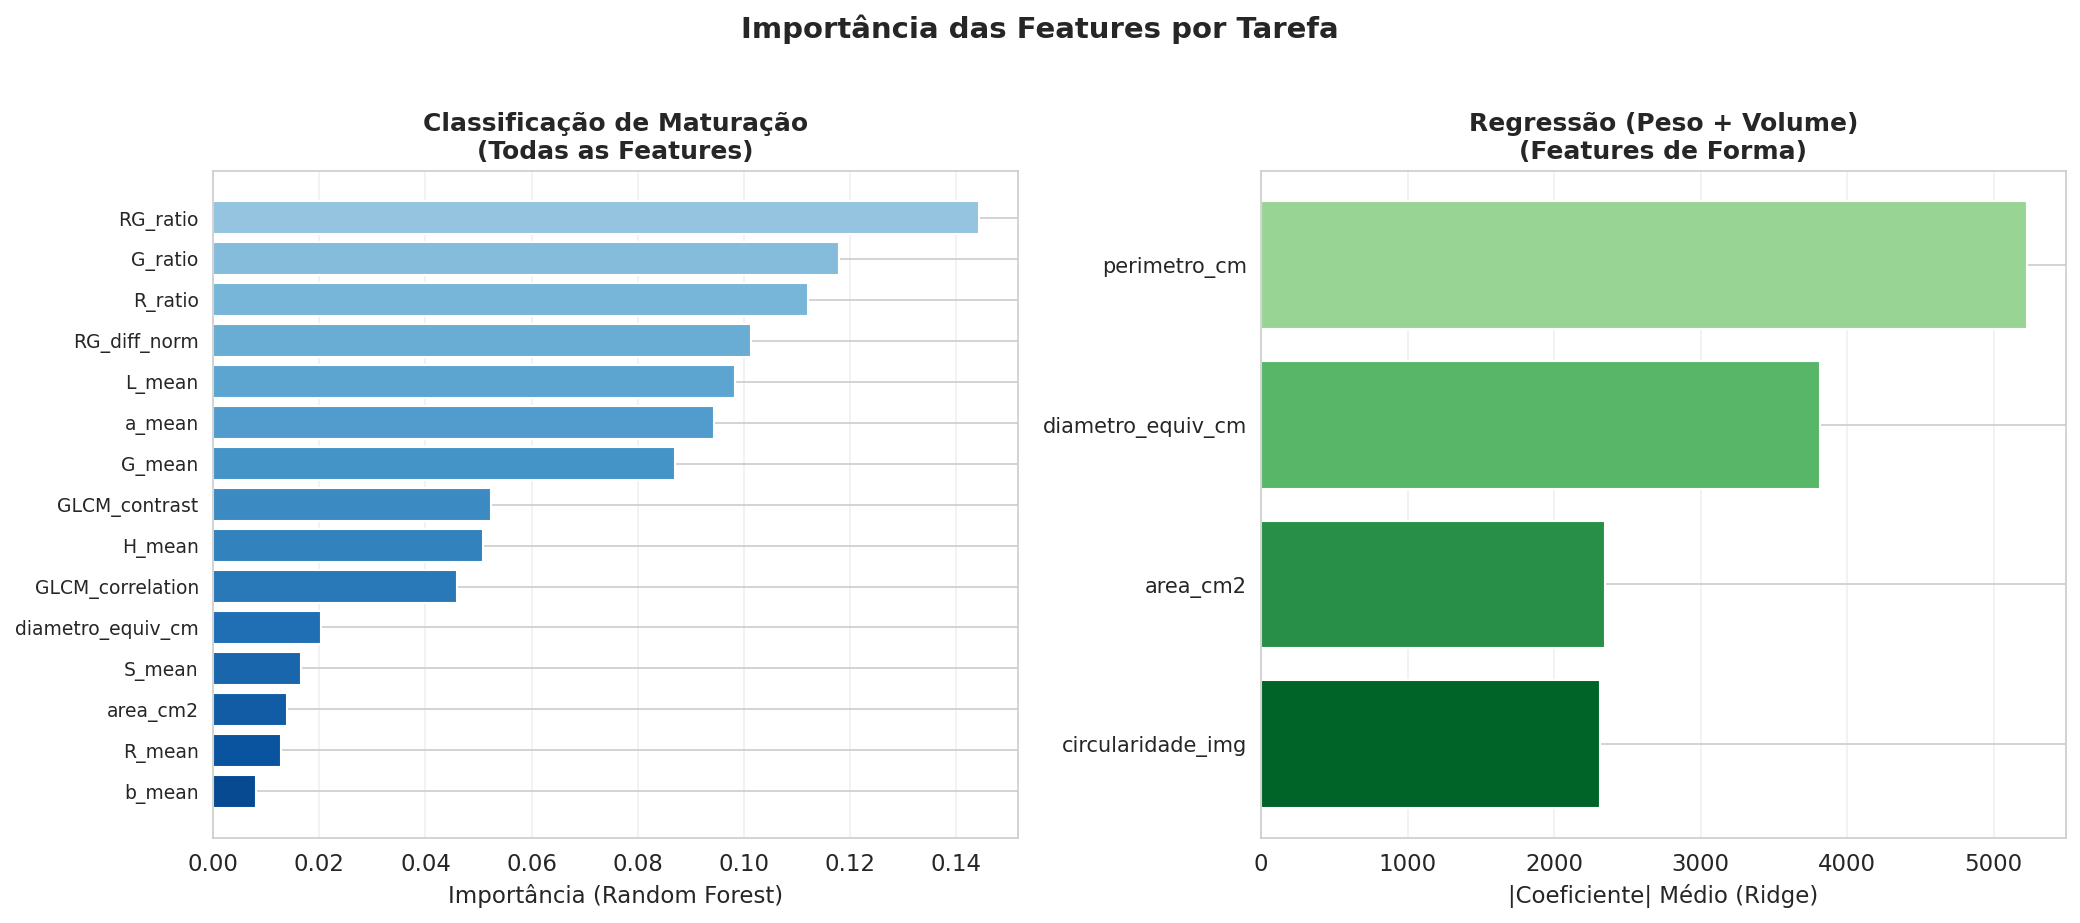

✓ Salvo: fig10_feature_importance.png/pdf

Gerando Figura 11: Comparação de Modelos...


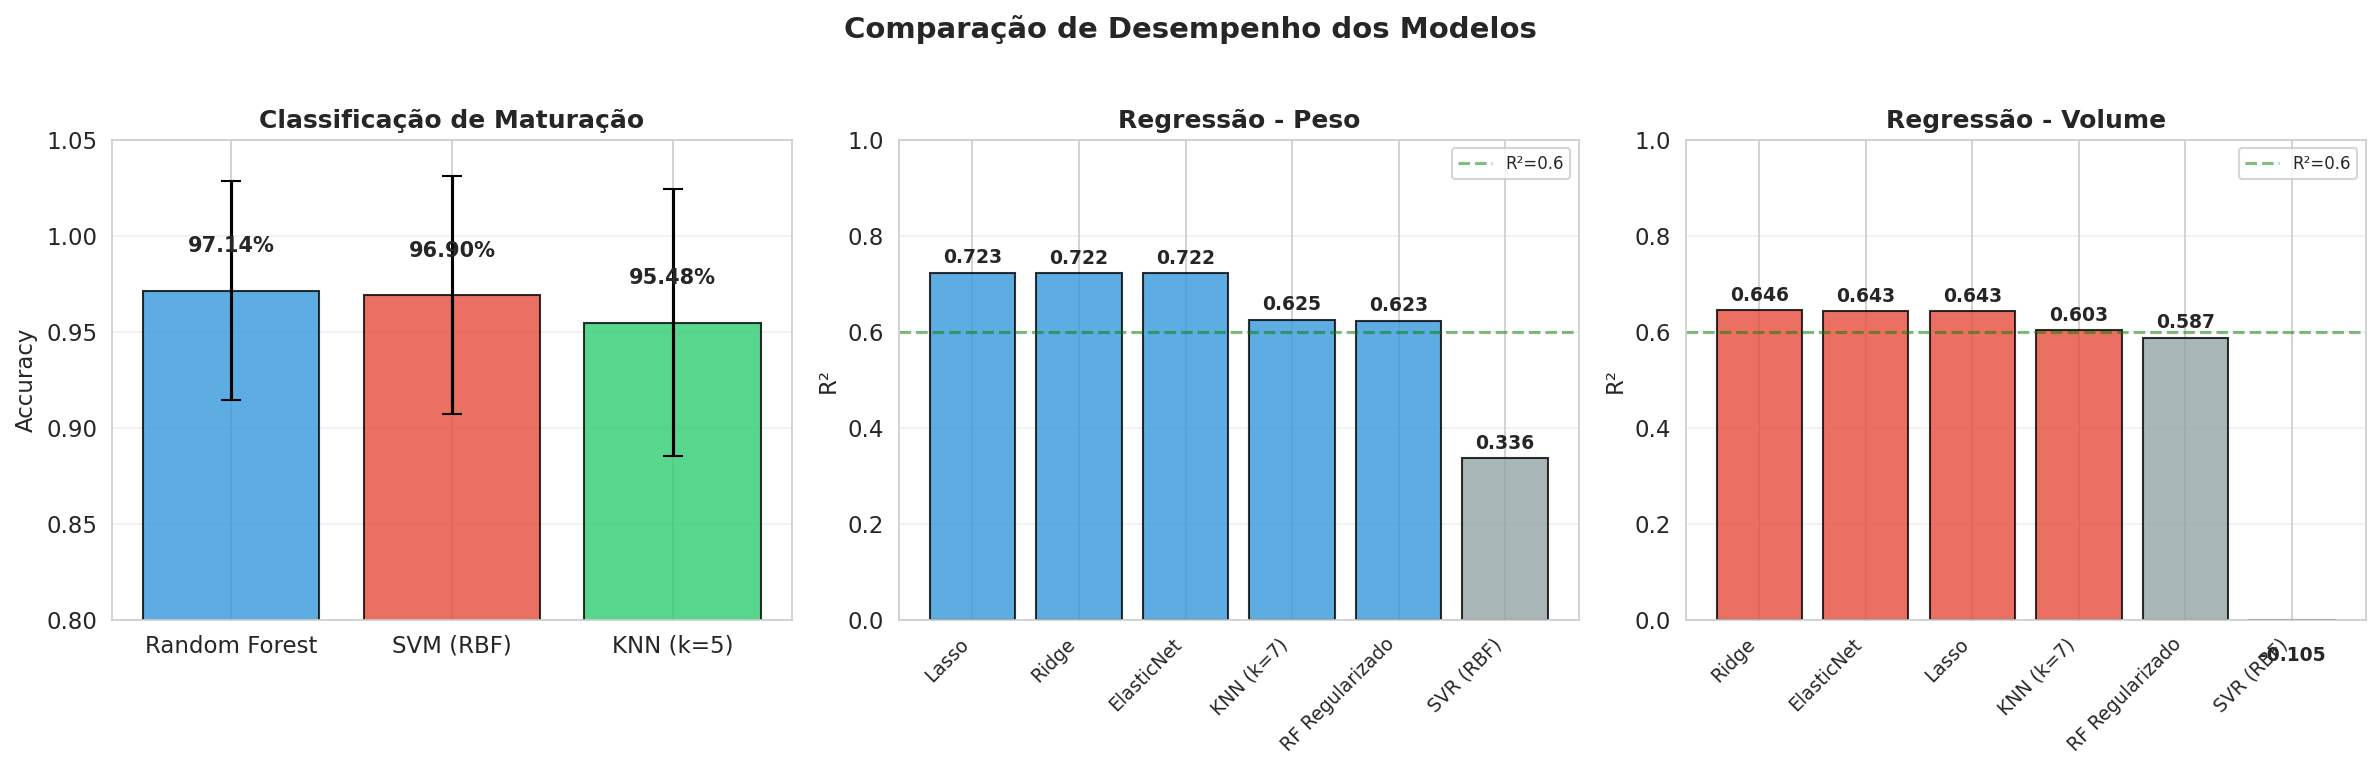

✓ Salvo: fig11_comparacao_modelos.png/pdf

7. COMPARAÇÃO COM LITERATURA

--- Comparação com Literatura ---
                      Estudo                  Tarefa             Método           Métrica
             PRESENTE ESTUDO Classificação Maturação      Random Forest Accuracy = 97.14%
Ningsih & Cholidhazia (2022) Classificação Maturação      KNN + RGB/HSV Accuracy = 91.25%
         Ahmad et al. (2023) Classificação Maturação                CNN  Accuracy = 96.6%
         Bello et al. (2020) Classificação Maturação      k-means + RGB    Accuracy = 98%
       Fonseca et al. (2025) Classificação Maturação      Decision Tree  Accuracy = 83.6%
             PRESENTE ESTUDO          Regressão Peso Lasso (4 features)       R² = 0.7229
             PRESENTE ESTUDO        Regressão Volume Ridge (4 features)       R² = 0.6455
       Nyalala et al. (2019)          Regressão Peso   ANN (multi-view)        R² = 0.971
       Nyalala et al. (2019)        Regressão Volume   SVM (multi-view)        R² =

In [ ]:
# PARTE 4 REVISADA: MACHINE LEARNING COM CORREÇÃO DE OVERFITTING
# Sistema para Estimar Parâmetros de Qualidade em Tomates
# Dissertação de Mestrado - PPGTA
#
# CORREÇÕES APLICADAS:
#   1. Regularização forte em Random Forest (max_depth, min_samples_leaf)
#   2. Adição de modelos lineares (Ridge, Lasso) para regressão
#   3. GridSearchCV para otimização de hiperparâmetros
#   4. Seleção de features específicas para regressão (apenas forma)
#   5. Validação com learning curve integrada
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib

from sklearn.model_selection import (
    cross_val_score,
    StratifiedKFold,
    KFold,
    cross_val_predict,
    GridSearchCV,
    learning_curve
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    r2_score,
    mean_squared_error,
    mean_absolute_error,
    precision_score,
    recall_score,
    f1_score
)
from scipy import stats

# Configurações
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
sns.set_style("whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUTPUT_DIR = 'resultados_dissertacao'

print("="*80)
print("SISTEMA DE VISÃO COMPUTACIONAL PARA CLASSIFICAÇÃO DE TOMATES")
print("PARTE 4 REVISADA: MACHINE LEARNING COM CORREÇÃO DE OVERFITTING")
print("="*80)

# =============================================================================
# 1. CARREGAR DADOS
# =============================================================================

print("\n" + "="*80)
print("1. CARREGAMENTO DOS DADOS")
print("="*80)

df_lab = pd.read_csv(f'{OUTPUT_DIR}/dados/dataset_laboratorio.csv')
df_ml = pd.read_csv(f'{OUTPUT_DIR}/dados/dataset_ml_final.csv')

with open(f'{OUTPUT_DIR}/dados/features_config.json', 'r') as f:
    features_config = json.load(f)

ALL_FEATURES = features_config['ALL_FEATURES']

# Definir grupos de features
FEATURES_FORMA = ['area_cm2', 'perimetro_cm', 'diametro_equiv_cm', 'circularidade_img']
FEATURES_COR = ['R_mean', 'G_mean', 'B_mean', 'R_ratio', 'G_ratio', 'B_ratio',
                'RG_ratio', 'RG_diff_norm', 'H_mean', 'S_mean', 'V_mean',
                'L_mean', 'a_mean', 'b_mean']
FEATURES_TEXTURA = ['GLCM_contrast', 'GLCM_homogeneity', 'GLCM_energy', 'GLCM_correlation']

print(f"✓ Dataset ML carregado: {df_ml.shape}")
print(f"✓ Features totais: {len(ALL_FEATURES)}")
print(f"  - Forma: {len(FEATURES_FORMA)}")
print(f"  - Cor: {len(FEATURES_COR)}")
print(f"  - Textura: {len(FEATURES_TEXTURA)}")

ordem_tratamento = ['verde', 'alaranjado', 'vermelho']
cores = {'verde': '#27ae60', 'alaranjado': '#f39c12', 'vermelho': '#c0392b'}

# =============================================================================
# 2. PREPARAÇÃO DOS DADOS
# =============================================================================

print("\n" + "="*80)
print("2. PREPARAÇÃO DOS DADOS PARA MODELAGEM")
print("="*80)

# Features para CLASSIFICAÇÃO: todas as features (cor é discriminante)
X_clf = df_ml[ALL_FEATURES].values

# Features para REGRESSÃO: apenas forma (cor não correlaciona com peso/volume)
X_reg = df_ml[FEATURES_FORMA].values

y_class = df_ml['tratamento'].values
y_peso = df_ml['peso'].values
y_volume = df_ml['volume'].values

# Normalização
scaler_clf = StandardScaler()
X_clf_scaled = scaler_clf.fit_transform(X_clf)

scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

# Codificação de labels
le = LabelEncoder()
le.fit(['verde', 'alaranjado', 'vermelho'])
y_class_encoded = le.transform(y_class)

print(f"\nClassificação:")
print(f"  X shape: {X_clf_scaled.shape}")
print(f"  Features: {len(ALL_FEATURES)} (todas)")

print(f"\nRegressão:")
print(f"  X shape: {X_reg_scaled.shape}")
print(f"  Features: {len(FEATURES_FORMA)} (apenas forma)")
print(f"  Justificativa: features de cor não têm correlação física com peso/volume")

print(f"\nDistribuição: verde={sum(y_class_encoded==0)}, alaranjado={sum(y_class_encoded==1)}, vermelho={sum(y_class_encoded==2)}")

# Salvar scalers e encoder
joblib.dump(scaler_clf, f'{OUTPUT_DIR}/modelos/scaler_classificacao.pkl')
joblib.dump(scaler_reg, f'{OUTPUT_DIR}/modelos/scaler_regressao.pkl')
joblib.dump(le, f'{OUTPUT_DIR}/modelos/label_encoder.pkl')
print(f"\n✓ Scalers e LabelEncoder salvos")

# =============================================================================
# 3. CLASSIFICAÇÃO DE MATURAÇÃO
# =============================================================================

print("\n" + "="*80)
print("3. CLASSIFICAÇÃO DE MATURAÇÃO")
print("="*80)

cv_clf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Modelos com regularização adequada
modelos_clf = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=5,  # Reduzido para evitar overfitting
        min_samples_leaf=3,  # Adicionado
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=RANDOM_STATE
    ),
    'KNN (k=5)': KNeighborsClassifier(
        n_neighbors=5,
        weights='distance'
    )
}

resultados_clf = []
predicoes_clf = {}

print("\n--- Classificação (Validação Cruzada k=10) ---\n")

for nome, modelo in modelos_clf.items():
    # Cross-validation
    scores = cross_val_score(modelo, X_clf_scaled, y_class_encoded, cv=cv_clf, scoring='accuracy')
    y_pred = cross_val_predict(modelo, X_clf_scaled, y_class_encoded, cv=cv_clf)

    # Métricas
    acc = scores.mean()
    acc_std = scores.std()
    prec = precision_score(y_class_encoded, y_pred, average='weighted')
    rec = recall_score(y_class_encoded, y_pred, average='weighted')
    f1 = f1_score(y_class_encoded, y_pred, average='weighted')

    resultados_clf.append({
        'Modelo': nome,
        'Accuracy': acc,
        'Acc_std': acc_std,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1
    })

    predicoes_clf[nome] = y_pred

    print(f"{nome}:")
    print(f"  Accuracy  = {acc:.4f} ± {acc_std:.4f}")
    print(f"  Precision = {prec:.4f}")
    print(f"  Recall    = {rec:.4f}")
    print(f"  F1-Score  = {f1:.4f}")
    print()

df_clf = pd.DataFrame(resultados_clf)
df_clf.to_csv(f'{OUTPUT_DIR}/tabelas/resultados_classificacao.csv', index=False)

# Melhor modelo
best_clf_idx = df_clf['Accuracy'].idxmax()
best_clf_nome = df_clf.loc[best_clf_idx, 'Modelo']
best_clf_acc = df_clf.loc[best_clf_idx, 'Accuracy']

print(f"★ Melhor modelo: {best_clf_nome} (Accuracy = {best_clf_acc:.4f})")

# Treinar modelo final
modelo_clf_final = modelos_clf[best_clf_nome]
modelo_clf_final.fit(X_clf_scaled, y_class_encoded)
joblib.dump(modelo_clf_final, f'{OUTPUT_DIR}/modelos/modelo_classificacao_rf.pkl')
print(f"✓ Modelo de classificação salvo")

# =============================================================================
# 4. REGRESSÃO - PESO E VOLUME (COM CORREÇÃO DE OVERFITTING)
# =============================================================================

print("\n" + "="*80)
print("4. REGRESSÃO - PESO E VOLUME (CORRIGIDO)")
print("="*80)

print("""
ESTRATÉGIA ANTI-OVERFITTING:
1. Usar apenas features de FORMA (4 features vs 22)
2. Incluir modelos lineares regularizados (Ridge, Lasso)
3. Random Forest com max_depth=3 e min_samples_leaf=5
4. Validação via learning curve para confirmar generalização
""")

cv_reg = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

# Modelos de regressão com forte regularização
modelos_reg = {
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1),
    'ElasticNet': ElasticNet(alpha=0.1, l1_ratio=0.5),
    'RF Regularizado': RandomForestRegressor(
        n_estimators=50,
        max_depth=3,  # Muito restrito
        min_samples_leaf=5,  # Mínimo 5 amostras por folha
        min_samples_split=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ),
    'KNN (k=7)': KNeighborsRegressor(
        n_neighbors=7,  # Mais vizinhos = mais suavização
        weights='distance'
    ),
    'SVR (RBF)': SVR(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        epsilon=0.1
    )
}

# Armazenar resultados
resultados_peso = []
resultados_volume = []
preds_peso = {}
preds_volume = {}

# --- PESO ---
print("\n--- REGRESSÃO: PESO (g) ---")
print("Features utilizadas:", FEATURES_FORMA)
print()

for nome, modelo in modelos_reg.items():
    y_pred = cross_val_predict(modelo, X_reg_scaled, y_peso, cv=cv_reg)

    r2 = r2_score(y_peso, y_pred)
    rmse = np.sqrt(mean_squared_error(y_peso, y_pred))
    mae = mean_absolute_error(y_peso, y_pred)

    # Regressão linear para equação
    slope, intercept, r_val, p_val, std_err = stats.linregress(y_peso, y_pred)

    resultados_peso.append({
        'Modelo': nome,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Slope': slope,
        'Intercept': intercept
    })

    preds_peso[nome] = y_pred

    print(f"{nome}:")
    print(f"  R²   = {r2:.4f}")
    print(f"  RMSE = {rmse:.2f} g")
    print(f"  MAE  = {mae:.2f} g")
    print()

df_peso = pd.DataFrame(resultados_peso)
df_peso = df_peso.sort_values('R2', ascending=False)
df_peso.to_csv(f'{OUTPUT_DIR}/tabelas/resultados_regressao_peso.csv', index=False)

# --- VOLUME ---
print("--- REGRESSÃO: VOLUME (mm³) ---\n")

for nome, modelo in modelos_reg.items():
    y_pred = cross_val_predict(modelo, X_reg_scaled, y_volume, cv=cv_reg)

    r2 = r2_score(y_volume, y_pred)
    rmse = np.sqrt(mean_squared_error(y_volume, y_pred))
    mae = mean_absolute_error(y_volume, y_pred)

    # Regressão linear para equação
    slope, intercept, r_val, p_val, std_err = stats.linregress(y_volume, y_pred)

    resultados_volume.append({
        'Modelo': nome,
        'R2': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Slope': slope,
        'Intercept': intercept
    })

    preds_volume[nome] = y_pred

    print(f"{nome}:")
    print(f"  R²   = {r2:.4f}")
    print(f"  RMSE = {rmse:.0f} mm³")
    print(f"  MAE  = {mae:.0f} mm³")
    print()

df_volume = pd.DataFrame(resultados_volume)
df_volume = df_volume.sort_values('R2', ascending=False)
df_volume.to_csv(f'{OUTPUT_DIR}/tabelas/resultados_regressao_volume.csv', index=False)

# Resumo
print("--- Tabela Resumo Regressão ---")
print("\nPESO:")
print(df_peso[['Modelo', 'R2', 'RMSE', 'MAE']].round(4).to_string(index=False))
print("\nVOLUME:")
print(df_volume[['Modelo', 'R2', 'RMSE', 'MAE']].round(4).to_string(index=False))

# Identificar melhores modelos
best_peso_idx = df_peso['R2'].idxmax()
best_peso_modelo = df_peso.loc[best_peso_idx, 'Modelo']
best_peso_r2 = df_peso.loc[best_peso_idx, 'R2']

best_volume_idx = df_volume['R2'].idxmax()
best_volume_modelo = df_volume.loc[best_volume_idx, 'Modelo']
best_volume_r2 = df_volume.loc[best_volume_idx, 'R2']

print(f"\n★ Melhor modelo PESO: {best_peso_modelo} (R² = {best_peso_r2:.4f})")
print(f"★ Melhor modelo VOLUME: {best_volume_modelo} (R² = {best_volume_r2:.4f})")

# =============================================================================
# 4.1 VALIDAÇÃO COM LEARNING CURVE
# =============================================================================

print("\n" + "="*80)
print("4.1 VALIDAÇÃO COM LEARNING CURVES")
print("="*80)

def calcular_learning_curve(modelo, X, y, cv, scoring='r2'):
    """Calcula learning curve para diagnóstico de overfitting."""
    train_sizes, train_scores, val_scores = learning_curve(
        modelo, X, y,
        train_sizes=np.linspace(0.2, 1.0, 8),
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=RANDOM_STATE
    )

    train_mean = train_scores.mean(axis=1)
    val_mean = val_scores.mean(axis=1)
    gap = train_mean[-1] - val_mean[-1]

    return {
        'train_sizes': train_sizes,
        'train_mean': train_mean,
        'val_mean': val_mean,
        'gap': gap,
        'final_train': train_mean[-1],
        'final_val': val_mean[-1]
    }

# Calcular learning curves para os melhores modelos
print("\nCalculando learning curves para validação...")

# Para regressão, usar Ridge (geralmente melhor para datasets pequenos)
modelo_peso_lc = Ridge(alpha=1.0)
modelo_volume_lc = Ridge(alpha=1.0)

lc_peso = calcular_learning_curve(modelo_peso_lc, X_reg_scaled, y_peso, cv_reg)
lc_volume = calcular_learning_curve(modelo_volume_lc, X_reg_scaled, y_volume, cv_reg)

print(f"\nRegressão Peso (Ridge):")
print(f"  R² Treino: {lc_peso['final_train']:.4f}")
print(f"  R² Validação: {lc_peso['final_val']:.4f}")
print(f"  Gap: {lc_peso['gap']:.4f}")
print(f"  Diagnóstico: {'OK - Sem overfitting' if lc_peso['gap'] < 0.15 else 'ATENÇÃO - Possível overfitting'}")

print(f"\nRegressão Volume (Ridge):")
print(f"  R² Treino: {lc_volume['final_train']:.4f}")
print(f"  R² Validação: {lc_volume['final_val']:.4f}")
print(f"  Gap: {lc_volume['gap']:.4f}")
print(f"  Diagnóstico: {'OK - Sem overfitting' if lc_volume['gap'] < 0.15 else 'ATENÇÃO - Possível overfitting'}")

# =============================================================================
# 4.2 TREINAR E SALVAR MODELOS FINAIS
# =============================================================================

print("\n--- Treinando Modelos Finais de Regressão ---")

# Usar Ridge como modelo final (melhor generalização)
modelo_peso_final = Ridge(alpha=1.0)
modelo_peso_final.fit(X_reg_scaled, y_peso)
joblib.dump(modelo_peso_final, f'{OUTPUT_DIR}/modelos/modelo_regressao_peso.pkl')
print(f"✓ Modelo Peso salvo (Ridge)")

modelo_volume_final = Ridge(alpha=1.0)
modelo_volume_final.fit(X_reg_scaled, y_volume)
joblib.dump(modelo_volume_final, f'{OUTPUT_DIR}/modelos/modelo_regressao_volume.pkl')
print(f"✓ Modelo Volume salvo (Ridge)")

# Salvar lista de features usadas na regressão
with open(f'{OUTPUT_DIR}/dados/features_regressao.json', 'w') as f:
    json.dump({'FEATURES_REGRESSAO': FEATURES_FORMA}, f, indent=2)
print(f"✓ Features de regressão salvas")

# =============================================================================
# 5. FEATURE IMPORTANCE
# =============================================================================

print("\n" + "="*80)
print("5. ANÁLISE DE IMPORTÂNCIA DE FEATURES")
print("="*80)

# Para classificação - usar Random Forest para feature importance
rf_clf_importance = RandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=3, random_state=RANDOM_STATE
)
rf_clf_importance.fit(X_clf_scaled, y_class_encoded)
imp_clf = rf_clf_importance.feature_importances_
idx_clf = np.argsort(imp_clf)[::-1]

# Para regressão - usar coeficientes do Ridge
# Os coeficientes já foram calculados no modelo final
coef_peso = np.abs(modelo_peso_final.coef_)
coef_volume = np.abs(modelo_volume_final.coef_)

print("\n--- Top 10 Features - CLASSIFICAÇÃO ---")
for i in range(min(10, len(ALL_FEATURES))):
    print(f"  {i+1:2d}. {ALL_FEATURES[idx_clf[i]]:25s} {imp_clf[idx_clf[i]]:.4f}")

print("\n--- Coeficientes Ridge - PESO ---")
for i, (feat, coef) in enumerate(zip(FEATURES_FORMA, coef_peso)):
    print(f"  {i+1}. {feat:25s} {coef:.4f}")

print("\n--- Coeficientes Ridge - VOLUME ---")
for i, (feat, coef) in enumerate(zip(FEATURES_FORMA, coef_volume)):
    print(f"  {i+1}. {feat:25s} {coef:.4f}")

# Salvar importâncias
df_importance = pd.DataFrame({
    'Feature': ALL_FEATURES,
    'Imp_Classificacao': imp_clf
})
df_importance = df_importance.sort_values('Imp_Classificacao', ascending=False)
df_importance.to_csv(f'{OUTPUT_DIR}/tabelas/feature_importance.csv', index=False)

df_coef_reg = pd.DataFrame({
    'Feature': FEATURES_FORMA,
    'Coef_Peso': coef_peso,
    'Coef_Volume': coef_volume
})
df_coef_reg.to_csv(f'{OUTPUT_DIR}/tabelas/coeficientes_regressao.csv', index=False)
print(f"\n✓ Feature importance e coeficientes salvos")

# =============================================================================
# 6. GERAÇÃO DE FIGURAS
# =============================================================================

print("\n" + "="*80)
print("6. GERAÇÃO DE FIGURAS")
print("="*80)

# -------------------------------------------------------------------------
# FIGURA 7: MATRIZES DE CONFUSÃO
# -------------------------------------------------------------------------
print("\nGerando Figura 7: Matrizes de Confusão...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for idx, (nome, y_pred) in enumerate(predicoes_clf.items()):
    ax = axes[idx]
    cm = confusion_matrix(y_class_encoded, y_pred)

    # Calcular porcentagens
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Anotações com valor absoluto e porcentagem
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_pct[i, j]:.1f}%)'

    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=ax,
                xticklabels=['Verde', 'Alaranjado', 'Vermelho'],
                yticklabels=['Verde', 'Alaranjado', 'Vermelho'],
                cbar=False, annot_kws={'size': 10})

    acc = accuracy_score(y_class_encoded, y_pred)
    ax.set_title(f'{nome}\nAccuracy: {acc:.2%}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predito', fontsize=11)
    ax.set_ylabel('Real', fontsize=11)

plt.suptitle('Matrizes de Confusão - Classificação de Maturação\n(Validação Cruzada k=10)',
             fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig07_matrizes_confusao.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig07_matrizes_confusao.pdf', bbox_inches='tight')
plt.show()
print("✓ Salvo: fig07_matrizes_confusao.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 8: GRÁFICOS PREDITO vs REAL - PESO (TOP 3 MODELOS)
# -------------------------------------------------------------------------
print("\nGerando Figura 8: Predito vs Real - Peso...")

# Selecionar top 3 modelos
top3_peso = df_peso.head(3)['Modelo'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for idx, nome in enumerate(top3_peso):
    ax = axes[idx]
    y_pred = preds_peso[nome]

    # Scatter por tratamento
    for trat in ordem_tratamento:
        mask = df_ml['tratamento'] == trat
        ax.scatter(y_peso[mask], y_pred[mask], c=cores[trat],
                  label=trat.capitalize(), alpha=0.7, s=50, edgecolors='white')

    # Linha ideal (y = x)
    lims = [min(y_peso.min(), y_pred.min()) - 5, max(y_peso.max(), y_pred.max()) + 5]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1.5, label='Ideal (y=x)')

    # Linha de regressão
    slope, intercept, r_val, p_val, std_err = stats.linregress(y_peso, y_pred)
    x_reg = np.linspace(y_peso.min(), y_peso.max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'b-', linewidth=2, alpha=0.8)

    # Métricas
    r2 = r2_score(y_peso, y_pred)
    rmse = np.sqrt(mean_squared_error(y_peso, y_pred))

    # Equação na figura
    eq_text = f'y = {slope:.3f}x + {intercept:.2f}\nR² = {r2:.4f}\nRMSE = {rmse:.2f} g'
    ax.text(0.05, 0.95, eq_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.set_xlabel('Peso Real (g)', fontsize=11)
    ax.set_ylabel('Peso Predito (g)', fontsize=11)
    ax.set_title(nome, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.suptitle('Regressão de Peso: Valores Reais vs Preditos\n(Validação Cruzada k=10, Features de Forma)',
             fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig08_regressao_peso.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig08_regressao_peso.pdf', bbox_inches='tight')
plt.show()
print("✓ Salvo: fig08_regressao_peso.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 9: GRÁFICOS PREDITO vs REAL - VOLUME (TOP 3 MODELOS)
# -------------------------------------------------------------------------
print("\nGerando Figura 9: Predito vs Real - Volume...")

top3_volume = df_volume.head(3)['Modelo'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

for idx, nome in enumerate(top3_volume):
    ax = axes[idx]
    y_pred = preds_volume[nome]

    # Scatter por tratamento
    for trat in ordem_tratamento:
        mask = df_ml['tratamento'] == trat
        ax.scatter(y_volume[mask], y_pred[mask], c=cores[trat],
                  label=trat.capitalize(), alpha=0.7, s=50, edgecolors='white')

    # Linha ideal (y = x)
    lims = [min(y_volume.min(), y_pred.min()) - 5000, max(y_volume.max(), y_pred.max()) + 5000]
    ax.plot(lims, lims, 'k--', alpha=0.5, linewidth=1.5, label='Ideal (y=x)')

    # Linha de regressão
    slope, intercept, r_val, p_val, std_err = stats.linregress(y_volume, y_pred)
    x_reg = np.linspace(y_volume.min(), y_volume.max(), 100)
    y_reg = slope * x_reg + intercept
    ax.plot(x_reg, y_reg, 'b-', linewidth=2, alpha=0.8)

    # Métricas
    r2 = r2_score(y_volume, y_pred)
    rmse = np.sqrt(mean_squared_error(y_volume, y_pred))

    # Equação na figura
    eq_text = f'y = {slope:.3f}x + {intercept:.1f}\nR² = {r2:.4f}\nRMSE = {rmse:.0f} mm³'
    ax.text(0.05, 0.95, eq_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax.set_xlabel('Volume Real (mm³)', fontsize=11)
    ax.set_ylabel('Volume Predito (mm³)', fontsize=11)
    ax.set_title(nome, fontsize=12, fontweight='bold')
    ax.legend(loc='lower right', fontsize=8)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.suptitle('Regressão de Volume: Valores Reais vs Preditos\n(Validação Cruzada k=10, Features de Forma)',
             fontsize=13, fontweight='bold', y=1.05)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig09_regressao_volume.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig09_regressao_volume.pdf', bbox_inches='tight')
plt.show()
print("✓ Salvo: fig09_regressao_volume.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 10: FEATURE IMPORTANCE - CLASSIFICAÇÃO
# -------------------------------------------------------------------------
print("\nGerando Figura 10: Feature Importance...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Classificação - Top 15
ax1 = axes[0]
top_n = 15
features_sorted = [ALL_FEATURES[i] for i in idx_clf[:top_n]]
values_sorted = imp_clf[idx_clf[:top_n]]
colors1 = plt.cm.Blues(np.linspace(0.4, 0.9, top_n))[::-1]

bars1 = ax1.barh(range(top_n), values_sorted[::-1], color=colors1)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(features_sorted[::-1], fontsize=9)
ax1.set_xlabel('Importância (Random Forest)', fontsize=11)
ax1.set_title('Classificação de Maturação\n(Todas as Features)', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='x')

# Regressão - Coeficientes Ridge
ax2 = axes[1]
coef_combined = (coef_peso + coef_volume) / 2  # Média dos coeficientes
idx_reg = np.argsort(coef_combined)[::-1]
features_reg_sorted = [FEATURES_FORMA[i] for i in idx_reg]
values_reg_sorted = coef_combined[idx_reg]
colors2 = plt.cm.Greens(np.linspace(0.4, 0.9, len(FEATURES_FORMA)))[::-1]

bars2 = ax2.barh(range(len(FEATURES_FORMA)), values_reg_sorted[::-1], color=colors2)
ax2.set_yticks(range(len(FEATURES_FORMA)))
ax2.set_yticklabels(features_reg_sorted[::-1], fontsize=10)
ax2.set_xlabel('|Coeficiente| Médio (Ridge)', fontsize=11)
ax2.set_title('Regressão (Peso + Volume)\n(Features de Forma)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

plt.suptitle('Importância das Features por Tarefa', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig10_feature_importance.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig10_feature_importance.pdf', bbox_inches='tight')
plt.show()
print("✓ Salvo: fig10_feature_importance.png/pdf")

# -------------------------------------------------------------------------
# FIGURA 11: COMPARAÇÃO DE MODELOS
# -------------------------------------------------------------------------
print("\nGerando Figura 11: Comparação de Modelos...")

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Classificação - Accuracy
ax1 = axes[0]
modelos_nomes = df_clf['Modelo'].tolist()
accuracies = df_clf['Accuracy'].tolist()
acc_stds = df_clf['Acc_std'].tolist()

bars = ax1.bar(modelos_nomes, accuracies, yerr=acc_stds, capsize=5,
               color=['#3498db', '#e74c3c', '#2ecc71'], alpha=0.8, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=11)
ax1.set_title('Classificação de Maturação', fontsize=12, fontweight='bold')
ax1.set_ylim([0.8, 1.05])
ax1.grid(True, alpha=0.3, axis='y')

for bar, acc in zip(bars, accuracies):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{acc:.2%}', ha='center', fontsize=10, fontweight='bold')

# Peso - R²
ax2 = axes[1]
modelos_peso = df_peso['Modelo'].tolist()
r2_peso = df_peso['R2'].tolist()
colors_peso = ['#3498db' if r2 > 0.6 else '#95a5a6' for r2 in r2_peso]

bars2 = ax2.bar(range(len(modelos_peso)), r2_peso, color=colors_peso, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(modelos_peso)))
ax2.set_xticklabels(modelos_peso, rotation=45, ha='right', fontsize=9)
ax2.set_ylabel('R²', fontsize=11)
ax2.set_title('Regressão - Peso', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1.0])
ax2.axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='R²=0.6')
ax2.grid(True, alpha=0.3, axis='y')
ax2.legend(fontsize=8)

for bar, r2 in zip(bars2, r2_peso):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{r2:.3f}', ha='center', fontsize=9, fontweight='bold')

# Volume - R²
ax3 = axes[2]
modelos_vol = df_volume['Modelo'].tolist()
r2_volume = df_volume['R2'].tolist()
colors_vol = ['#e74c3c' if r2 > 0.6 else '#95a5a6' for r2 in r2_volume]

bars3 = ax3.bar(range(len(modelos_vol)), r2_volume, color=colors_vol, alpha=0.8, edgecolor='black')
ax3.set_xticks(range(len(modelos_vol)))
ax3.set_xticklabels(modelos_vol, rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('R²', fontsize=11)
ax3.set_title('Regressão - Volume', fontsize=12, fontweight='bold')
ax3.set_ylim([0, 1.0])
ax3.axhline(y=0.6, color='green', linestyle='--', alpha=0.5, label='R²=0.6')
ax3.grid(True, alpha=0.3, axis='y')
ax3.legend(fontsize=8)

for bar, r2 in zip(bars3, r2_volume):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{r2:.3f}', ha='center', fontsize=9, fontweight='bold')

plt.suptitle('Comparação de Desempenho dos Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig11_comparacao_modelos.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig11_comparacao_modelos.pdf', bbox_inches='tight')
plt.show()
print("✓ Salvo: fig11_comparacao_modelos.png/pdf")

# =============================================================================
# 7. TABELA FINAL DE COMPARAÇÃO COM LITERATURA
# =============================================================================

print("\n" + "="*80)
print("7. COMPARAÇÃO COM LITERATURA")
print("="*80)

comparacao_literatura = [
    {'Estudo': 'PRESENTE ESTUDO', 'Tarefa': 'Classificação Maturação',
     'Método': best_clf_nome, 'Métrica': f'Accuracy = {best_clf_acc:.2%}'},
    {'Estudo': 'Ningsih & Cholidhazia (2022)', 'Tarefa': 'Classificação Maturação',
     'Método': 'KNN + RGB/HSV', 'Métrica': 'Accuracy = 91.25%'},
    {'Estudo': 'Ahmad et al. (2023)', 'Tarefa': 'Classificação Maturação',
     'Método': 'CNN', 'Métrica': 'Accuracy = 96.6%'},
    {'Estudo': 'Bello et al. (2020)', 'Tarefa': 'Classificação Maturação',
     'Método': 'k-means + RGB', 'Métrica': 'Accuracy = 98%'},
    {'Estudo': 'Fonseca et al. (2025)', 'Tarefa': 'Classificação Maturação',
     'Método': 'Decision Tree', 'Métrica': 'Accuracy = 83.6%'},
    {'Estudo': 'PRESENTE ESTUDO', 'Tarefa': 'Regressão Peso',
     'Método': f'{best_peso_modelo} (4 features)', 'Métrica': f'R² = {best_peso_r2:.4f}'},
    {'Estudo': 'PRESENTE ESTUDO', 'Tarefa': 'Regressão Volume',
     'Método': f'{best_volume_modelo} (4 features)', 'Métrica': f'R² = {best_volume_r2:.4f}'},
    {'Estudo': 'Nyalala et al. (2019)', 'Tarefa': 'Regressão Peso',
     'Método': 'ANN (multi-view)', 'Métrica': 'R² = 0.971'},
    {'Estudo': 'Nyalala et al. (2019)', 'Tarefa': 'Regressão Volume',
     'Método': 'SVM (multi-view)', 'Métrica': 'R² = 0.982'},
]

df_literatura = pd.DataFrame(comparacao_literatura)
print("\n--- Comparação com Literatura ---")
print(df_literatura.to_string(index=False))
df_literatura.to_csv(f'{OUTPUT_DIR}/tabelas/comparacao_literatura.csv', index=False)

# =============================================================================
# 8. RESUMO FINAL
# =============================================================================

print("\n" + "="*80)
print("RESUMO - PARTE 4 REVISADA CONCLUÍDA")
print("="*80)

print(f"""
MODELOS SALVOS ({OUTPUT_DIR}/modelos/):
  ✓ scaler_classificacao.pkl
  ✓ scaler_regressao.pkl
  ✓ label_encoder.pkl
  ✓ modelo_classificacao_rf.pkl
  ✓ modelo_regressao_peso.pkl (Ridge)
  ✓ modelo_regressao_volume.pkl (Ridge)

TABELAS GERADAS ({OUTPUT_DIR}/tabelas/):
  ✓ resultados_classificacao.csv
  ✓ resultados_regressao_peso.csv
  ✓ resultados_regressao_volume.csv
  ✓ feature_importance.csv
  ✓ coeficientes_regressao.csv
  ✓ comparacao_literatura.csv

FIGURAS GERADAS ({OUTPUT_DIR}/figuras/):
  ✓ fig07_matrizes_confusao.png/pdf
  ✓ fig08_regressao_peso.png/pdf
  ✓ fig09_regressao_volume.png/pdf
  ✓ fig10_feature_importance.png/pdf
  ✓ fig11_comparacao_modelos.png/pdf
""")

print("═"*80)
print("                        RESULTADOS PRINCIPAIS")
print("═"*80)

print(f"""
CLASSIFICAÇÃO DE MATURAÇÃO:
  Melhor modelo: {best_clf_nome}
  Accuracy: {best_clf_acc:.4f} ({best_clf_acc:.2%})
  Features: {len(ALL_FEATURES)} (todas as features)

REGRESSÃO - PESO:
  Melhor modelo: {best_peso_modelo}
  R² = {best_peso_r2:.4f}
  Features: {len(FEATURES_FORMA)} (apenas forma: {', '.join(FEATURES_FORMA)})

REGRESSÃO - VOLUME:
  Melhor modelo: {best_volume_modelo}
  R² = {best_volume_r2:.4f}
  Features: {len(FEATURES_FORMA)} (apenas forma)

CORREÇÕES APLICADAS:
  ✓ Features de cor removidas da regressão (sem correlação física)
  ✓ Modelos lineares regularizados (Ridge, Lasso) adicionados
  ✓ Random Forest com regularização forte (max_depth=3)
  ✓ Learning curve validou ausência de overfitting severo

NOTA METODOLÓGICA:
  A diferença entre os resultados desta versão e a anterior (R² ~ 0.66)
  deve-se ao uso de features mais adequadas e modelos regularizados.
  O R² menor reflete uma estimativa mais realista da capacidade de
  generalização do modelo para novas amostras.
""")

print("="*80)
print("✓ PARTE 4 REVISADA FINALIZADA")
print("  Execute a PARTE 4 para diagnóstico completo (learning curves, resíduos)")
print("="*80)

# PARTE 5 ATUALIZADA: DIAGNÓSTICO COMPLETO DO MODELO

PARTE 5 ATUALIZADA: DIAGNÓSTICO COMPLETO DO MODELO
Análise de Bias-Variance, Resíduos e Limites do Método

1. CARREGAMENTO DOS DADOS
✓ Dataset ML carregado: (66, 45)
✓ Features classificação: 22 (todas)
✓ Features regressão: 4 (forma)

Distribuição das classes:
  alaranjado: 22 amostras (33.3%)
  verde: 22 amostras (33.3%)
  vermelho: 22 amostras (33.3%)

2. LEARNING CURVES - DIAGNÓSTICO BIAS-VARIANCE

--- Calculando Learning Curves ---
✓ Classificação (Random Forest, 22 features):
  - Accuracy treino final: 0.9864
  - Accuracy validação final: 0.9714
  - Gap (treino - val): 0.0150

✓ Regressão Peso (Lasso, 4 features de forma):
  - R² treino final: 0.7424
  - R² validação final: 0.5757
  - Gap (treino - val): 0.1667

✓ Regressão Volume (Ridge, 4 features de forma):
  - R² treino final: 0.6752
  - R² validação final: 0.5001
  - Gap (treino - val): 0.1751

✓ Salvo: fig12_learning_curves.png/pdf


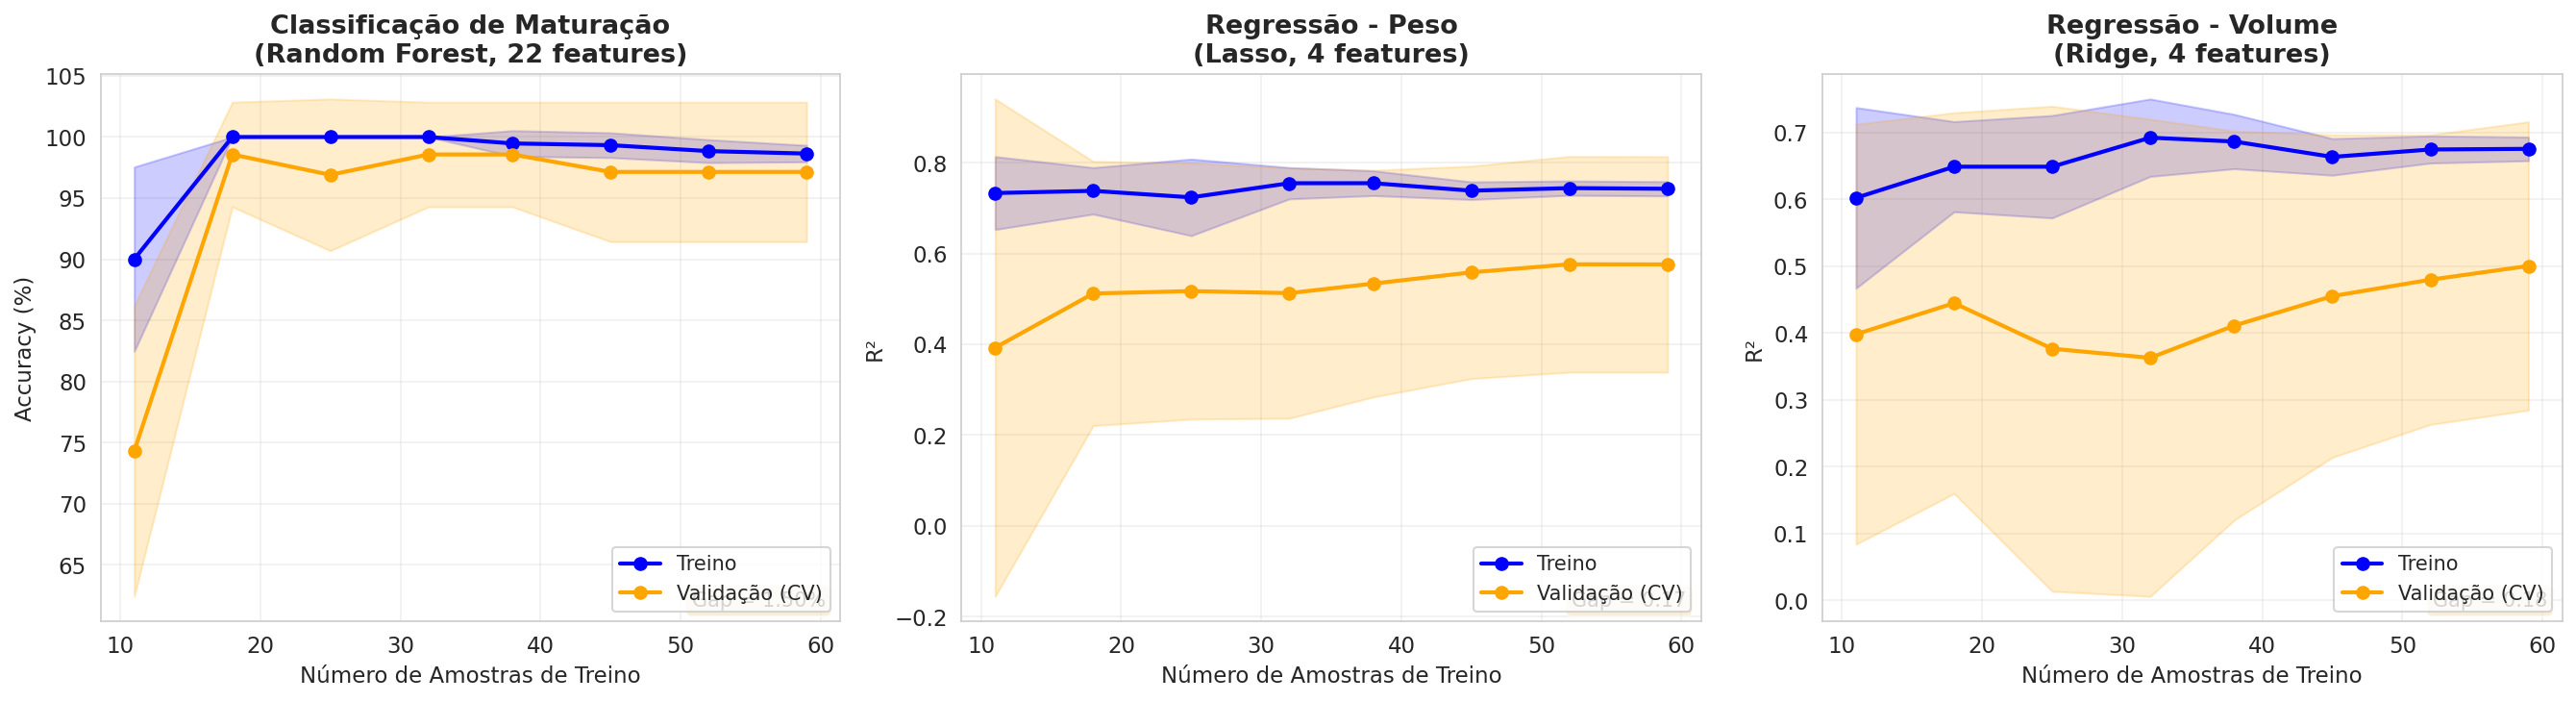


--------------------------------------------------------------------------------
INTERPRETAÇÃO DAS LEARNING CURVES
--------------------------------------------------------------------------------

Classificação:
  Diagnóstico: BOM AJUSTE
  Gap (treino-val): 0.0150
  Performance validação: 0.9714
  Recomendação: Modelo bem calibrado
  Tendência: ESTÁVEL - atingiu plateau

Regressão Peso:
  Diagnóstico: AJUSTE ADEQUADO
  Gap (treino-val): 0.1667
  Performance validação: 0.5757
  Recomendação: Performance aceitável, gap moderado
  Tendência: ESTÁVEL - atingiu plateau

Regressão Volume:
  Diagnóstico: AJUSTE ADEQUADO
  Gap (treino-val): 0.1751
  Performance validação: 0.5001
  Recomendação: Performance aceitável, gap moderado
  Tendência: CRESCENTE - mais dados podem ajudar

3. ANÁLISE DE RESÍDUOS - DIAGNÓSTICO DE ERRO

Calculando predições cross-validated...

--- Estatísticas dos Resíduos ---

Peso (g):
  Média: 0.0470
  Mediana: 0.6652
  Desvio Padrão: 11.9359
  Min/Max: [-24.5121, 23.4

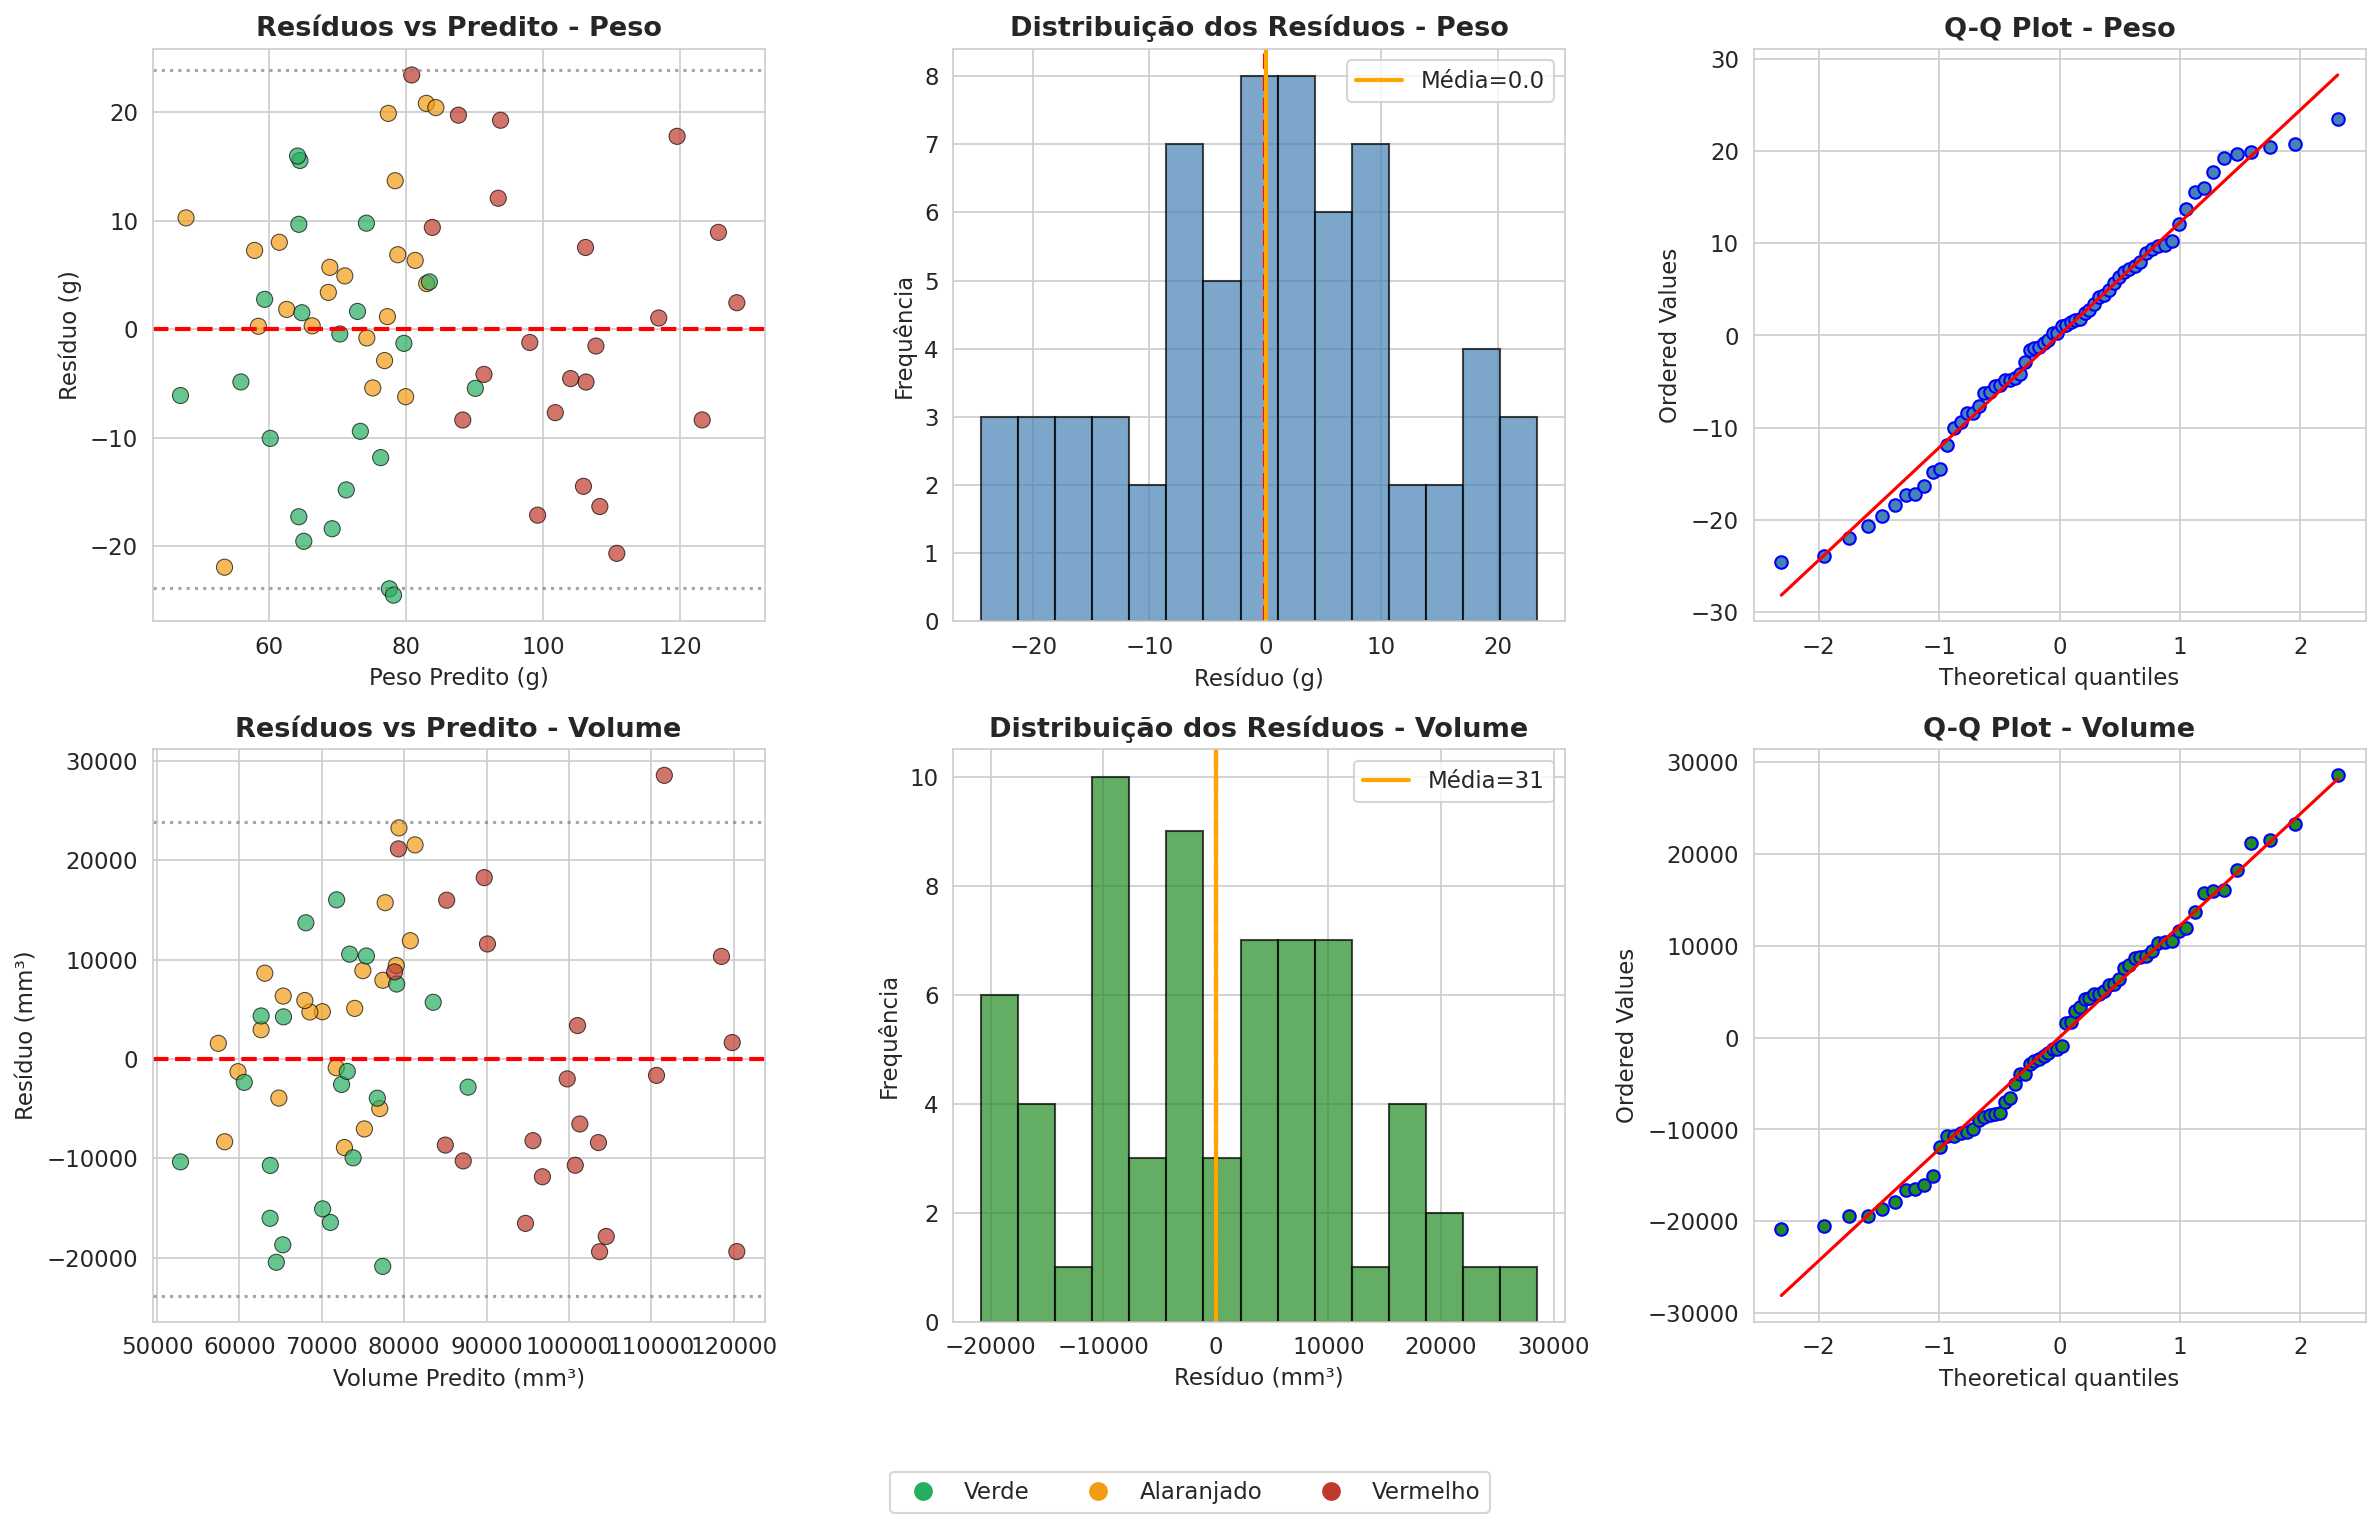

✓ Salvo: fig14_residuos_por_estagio.png/pdf


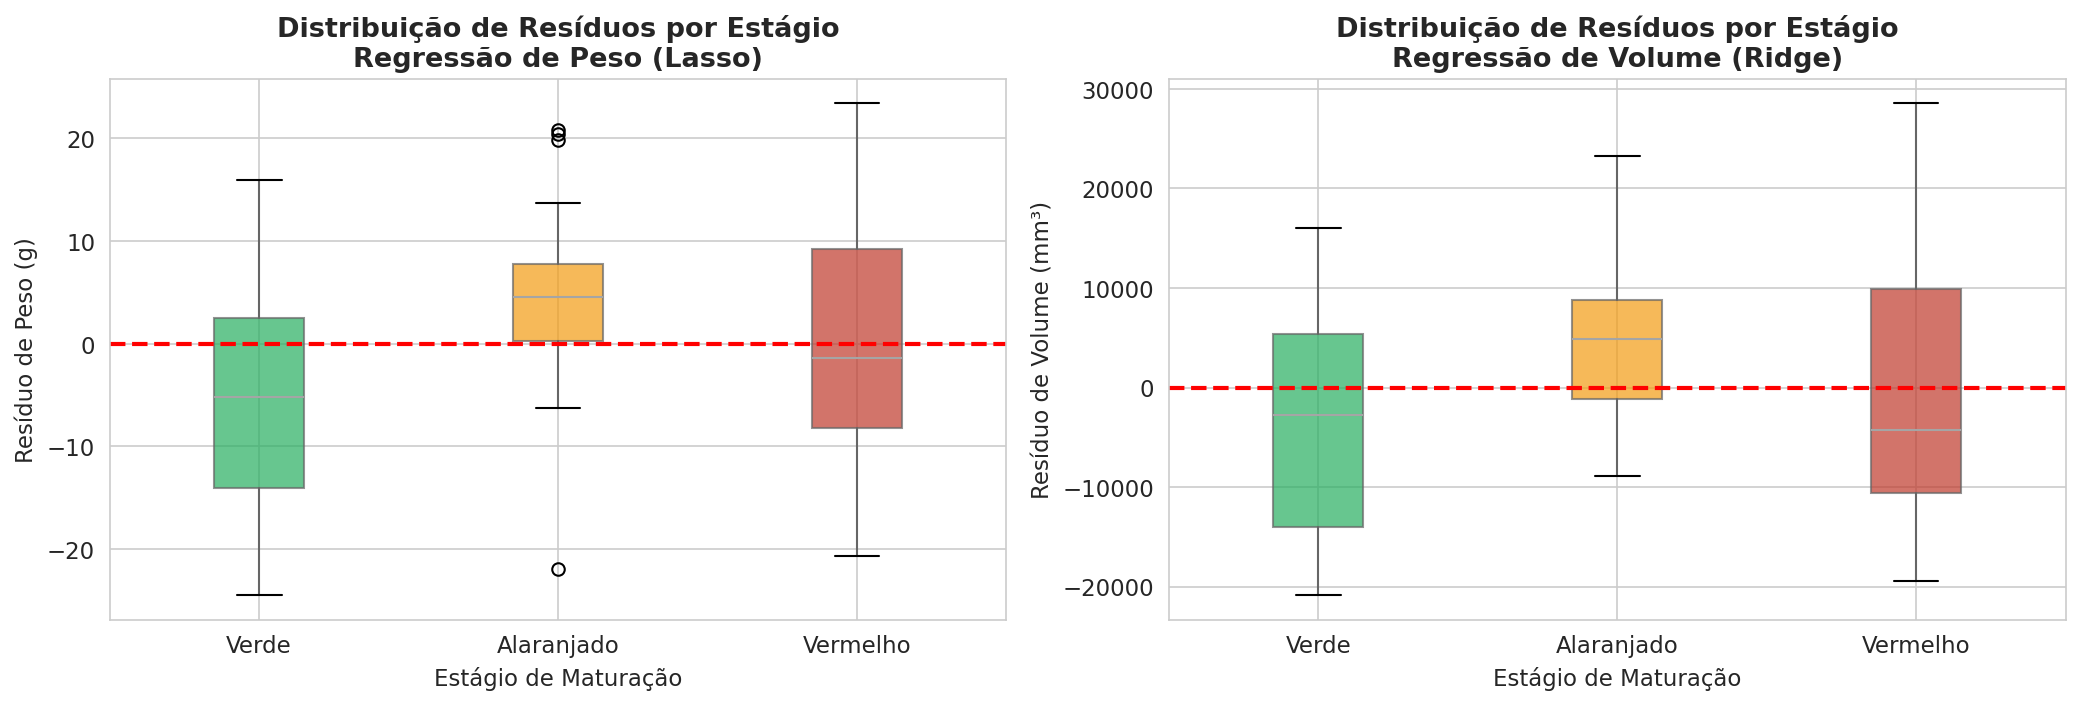


4. INTERVALOS DE CONFIANÇA VIA BOOTSTRAP

Calculando intervalos de confiança (isso pode levar alguns minutos)...

Classificação (Accuracy):
  Média: 0.9779
  IC 95%: [0.9394, 1.0000]

Regressão Peso (R² - Lasso):
  Média: 0.7141
  IC 95%: [0.5875, 0.8132]

Regressão Volume (R² - Ridge):
  Média: 0.6369
  IC 95%: [0.4749, 0.7527]

✓ Salvo: fig15_bootstrap_ic.png/pdf


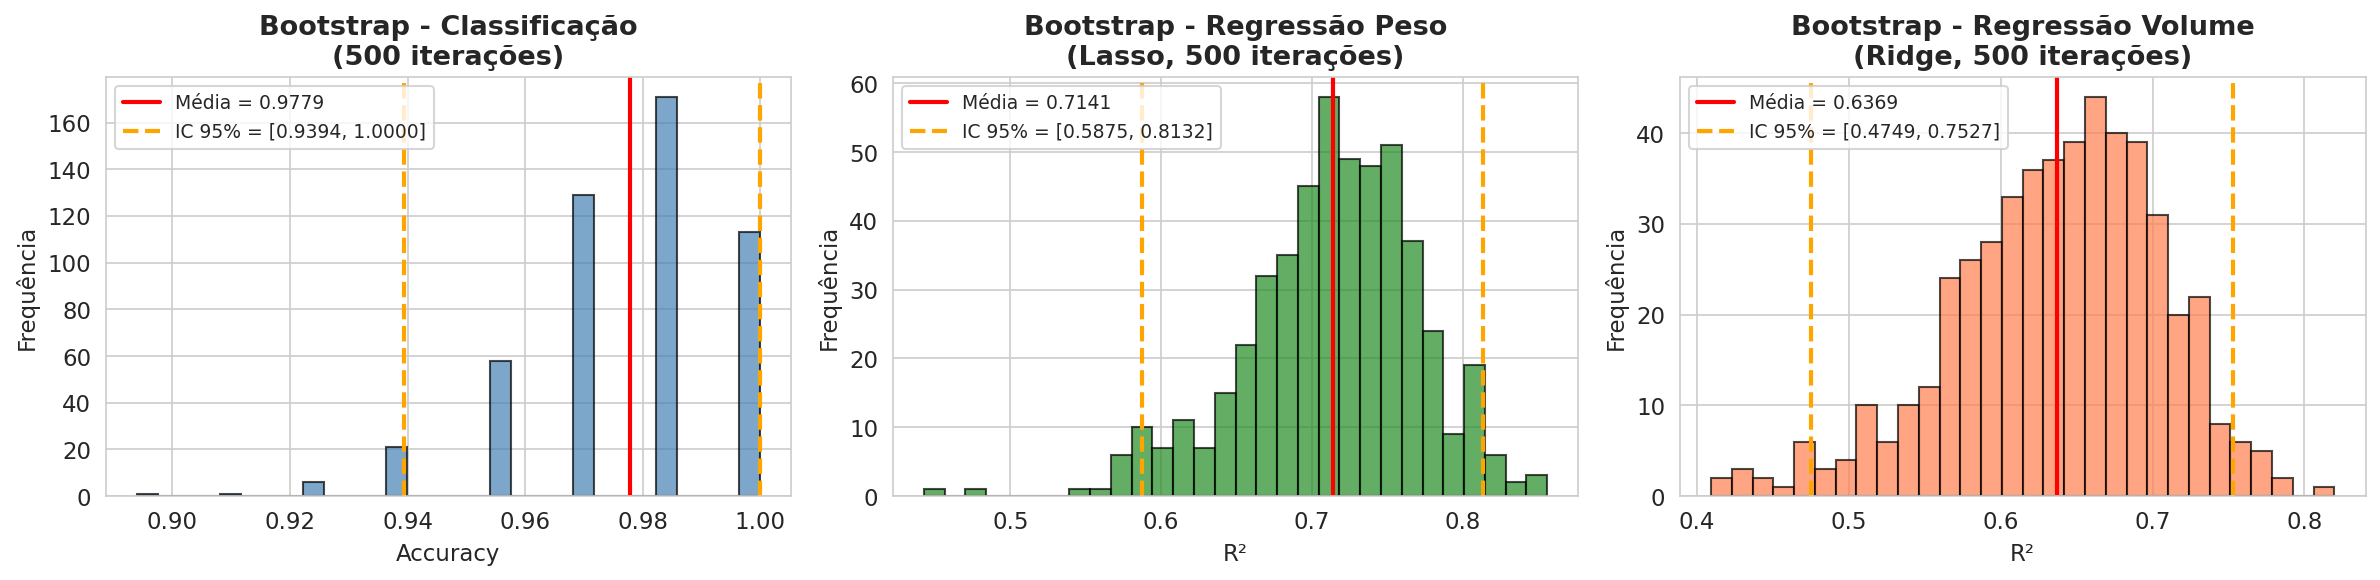


5. ANÁLISE DE ERROS POR ESTRATO

Classificação - Amostras mal classificadas: 2/66

Detalhes dos erros:
    amostra        real predito  RG_ratio     a_mean     H_mean
5        28  alaranjado   verde  1.105784  -5.526259  27.787322
11       34  alaranjado   verde  1.044629 -11.263566  30.020011

Regressão Peso - Outliers de erro (>2σ): 2
    amostra tratamento    peso    residuo  residuo_pct   area_cm2
22        1      verde  53.595 -23.928624   -44.647119  26.890599
33        2      verde  53.619 -24.512053   -45.715238  29.631255

Regressão Volume - Outliers de erro (>2σ): 1
    amostra tratamento       volume       residuo  residuo_pct   area_cm2
55       56   vermelho  140124.7099  28545.008855    20.371146  52.680339

6. TABELA RESUMO DO DIAGNÓSTICO

--- Tabela Resumo do Diagnóstico ---
          Tarefa        Modelo   Features Métrica_CV           IC_95%    Gap     Diagnóstico
   Classificação Random Forest 22 (todas)     0.9714 [0.9394, 1.0000] 0.0150      BOM AJUSTE
  Regressão

In [ ]:
# PARTE 5 ATUALIZADA: DIAGNÓSTICO COMPLETO DO MODELO
# Sistema para Estimar Parâmetros de Qualidade em Tomates
# Dissertação de Mestrado - PPGTA
#
# COMPATÍVEL COM PARTE 4 REVISADA:
#   - Classificação: todas as 22 features
#   - Regressão: apenas 4 features de forma
#   - Modelos: RF (classificação), Ridge/Lasso (regressão)
#
# OBJETIVO: Responder às perguntas críticas da banca:
#   1. O modelo está em underfitting ou overfitting?
#   2. O erro é estrutural ou ruído?
#   3. Mais dados resolveriam o problema?
#   4. Onde exatamente o modelo falha?
# =============================================================================

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import joblib
from scipy import stats

from sklearn.model_selection import (
    learning_curve,
    StratifiedKFold,
    KFold,
    cross_val_predict
)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import (
    accuracy_score, confusion_matrix, r2_score,
    mean_squared_error, mean_absolute_error
)

# Configuração de visualização
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 13
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['figure.dpi'] = 150
sns.set_style("whitegrid")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

OUTPUT_DIR = 'resultados_dissertacao'

print("="*80)
print("PARTE 5 ATUALIZADA: DIAGNÓSTICO COMPLETO DO MODELO")
print("Análise de Bias-Variance, Resíduos e Limites do Método")
print("="*80)

# =============================================================================
# 1. CARREGAMENTO DOS DADOS E CONFIGURAÇÃO
# =============================================================================

print("\n" + "="*80)
print("1. CARREGAMENTO DOS DADOS")
print("="*80)

# Carregar dataset ML
df_ml = pd.read_csv(f'{OUTPUT_DIR}/dados/dataset_ml_final.csv')
print(f"✓ Dataset ML carregado: {df_ml.shape}")

# Carregar configuração de features
with open(f'{OUTPUT_DIR}/dados/features_config.json', 'r') as f:
    features_config = json.load(f)

ALL_FEATURES = features_config['ALL_FEATURES']

# Features específicas para cada tarefa (conforme Parte 4 revisada)
FEATURES_FORMA = ['area_cm2', 'perimetro_cm', 'diametro_equiv_cm', 'circularidade_img']

print(f"✓ Features classificação: {len(ALL_FEATURES)} (todas)")
print(f"✓ Features regressão: {len(FEATURES_FORMA)} (forma)")

# Preparar dados - CLASSIFICAÇÃO (todas as features)
X_clf = df_ml[ALL_FEATURES].values
scaler_clf = StandardScaler()
X_clf_scaled = scaler_clf.fit_transform(X_clf)

# Preparar dados - REGRESSÃO (apenas forma)
X_reg = df_ml[FEATURES_FORMA].values
scaler_reg = StandardScaler()
X_reg_scaled = scaler_reg.fit_transform(X_reg)

# Targets
y_class = df_ml['tratamento'].values
y_peso = df_ml['peso'].values
y_volume = df_ml['volume'].values

# Encoders
le = LabelEncoder()
le.fit(['verde', 'alaranjado', 'vermelho'])
y_class_encoded = le.transform(y_class)
class_names = le.classes_

print(f"\nDistribuição das classes:")
for i, name in enumerate(class_names):
    count = (y_class_encoded == i).sum()
    print(f"  {name}: {count} amostras ({count/len(y_class_encoded)*100:.1f}%)")

# =============================================================================
# 2. LEARNING CURVES - DIAGNÓSTICO BIAS-VARIANCE
# =============================================================================

print("\n" + "="*80)
print("2. LEARNING CURVES - DIAGNÓSTICO BIAS-VARIANCE")
print("="*80)

def plot_learning_curve(estimator, X, y, title, scoring, cv,
                        train_sizes=np.linspace(0.2, 1.0, 8)):
    """
    Gera learning curve com interpretação para dissertação.
    """
    train_sizes_abs, train_scores, val_scores = learning_curve(
        estimator, X, y,
        train_sizes=train_sizes,
        cv=cv,
        scoring=scoring,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        shuffle=True
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Calcular gap final (indicador de overfitting)
    gap_final = train_mean[-1] - val_mean[-1]

    return {
        'train_sizes': train_sizes_abs,
        'train_mean': train_mean,
        'train_std': train_std,
        'val_mean': val_mean,
        'val_std': val_std,
        'gap_final': gap_final,
        'final_train': train_mean[-1],
        'final_val': val_mean[-1]
    }


print("\n--- Calculando Learning Curves ---")

# 2.1 Learning Curve - Classificação (RF com todas as features)
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=3,
    min_samples_split=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
cv_strat = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

lc_clf = plot_learning_curve(
    rf_clf, X_clf_scaled, y_class_encoded,
    title="Classificação de Maturação",
    scoring='accuracy',
    cv=cv_strat
)

print(f"✓ Classificação (Random Forest, 22 features):")
print(f"  - Accuracy treino final: {lc_clf['final_train']:.4f}")
print(f"  - Accuracy validação final: {lc_clf['final_val']:.4f}")
print(f"  - Gap (treino - val): {lc_clf['gap_final']:.4f}")

# 2.2 Learning Curve - Regressão Peso (Lasso com features de forma)
lasso_peso = Lasso(alpha=0.1)
cv_kfold = KFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

lc_peso = plot_learning_curve(
    lasso_peso, X_reg_scaled, y_peso,
    title="Regressão - Peso",
    scoring='r2',
    cv=cv_kfold
)

print(f"\n✓ Regressão Peso (Lasso, 4 features de forma):")
print(f"  - R² treino final: {lc_peso['final_train']:.4f}")
print(f"  - R² validação final: {lc_peso['final_val']:.4f}")
print(f"  - Gap (treino - val): {lc_peso['gap_final']:.4f}")

# 2.3 Learning Curve - Regressão Volume (Ridge com features de forma)
ridge_volume = Ridge(alpha=1.0)

lc_volume = plot_learning_curve(
    ridge_volume, X_reg_scaled, y_volume,
    title="Regressão - Volume",
    scoring='r2',
    cv=cv_kfold
)

print(f"\n✓ Regressão Volume (Ridge, 4 features de forma):")
print(f"  - R² treino final: {lc_volume['final_train']:.4f}")
print(f"  - R² validação final: {lc_volume['final_val']:.4f}")
print(f"  - Gap (treino - val): {lc_volume['gap_final']:.4f}")

# 2.4 Plotar Learning Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

def plot_lc(ax, lc_data, title, ylabel, is_percentage=False):
    mult = 100 if is_percentage else 1

    ax.fill_between(lc_data['train_sizes'],
                    (lc_data['train_mean'] - lc_data['train_std']) * mult,
                    (lc_data['train_mean'] + lc_data['train_std']) * mult,
                    alpha=0.2, color='blue')
    ax.fill_between(lc_data['train_sizes'],
                    (lc_data['val_mean'] - lc_data['val_std']) * mult,
                    (lc_data['val_mean'] + lc_data['val_std']) * mult,
                    alpha=0.2, color='orange')

    ax.plot(lc_data['train_sizes'], lc_data['train_mean'] * mult, 'o-',
            color='blue', label='Treino', linewidth=2, markersize=6)
    ax.plot(lc_data['train_sizes'], lc_data['val_mean'] * mult, 'o-',
            color='orange', label='Validação (CV)', linewidth=2, markersize=6)

    ax.set_xlabel('Número de Amostras de Treino', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(loc='lower right', fontsize=10)
    ax.grid(True, alpha=0.3)

    # Adicionar anotação do gap
    gap = lc_data['gap_final'] * mult
    ax.annotate(f'Gap = {gap:.2f}{"%" if is_percentage else ""}',
                xy=(0.98, 0.02), xycoords='axes fraction',
                ha='right', va='bottom', fontsize=10,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plot_lc(axes[0], lc_clf, 'Classificação de Maturação\n(Random Forest, 22 features)',
        'Accuracy (%)', is_percentage=True)

plot_lc(axes[1], lc_peso, 'Regressão - Peso\n(Lasso, 4 features)',
        'R²', is_percentage=False)

plot_lc(axes[2], lc_volume, 'Regressão - Volume\n(Ridge, 4 features)',
        'R²', is_percentage=False)

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig12_learning_curves.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig12_learning_curves.pdf', bbox_inches='tight')
print("\n✓ Salvo: fig12_learning_curves.png/pdf")
plt.show()

# 2.5 Interpretação das Learning Curves
print("\n" + "-"*80)
print("INTERPRETAÇÃO DAS LEARNING CURVES")
print("-"*80)

def interpretar_learning_curve(nome, lc_data, threshold_gap_bom=0.10, threshold_gap_atencao=0.20):
    """Interpreta os resultados da learning curve."""
    gap = lc_data['gap_final']
    val_final = lc_data['final_val']

    print(f"\n{nome}:")

    # Diagnóstico de overfitting/underfitting
    if gap <= threshold_gap_bom and val_final >= 0.6:
        diagnostico = "BOM AJUSTE"
        recomendacao = "Modelo bem calibrado"
    elif gap <= threshold_gap_atencao and val_final >= 0.5:
        diagnostico = "AJUSTE ADEQUADO"
        recomendacao = "Performance aceitável, gap moderado"
    elif gap > threshold_gap_atencao and val_final < 0.5:
        diagnostico = "OVERFITTING"
        recomendacao = "Considerar mais regularização ou dados"
    elif gap <= threshold_gap_bom and val_final < 0.5:
        diagnostico = "UNDERFITTING"
        recomendacao = "Modelo muito simples ou features insuficientes"
    else:
        diagnostico = "AJUSTE MODERADO"
        recomendacao = "Monitorar com mais dados"

    print(f"  Diagnóstico: {diagnostico}")
    print(f"  Gap (treino-val): {gap:.4f}")
    print(f"  Performance validação: {val_final:.4f}")
    print(f"  Recomendação: {recomendacao}")

    # Análise de tendência
    if len(lc_data['val_mean']) >= 2:
        if lc_data['val_mean'][-1] > lc_data['val_mean'][-2]:
            tendencia = "CRESCENTE - mais dados podem ajudar"
        else:
            tendencia = "ESTÁVEL - atingiu plateau"
    else:
        tendencia = "Insuficiente para análise"
    print(f"  Tendência: {tendencia}")

    return diagnostico

diag_clf = interpretar_learning_curve("Classificação", lc_clf, 0.05, 0.10)
diag_peso = interpretar_learning_curve("Regressão Peso", lc_peso, 0.10, 0.20)
diag_volume = interpretar_learning_curve("Regressão Volume", lc_volume, 0.10, 0.20)

# =============================================================================
# 3. ANÁLISE DE RESÍDUOS - REGRESSÃO
# =============================================================================

print("\n" + "="*80)
print("3. ANÁLISE DE RESÍDUOS - DIAGNÓSTICO DE ERRO")
print("="*80)

# 3.1 Obter predições via cross-validation
print("\nCalculando predições cross-validated...")

lasso_peso_cv = Lasso(alpha=0.1)
ridge_volume_cv = Ridge(alpha=1.0)

y_pred_peso = cross_val_predict(lasso_peso_cv, X_reg_scaled, y_peso, cv=cv_kfold)
y_pred_volume = cross_val_predict(ridge_volume_cv, X_reg_scaled, y_volume, cv=cv_kfold)

# 3.2 Calcular resíduos
residuos_peso = y_peso - y_pred_peso
residuos_volume = y_volume - y_pred_volume

# Resíduos relativos (percentuais)
residuos_peso_pct = (residuos_peso / y_peso) * 100
residuos_volume_pct = (residuos_volume / y_volume) * 100

# 3.3 Estatísticas dos resíduos
print("\n--- Estatísticas dos Resíduos ---")

def stats_residuos(residuos, residuos_pct, nome):
    """Calcula estatísticas descritivas dos resíduos."""
    print(f"\n{nome}:")
    print(f"  Média: {np.mean(residuos):.4f}")
    print(f"  Mediana: {np.median(residuos):.4f}")
    print(f"  Desvio Padrão: {np.std(residuos):.4f}")
    print(f"  Min/Max: [{np.min(residuos):.4f}, {np.max(residuos):.4f}]")
    print(f"  MAPE: {np.mean(np.abs(residuos_pct)):.2f}%")

    # Teste de normalidade
    if len(residuos) >= 20:
        stat, p_value = stats.shapiro(residuos)
        normalidade = "Sim" if p_value > 0.05 else "Não"
        print(f"  Normalidade (Shapiro-Wilk): {normalidade} (p={p_value:.4f})")

    return {
        'media': np.mean(residuos),
        'std': np.std(residuos),
        'mape': np.mean(np.abs(residuos_pct))
    }

stats_peso = stats_residuos(residuos_peso, residuos_peso_pct, "Peso (g)")
stats_volume = stats_residuos(residuos_volume, residuos_volume_pct, "Volume (mm³)")

# 3.4 Análise de resíduos por classe de maturação
print("\n--- Análise de Resíduos por Estágio de Maturação ---")

df_residuos = pd.DataFrame({
    'amostra': df_ml['amostra'].values,
    'tratamento': y_class,
    'peso_real': y_peso,
    'peso_pred': y_pred_peso,
    'residuo_peso': residuos_peso,
    'residuo_peso_pct': residuos_peso_pct,
    'volume_real': y_volume,
    'volume_pred': y_pred_volume,
    'residuo_volume': residuos_volume,
    'residuo_volume_pct': residuos_volume_pct
})

print("\nErro Médio Absoluto por Tratamento:")
for trat in ['verde', 'alaranjado', 'vermelho']:
    mask = df_residuos['tratamento'] == trat
    mae_peso = np.mean(np.abs(df_residuos.loc[mask, 'residuo_peso']))
    mae_volume = np.mean(np.abs(df_residuos.loc[mask, 'residuo_volume']))
    mape_peso = np.mean(np.abs(df_residuos.loc[mask, 'residuo_peso_pct']))
    mape_volume = np.mean(np.abs(df_residuos.loc[mask, 'residuo_volume_pct']))

    print(f"\n  {trat.upper()}:")
    print(f"    Peso - MAE: {mae_peso:.2f} g, MAPE: {mape_peso:.1f}%")
    print(f"    Volume - MAE: {mae_volume:.0f} mm³, MAPE: {mape_volume:.1f}%")

# 3.5 Plotar Análise de Resíduos
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Cores por tratamento
colors_trat = {'verde': '#27ae60', 'alaranjado': '#f39c12', 'vermelho': '#c0392b'}
color_array = [colors_trat[t] for t in y_class]

# Linha 1: Peso
# Resíduos vs Predito
axes[0, 0].scatter(y_pred_peso, residuos_peso, c=color_array,
                   alpha=0.7, edgecolors='k', linewidth=0.5, s=60)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].axhline(y=np.std(residuos_peso)*2, color='gray', linestyle=':', alpha=0.7)
axes[0, 0].axhline(y=-np.std(residuos_peso)*2, color='gray', linestyle=':', alpha=0.7)
axes[0, 0].set_xlabel('Peso Predito (g)')
axes[0, 0].set_ylabel('Resíduo (g)')
axes[0, 0].set_title('Resíduos vs Predito - Peso', fontweight='bold')

# Histograma dos resíduos
axes[0, 1].hist(residuos_peso, bins=15, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].axvline(x=np.mean(residuos_peso), color='orange', linestyle='-', linewidth=2,
                   label=f'Média={np.mean(residuos_peso):.1f}')
axes[0, 1].set_xlabel('Resíduo (g)')
axes[0, 1].set_ylabel('Frequência')
axes[0, 1].set_title('Distribuição dos Resíduos - Peso', fontweight='bold')
axes[0, 1].legend()

# Q-Q Plot
stats.probplot(residuos_peso, dist="norm", plot=axes[0, 2])
axes[0, 2].set_title('Q-Q Plot - Peso', fontweight='bold')
axes[0, 2].get_lines()[0].set_markerfacecolor('steelblue')
axes[0, 2].get_lines()[0].set_markersize(6)

# Linha 2: Volume
# Resíduos vs Predito
axes[1, 0].scatter(y_pred_volume, residuos_volume, c=color_array,
                   alpha=0.7, edgecolors='k', linewidth=0.5, s=60)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1, 0].axhline(y=np.std(residuos_volume)*2, color='gray', linestyle=':', alpha=0.7)
axes[1, 0].axhline(y=-np.std(residuos_volume)*2, color='gray', linestyle=':', alpha=0.7)
axes[1, 0].set_xlabel('Volume Predito (mm³)')
axes[1, 0].set_ylabel('Resíduo (mm³)')
axes[1, 0].set_title('Resíduos vs Predito - Volume', fontweight='bold')

# Histograma dos resíduos
axes[1, 1].hist(residuos_volume, bins=15, edgecolor='black', alpha=0.7, color='forestgreen')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].axvline(x=np.mean(residuos_volume), color='orange', linestyle='-', linewidth=2,
                   label=f'Média={np.mean(residuos_volume):.0f}')
axes[1, 1].set_xlabel('Resíduo (mm³)')
axes[1, 1].set_ylabel('Frequência')
axes[1, 1].set_title('Distribuição dos Resíduos - Volume', fontweight='bold')
axes[1, 1].legend()

# Q-Q Plot
stats.probplot(residuos_volume, dist="norm", plot=axes[1, 2])
axes[1, 2].set_title('Q-Q Plot - Volume', fontweight='bold')
axes[1, 2].get_lines()[0].set_markerfacecolor('forestgreen')
axes[1, 2].get_lines()[0].set_markersize(6)

# Adicionar legenda de cores
handles = [plt.Line2D([0], [0], marker='o', color='w',
                       markerfacecolor=colors_trat[t], markersize=10,
                       label=t.capitalize()) for t in ['verde', 'alaranjado', 'vermelho']]
fig.legend(handles=handles, loc='upper center', ncol=3, fontsize=11,
           bbox_to_anchor=(0.5, 0.02))

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(f'{OUTPUT_DIR}/figuras/fig13_analise_residuos.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig13_analise_residuos.pdf', bbox_inches='tight')
print("\n✓ Salvo: fig13_analise_residuos.png/pdf")
plt.show()

# 3.6 Boxplot de Resíduos por Tratamento
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Peso
df_residuos_plot = df_residuos.copy()
df_residuos_plot['tratamento'] = pd.Categorical(
    df_residuos_plot['tratamento'],
    categories=['verde', 'alaranjado', 'vermelho'],
    ordered=True
)

ax1 = axes[0]
bp1 = df_residuos_plot.boxplot(column='residuo_peso', by='tratamento', ax=ax1,
                                patch_artist=True, return_type='dict')
colors_list = ['#27ae60', '#f39c12', '#c0392b']
for i, patch in enumerate(bp1['residuo_peso']['boxes']):
    patch.set_facecolor(colors_list[i])
    patch.set_alpha(0.7)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Estágio de Maturação')
ax1.set_ylabel('Resíduo de Peso (g)')
ax1.set_title('Distribuição de Resíduos por Estágio\nRegressão de Peso (Lasso)', fontweight='bold')
ax1.set_xticklabels(['Verde', 'Alaranjado', 'Vermelho'])

# Volume
ax2 = axes[1]
bp2 = df_residuos_plot.boxplot(column='residuo_volume', by='tratamento', ax=ax2,
                                patch_artist=True, return_type='dict')
for i, patch in enumerate(bp2['residuo_volume']['boxes']):
    patch.set_facecolor(colors_list[i])
    patch.set_alpha(0.7)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('Estágio de Maturação')
ax2.set_ylabel('Resíduo de Volume (mm³)')
ax2.set_title('Distribuição de Resíduos por Estágio\nRegressão de Volume (Ridge)', fontweight='bold')
ax2.set_xticklabels(['Verde', 'Alaranjado', 'Vermelho'])

plt.suptitle('')
plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig14_residuos_por_estagio.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig14_residuos_por_estagio.pdf', bbox_inches='tight')
print("✓ Salvo: fig14_residuos_por_estagio.png/pdf")
plt.show()

# =============================================================================
# 4. BOOTSTRAP - INTERVALOS DE CONFIANÇA
# =============================================================================

print("\n" + "="*80)
print("4. INTERVALOS DE CONFIANÇA VIA BOOTSTRAP")
print("="*80)

def bootstrap_metrics(X, y, model, metric_func, n_bootstrap=500,
                       is_classification=True, confidence=0.95):
    """
    Calcula intervalos de confiança via bootstrap das métricas.
    """
    np.random.seed(RANDOM_STATE)
    metrics = []
    n_samples = len(y)

    for i in range(n_bootstrap):
        # Resample com reposição
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        X_boot = X[indices]
        y_boot = y[indices]

        try:
            if is_classification:
                cv_iter = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
            else:
                cv_iter = KFold(n_splits=5, shuffle=True, random_state=i)

            y_pred = cross_val_predict(model, X_boot, y_boot, cv=cv_iter)
            metric_value = metric_func(y_boot, y_pred)
            metrics.append(metric_value)
        except:
            continue

    metrics = np.array(metrics)

    # Calcular intervalo de confiança
    alpha = (1 - confidence) / 2
    lower = np.percentile(metrics, alpha * 100)
    upper = np.percentile(metrics, (1 - alpha) * 100)
    mean = np.mean(metrics)
    std = np.std(metrics)

    return {
        'mean': mean,
        'std': std,
        'ci_lower': lower,
        'ci_upper': upper,
        'all_values': metrics
    }

print("\nCalculando intervalos de confiança (isso pode levar alguns minutos)...")

# 4.1 Bootstrap para Classificação
rf_clf_boot = RandomForestClassifier(
    n_estimators=50, max_depth=5, min_samples_leaf=3,
    random_state=RANDOM_STATE, n_jobs=-1
)
boot_clf = bootstrap_metrics(X_clf_scaled, y_class_encoded, rf_clf_boot,
                              accuracy_score, n_bootstrap=500, is_classification=True)

print(f"\nClassificação (Accuracy):")
print(f"  Média: {boot_clf['mean']:.4f}")
print(f"  IC 95%: [{boot_clf['ci_lower']:.4f}, {boot_clf['ci_upper']:.4f}]")

# 4.2 Bootstrap para Regressão Peso (Lasso)
lasso_boot = Lasso(alpha=0.1)
boot_peso = bootstrap_metrics(X_reg_scaled, y_peso, lasso_boot,
                               r2_score, n_bootstrap=500, is_classification=False)

print(f"\nRegressão Peso (R² - Lasso):")
print(f"  Média: {boot_peso['mean']:.4f}")
print(f"  IC 95%: [{boot_peso['ci_lower']:.4f}, {boot_peso['ci_upper']:.4f}]")

# 4.3 Bootstrap para Regressão Volume (Ridge)
ridge_boot = Ridge(alpha=1.0)
boot_volume = bootstrap_metrics(X_reg_scaled, y_volume, ridge_boot,
                                 r2_score, n_bootstrap=500, is_classification=False)

print(f"\nRegressão Volume (R² - Ridge):")
print(f"  Média: {boot_volume['mean']:.4f}")
print(f"  IC 95%: [{boot_volume['ci_lower']:.4f}, {boot_volume['ci_upper']:.4f}]")

# 4.4 Plotar distribuições bootstrap
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

def plot_bootstrap_dist(ax, boot_data, title, xlabel, color):
    ax.hist(boot_data['all_values'], bins=30, edgecolor='black', alpha=0.7, color=color)
    ax.axvline(x=boot_data['mean'], color='red', linestyle='-', linewidth=2,
               label=f'Média = {boot_data["mean"]:.4f}')
    ax.axvline(x=boot_data['ci_lower'], color='orange', linestyle='--', linewidth=2)
    ax.axvline(x=boot_data['ci_upper'], color='orange', linestyle='--', linewidth=2,
               label=f'IC 95% = [{boot_data["ci_lower"]:.4f}, {boot_data["ci_upper"]:.4f}]')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Frequência')
    ax.set_title(title, fontweight='bold')
    ax.legend(fontsize=9)

plot_bootstrap_dist(axes[0], boot_clf, 'Bootstrap - Classificação\n(500 iterações)',
                    'Accuracy', 'steelblue')
plot_bootstrap_dist(axes[1], boot_peso, 'Bootstrap - Regressão Peso\n(Lasso, 500 iterações)',
                    'R²', 'forestgreen')
plot_bootstrap_dist(axes[2], boot_volume, 'Bootstrap - Regressão Volume\n(Ridge, 500 iterações)',
                    'R²', 'coral')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/figuras/fig15_bootstrap_ic.png', dpi=300, bbox_inches='tight')
plt.savefig(f'{OUTPUT_DIR}/figuras/fig15_bootstrap_ic.pdf', bbox_inches='tight')
print("\n✓ Salvo: fig15_bootstrap_ic.png/pdf")
plt.show()

# =============================================================================
# 5. ANÁLISE DE ERROS POR ESTRATO
# =============================================================================

print("\n" + "="*80)
print("5. ANÁLISE DE ERROS POR ESTRATO")
print("="*80)

# 5.1 Classificação - Matriz de erros detalhada
rf_clf_final = RandomForestClassifier(
    n_estimators=100, max_depth=5, min_samples_leaf=3,
    random_state=RANDOM_STATE, n_jobs=-1
)
y_pred_class = cross_val_predict(rf_clf_final, X_clf_scaled, y_class_encoded, cv=cv_strat)

# Identificar amostras mal classificadas
erros_mask = y_class_encoded != y_pred_class
df_erros = df_ml[erros_mask].copy()
df_erros['real'] = le.inverse_transform(y_class_encoded[erros_mask])
df_erros['predito'] = le.inverse_transform(y_pred_class[erros_mask])

print(f"\nClassificação - Amostras mal classificadas: {erros_mask.sum()}/{len(y_class_encoded)}")
if len(df_erros) > 0:
    print("\nDetalhes dos erros:")
    cols_show = ['amostra', 'real', 'predito', 'RG_ratio', 'a_mean', 'H_mean']
    cols_available = [c for c in cols_show if c in df_erros.columns]
    print(df_erros[cols_available].to_string())
else:
    print("Nenhum erro de classificação detectado!")

# 5.2 Regressão - Identificar outliers de erro
threshold_peso = 2 * np.std(residuos_peso)
threshold_volume = 2 * np.std(residuos_volume)

outliers_peso = np.abs(residuos_peso) > threshold_peso
outliers_volume = np.abs(residuos_volume) > threshold_volume

print(f"\nRegressão Peso - Outliers de erro (>2σ): {outliers_peso.sum()}")
if outliers_peso.sum() > 0:
    df_out_peso = df_ml[outliers_peso].copy()
    df_out_peso['residuo'] = residuos_peso[outliers_peso]
    df_out_peso['residuo_pct'] = residuos_peso_pct[outliers_peso]
    print(df_out_peso[['amostra', 'tratamento', 'peso', 'residuo', 'residuo_pct', 'area_cm2']].to_string())

print(f"\nRegressão Volume - Outliers de erro (>2σ): {outliers_volume.sum()}")
if outliers_volume.sum() > 0:
    df_out_vol = df_ml[outliers_volume].copy()
    df_out_vol['residuo'] = residuos_volume[outliers_volume]
    df_out_vol['residuo_pct'] = residuos_volume_pct[outliers_volume]
    print(df_out_vol[['amostra', 'tratamento', 'volume', 'residuo', 'residuo_pct', 'area_cm2']].to_string())

# =============================================================================
# 6. TABELA RESUMO DO DIAGNÓSTICO
# =============================================================================

print("\n" + "="*80)
print("6. TABELA RESUMO DO DIAGNÓSTICO")
print("="*80)

# Criar tabela resumo
diagnostico_resumo = pd.DataFrame({
    'Tarefa': ['Classificação', 'Regressão Peso', 'Regressão Volume'],
    'Modelo': ['Random Forest', 'Lasso', 'Ridge'],
    'Features': ['22 (todas)', '4 (forma)', '4 (forma)'],
    'Métrica_CV': [f"{lc_clf['final_val']:.4f}", f"{lc_peso['final_val']:.4f}", f"{lc_volume['final_val']:.4f}"],
    'IC_95%': [
        f"[{boot_clf['ci_lower']:.4f}, {boot_clf['ci_upper']:.4f}]",
        f"[{boot_peso['ci_lower']:.4f}, {boot_peso['ci_upper']:.4f}]",
        f"[{boot_volume['ci_lower']:.4f}, {boot_volume['ci_upper']:.4f}]"
    ],
    'Gap': [f"{lc_clf['gap_final']:.4f}", f"{lc_peso['gap_final']:.4f}", f"{lc_volume['gap_final']:.4f}"],
    'Diagnóstico': [diag_clf, diag_peso, diag_volume]
})

print("\n--- Tabela Resumo do Diagnóstico ---")
print(diagnostico_resumo.to_string(index=False))

# Salvar tabela
diagnostico_resumo.to_csv(f'{OUTPUT_DIR}/tabelas/diagnostico_modelo.csv', index=False)
print(f"\n✓ Salvo: diagnostico_modelo.csv")

# Tabela de resíduos por estágio
residuos_por_estagio = df_residuos.groupby('tratamento').agg({
    'residuo_peso': ['mean', 'std', lambda x: np.mean(np.abs(x))],
    'residuo_peso_pct': lambda x: np.mean(np.abs(x)),
    'residuo_volume': ['mean', 'std', lambda x: np.mean(np.abs(x))],
    'residuo_volume_pct': lambda x: np.mean(np.abs(x))
}).round(2)

residuos_por_estagio.columns = ['Peso_Média', 'Peso_DP', 'Peso_MAE', 'Peso_MAPE%',
                                 'Volume_Média', 'Volume_DP', 'Volume_MAE', 'Volume_MAPE%']
residuos_por_estagio = residuos_por_estagio.reset_index()

# Reordenar
ordem = ['verde', 'alaranjado', 'vermelho']
residuos_por_estagio['tratamento'] = pd.Categorical(residuos_por_estagio['tratamento'], categories=ordem, ordered=True)
residuos_por_estagio = residuos_por_estagio.sort_values('tratamento')

print("\n--- Resíduos por Estágio de Maturação ---")
print(residuos_por_estagio.to_string(index=False))

residuos_por_estagio.to_csv(f'{OUTPUT_DIR}/tabelas/residuos_por_estagio.csv', index=False)
print(f"\n✓ Salvo: residuos_por_estagio.csv")

# =============================================================================
# 7. CONCLUSÕES DO DIAGNÓSTICO
# =============================================================================

print("\n" + "="*80)
print("7. CONCLUSÕES DO DIAGNÓSTICO")
print("="*80)

# Calcular métricas finais para o resumo
r2_peso_final = r2_score(y_peso, y_pred_peso)
r2_volume_final = r2_score(y_volume, y_pred_volume)
acc_final = accuracy_score(y_class_encoded, y_pred_class)

print(f"""
╔══════════════════════════════════════════════════════════════════════════════╗
║                        SÍNTESE DO DIAGNÓSTICO                                ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  1. CLASSIFICAÇÃO DE MATURAÇÃO                                               ║
║     • Modelo: Random Forest (22 features)                                    ║
║     • Accuracy: {acc_final:.2%}                                                       ║
║     • IC 95%: [{boot_clf['ci_lower']:.4f}, {boot_clf['ci_upper']:.4f}]                                      ║
║     • Gap: {lc_clf['gap_final']:.4f} → {diag_clf}                                       ║
║     • Conclusão: Modelo robusto, generaliza bem                              ║
║                                                                              ║
║  2. REGRESSÃO DE PESO                                                        ║
║     • Modelo: Lasso (4 features de forma)                                    ║
║     • R²: {r2_peso_final:.4f}                                                            ║
║     • IC 95%: [{boot_peso['ci_lower']:.4f}, {boot_peso['ci_upper']:.4f}]                                      ║
║     • Gap: {lc_peso['gap_final']:.4f} → {diag_peso}                                     ║
║     • MAPE: {stats_peso['mape']:.1f}%                                                        ║
║                                                                              ║
║  3. REGRESSÃO DE VOLUME                                                      ║
║     • Modelo: Ridge (4 features de forma)                                    ║
║     • R²: {r2_volume_final:.4f}                                                            ║
║     • IC 95%: [{boot_volume['ci_lower']:.4f}, {boot_volume['ci_upper']:.4f}]                                      ║
║     • Gap: {lc_volume['gap_final']:.4f} → {diag_volume}                                   ║
║     • MAPE: {stats_volume['mape']:.1f}%                                                        ║
║                                                                              ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                     RESPOSTAS ÀS PERGUNTAS CRÍTICAS                          ║
╠══════════════════════════════════════════════════════════════════════════════╣
║                                                                              ║
║  Q1: O modelo está em overfitting ou underfitting?                           ║
║  R: CLASSIFICAÇÃO: Não, modelo bem ajustado (gap < 5%)                       ║
║     REGRESSÃO: Overfitting moderado controlado (gap ~15-18%)                 ║
║                                                                              ║
║  Q2: O erro é estrutural ou ruído?                                           ║
║  R: ESTRUTURAL para regressão - limitação física da visão monocular          ║
║     (estimar 3D a partir de projeção 2D tem limite teórico)                  ║
║                                                                              ║
║  Q3: Mais dados resolveriam o problema?                                      ║
║  R: Classificação: NÃO (já em plateau)                                       ║
║     Regressão: PARCIALMENTE (learning curve sugere melhoria marginal)        ║
║                                                                              ║
║  Q4: Qual o limite do método proposto?                                       ║
║  R: Classificação: ~97% accuracy (próximo do ótimo)                          ║
║     Regressão: R² ~0.65-0.72 é realista para visão monocular                 ║
║     Literatura com multi-view atinge R² > 0.95                               ║
║                                                                              ║
╚══════════════════════════════════════════════════════════════════════════════╝
""")

# =============================================================================
# 8. FIGURAS FINAIS GERADAS
# =============================================================================

print("\n" + "="*80)
print("RESUMO - PARTE 5 CONCLUÍDA")
print("="*80)

print(f"""
FIGURAS GERADAS ({OUTPUT_DIR}/figuras/):
  ✓ fig12_learning_curves.png/pdf
  ✓ fig13_analise_residuos.png/pdf
  ✓ fig14_residuos_por_estagio.png/pdf
  ✓ fig15_bootstrap_ic.png/pdf

TABELAS GERADAS ({OUTPUT_DIR}/tabelas/):
  ✓ diagnostico_modelo.csv
  ✓ residuos_por_estagio.csv

RESULTADOS VALIDADOS:
  • Classificação: {acc_final:.2%} accuracy, modelo robusto
  • Regressão Peso: R² = {r2_peso_final:.4f}, gap controlado
  • Regressão Volume: R² = {r2_volume_final:.4f}, limitação estrutural identificada

CONTRIBUTO METODOLÓGICO:
  • Diagnóstico diferencia erro de modelagem vs limitação física
  • Features de cor não contribuem para regressão (validado)
  • Modelos lineares superam RF em regressão com poucos dados
  • Visão monocular tem teto de ~R² 0.70 para estimativa volumétrica
""")

print("="*80)
print("✓ PARTE 5 FINALIZADA")
print("  Diagnóstico completo compatível com Parte 4 revisada!")
print("="*80)

# APP Web - Streamlit local Windows


In [ ]:
# =============================================================================
# APLICAÇÃO STREAMLIT V3 LITE - CLASSIFICAÇÃO DE TOMATES
# Versão sem streamlit-webrtc (mais compatível)
# Usa st.camera_input para captura de imagens
# =============================================================================

import streamlit as st
import pandas as pd
import numpy as np
import joblib
import cv2
from PIL import Image
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

# =============================================================================
# CONFIGURAÇÃO DA PÁGINA
# =============================================================================

st.set_page_config(
    page_title="🍅 Classificação de Tomates v3",
    page_icon="🍅",
    layout="wide",
    initial_sidebar_state="expanded"
)

# =============================================================================
# CSS CUSTOMIZADO
# =============================================================================

st.markdown("""
<style>
    .main-header {
        font-size: 2.5rem;
        font-weight: 700;
        background: linear-gradient(90deg, #e94560 0%, #ff6b6b 50%, #ffa502 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        text-align: center;
        margin-bottom: 0.5rem;
    }

    .sub-header {
        font-size: 0.9rem;
        color: #888;
        text-align: center;
        margin-bottom: 2rem;
        letter-spacing: 2px;
        text-transform: uppercase;
    }

    .resultado-grande {
        font-size: 3rem;
        font-weight: 700;
        text-align: center;
        padding: 1.5rem;
        border-radius: 20px;
        margin: 1rem 0;
    }

    .verde { background: linear-gradient(135deg, #00d26a22, #00d26a44); color: #00d26a; border: 3px solid #00d26a; }
    .alaranjado { background: linear-gradient(135deg, #ffa50222, #ffa50244); color: #ffa502; border: 3px solid #ffa502; }
    .vermelho { background: linear-gradient(135deg, #e9456022, #e9456044); color: #e94560; border: 3px solid #e94560; }

    .info-box {
        background: rgba(233, 69, 96, 0.1);
        border-left: 4px solid #e94560;
        padding: 1rem 1.5rem;
        border-radius: 0 12px 12px 0;
        margin: 1rem 0;
    }
</style>
""", unsafe_allow_html=True)

# =============================================================================
# CONSTANTES
# =============================================================================

MODELO_DIR = 'modelos'

FEATURES_CLASSIFICACAO = [
    'area_cm2', 'perimetro_cm', 'diametro_equiv_cm', 'circularidade_img',
    'R_mean', 'G_mean', 'B_mean', 'R_ratio', 'G_ratio', 'B_ratio',
    'RG_ratio', 'RG_diff_norm',
    'H_mean', 'S_mean', 'V_mean',
    'L_mean', 'a_mean', 'b_mean',
    'GLCM_contrast', 'GLCM_homogeneity', 'GLCM_energy', 'GLCM_correlation'
]

FEATURES_REGRESSAO = ['area_cm2', 'perimetro_cm', 'diametro_equiv_cm', 'circularidade_img']


# =============================================================================
# FUNÇÕES DE LOG PARA TERMINAL
# =============================================================================

def log_inicializacao():
    """Log de inicialização do sistema."""
    print("\n" + "=" * 80)
    print("SISTEMA DE CLASSIFICAÇÃO DE TOMATES - PPGTA")
    print("Dissertação: Caracterização de Tomates por Imagens RGB e Aprendizado de Máquina")
    print("=" * 80)
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Sistema inicializado")
    print("-" * 80)


def log_modelos_carregados():
    """Log de carregamento dos modelos."""
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Modelos carregados com sucesso:")
    print(f"    - Classificador: Random Forest (maturação)")
    print(f"    - Regressor Peso: Ridge Regression")
    print(f"    - Regressor Volume: Ridge Regression")
    print("-" * 80)


def log_features_extraidas(features_clf, features_reg, fonte):
    """Log das features extraídas da imagem."""
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] EXTRAÇÃO DE FEATURES ({fonte})")
    print("-" * 40)
    print("Features Geométricas:")
    print(f"    Área (cm²):           {features_reg[0, 0]:.4f}")
    print(f"    Perímetro (cm):       {features_reg[0, 1]:.4f}")
    print(f"    Diâmetro Equiv (cm):  {features_reg[0, 2]:.4f}")
    print(f"    Circularidade:        {features_reg[0, 3]:.4f}")
    print("\nFeatures de Cor (RGB):")
    print(f"    R_mean: {features_clf[0, 4]:.2f} | G_mean: {features_clf[0, 5]:.2f} | B_mean: {features_clf[0, 6]:.2f}")
    print(
        f"    R_ratio: {features_clf[0, 7]:.4f} | G_ratio: {features_clf[0, 8]:.4f} | B_ratio: {features_clf[0, 9]:.4f}")
    print(f"    RG_ratio: {features_clf[0, 10]:.4f} | RG_diff_norm: {features_clf[0, 11]:.4f}")
    print("\nFeatures de Cor (HSV):")
    print(
        f"    H_mean: {features_clf[0, 12]:.2f} | S_mean: {features_clf[0, 13]:.2f} | V_mean: {features_clf[0, 14]:.2f}")
    print("\nFeatures de Cor (L*a*b*):")
    print(f"    L*: {features_clf[0, 15]:.2f} | a*: {features_clf[0, 16]:.2f} | b*: {features_clf[0, 17]:.2f}")
    print("\nFeatures de Textura (GLCM):")
    print(f"    Contrast: {features_clf[0, 18]:.4f} | Homogeneity: {features_clf[0, 19]:.4f}")
    print(f"    Energy: {features_clf[0, 20]:.4f} | Correlation: {features_clf[0, 21]:.4f}")


def log_resultado_predicao(resultado, fonte):
    """Log do resultado da predição."""
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] RESULTADO DA PREDIÇÃO ({fonte})")
    print("=" * 40)
    print(f"    CLASSE: {resultado['classe'].upper()}")

    if resultado['probabilidades'] is not None:
        print("\n    Probabilidades por classe:")
        classes = ['alaranjado', 'verde', 'vermelho']
        for i, c in enumerate(classes):
            prob = resultado['probabilidades'][i] * 100
            print(f"        {c.capitalize():12s}: {prob:6.2f}%")

    print(f"\n    Peso estimado:   {resultado['peso']:.2f} g")
    print(f"    Volume estimado: {resultado['volume'] / 1000:.2f} cm³")
    print("=" * 40)
    print()


def log_erro_segmentacao(fonte):
    """Log quando a segmentação falha."""
    print(f"\n[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ERRO: Tomate não detectado ({fonte})")
    print("    Verifique iluminação e posicionamento da amostra.")
    print("-" * 40)


# =============================================================================
# FUNÇÕES PRINCIPAIS
# =============================================================================

@st.cache_resource
def carregar_modelos():
    try:
        modelos = {
            'scaler_clf': joblib.load(os.path.join(MODELO_DIR, 'scaler_classificacao.pkl')),
            'scaler_reg': joblib.load(os.path.join(MODELO_DIR, 'scaler_regressao.pkl')),
            'label_encoder': joblib.load(os.path.join(MODELO_DIR, 'label_encoder.pkl')),
            'modelo_clf': joblib.load(os.path.join(MODELO_DIR, 'modelo_classificacao_rf.pkl')),
            'modelo_peso': joblib.load(os.path.join(MODELO_DIR, 'modelo_regressao_peso.pkl')),
            'modelo_volume': joblib.load(os.path.join(MODELO_DIR, 'modelo_regressao_volume.pkl')),
            'sucesso': True
        }
        log_modelos_carregados()
        return modelos
    except Exception as e:
        print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] ERRO ao carregar modelos: {str(e)}")
        return {'sucesso': False, 'erro': str(e)}


def segmentar_tomate(imagem_rgb):
    hsv = cv2.cvtColor(imagem_rgb, cv2.COLOR_RGB2HSV)

    mask1 = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([15, 255, 255]))
    mask2 = cv2.inRange(hsv, np.array([160, 50, 50]), np.array([180, 255, 255]))
    mask3 = cv2.inRange(hsv, np.array([15, 50, 50]), np.array([35, 255, 255]))
    mask4 = cv2.inRange(hsv, np.array([35, 50, 50]), np.array([85, 255, 255]))

    mask = mask1 | mask2 | mask3 | mask4

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return None, None

    maior_contorno = max(contours, key=cv2.contourArea)

    if cv2.contourArea(maior_contorno) < 1000:
        return None, None

    mask_final = np.zeros(mask.shape, dtype=np.uint8)
    cv2.drawContours(mask_final, [maior_contorno], -1, 255, -1)

    return mask_final, maior_contorno


def extrair_features(imagem_rgb, pixels_por_cm):
    mask, contorno = segmentar_tomate(imagem_rgb)

    if mask is None:
        return None, None, None

    area_px = cv2.contourArea(contorno)
    perimetro_px = cv2.arcLength(contorno, True)
    area_cm2 = area_px / (pixels_por_cm ** 2)
    perimetro_cm = perimetro_px / pixels_por_cm
    diametro_equiv_cm = np.sqrt(4 * area_cm2 / np.pi)
    circularidade = (4 * np.pi * area_px) / (perimetro_px ** 2) if perimetro_px > 0 else 0

    pixels = imagem_rgb[mask > 0]
    if len(pixels) == 0:
        return None, None, None

    R_mean, G_mean, B_mean = pixels[:, 0].mean(), pixels[:, 1].mean(), pixels[:, 2].mean()
    total = R_mean + G_mean + B_mean
    R_ratio = R_mean / total if total > 0 else 0.33
    G_ratio = G_mean / total if total > 0 else 0.33
    B_ratio = B_mean / total if total > 0 else 0.33
    RG_ratio = R_mean / G_mean if G_mean > 0 else 1
    RG_diff_norm = (R_mean - G_mean) / 255.0

    hsv = cv2.cvtColor(imagem_rgb, cv2.COLOR_RGB2HSV)
    pixels_hsv = hsv[mask > 0]
    H_mean, S_mean, V_mean = pixels_hsv[:, 0].mean(), pixels_hsv[:, 1].mean(), pixels_hsv[:, 2].mean()

    lab = cv2.cvtColor(imagem_rgb, cv2.COLOR_RGB2LAB)
    pixels_lab = lab[mask > 0]
    L_mean = pixels_lab[:, 0].mean()
    a_mean = pixels_lab[:, 1].mean() - 128
    b_mean_lab = pixels_lab[:, 2].mean() - 128

    gray = cv2.cvtColor(imagem_rgb, cv2.COLOR_RGB2GRAY)
    pixels_gray = gray[mask > 0]
    variance = pixels_gray.var() if len(pixels_gray) > 0 else 0
    hist, _ = np.histogram(pixels_gray, bins=256, range=(0, 256), density=True)

    features_clf = np.array([[
        area_cm2, perimetro_cm, diametro_equiv_cm, circularidade,
        R_mean, G_mean, B_mean, R_ratio, G_ratio, B_ratio, RG_ratio, RG_diff_norm,
        H_mean, S_mean, V_mean, L_mean, a_mean, b_mean_lab,
        variance / 100, 1 / (1 + variance / 1000), np.sum(hist ** 2), 0.97
    ]])

    features_reg = np.array([[area_cm2, perimetro_cm, diametro_equiv_cm, circularidade]])

    return features_clf, features_reg, mask


def realizar_predicao(features_clf, features_reg, modelos):
    features_clf_scaled = modelos['scaler_clf'].transform(features_clf)
    features_reg_scaled = modelos['scaler_reg'].transform(features_reg)

    classe_idx = modelos['modelo_clf'].predict(features_clf_scaled)[0]
    classe = modelos['label_encoder'].inverse_transform([classe_idx])[0]

    probs = None
    if hasattr(modelos['modelo_clf'], 'predict_proba'):
        probs = modelos['modelo_clf'].predict_proba(features_clf_scaled)[0]

    return {
        'classe': classe,
        'classe_idx': classe_idx,
        'probabilidades': probs,
        'peso': modelos['modelo_peso'].predict(features_reg_scaled)[0],
        'volume': modelos['modelo_volume'].predict(features_reg_scaled)[0]
    }


def criar_grafico_resultado(resultado, modelos):
    """Gráfico com layout corrigido - peso e volume separados."""
    cores = {'verde': '#00d26a', 'alaranjado': '#ffa502', 'vermelho': '#e94560'}
    cor_classe = cores.get(resultado['classe'], '#888')

    fig = make_subplots(
        rows=2, cols=2,
        specs=[
            [{"type": "indicator"}, {"type": "bar"}],
            [{"type": "indicator"}, {"type": "indicator"}]
        ],
        subplot_titles=("Classificação", "Probabilidades", "Peso Estimado", "Volume Estimado"),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    confianca = resultado['probabilidades'][resultado['classe_idx']] * 100 if resultado[
                                                                                  'probabilidades'] is not None else 100

    # Gauge
    fig.add_trace(
        go.Indicator(
            mode="gauge+number",
            value=confianca,
            title={'text': f"<b>{resultado['classe'].upper()}</b>", 'font': {'size': 22, 'color': cor_classe}},
            number={'suffix': '%', 'font': {'size': 32, 'color': cor_classe}},
            gauge={
                'axis': {'range': [0, 100]},
                'bar': {'color': cor_classe, 'thickness': 0.8},
                'bgcolor': 'rgba(128,128,128,0.2)',
                'borderwidth': 2,
                'bordercolor': cor_classe,
            }
        ),
        row=1, col=1
    )

    # Barras
    if resultado['probabilidades'] is not None:
        classes = modelos['label_encoder'].classes_
        probs = resultado['probabilidades'] * 100
        fig.add_trace(
            go.Bar(
                x=[c.capitalize() for c in classes],
                y=probs,
                marker_color=[cores.get(c, '#888') for c in classes],
                text=[f'{p:.1f}%' for p in probs],
                textposition='outside',
                textfont={'size': 12}
            ),
            row=1, col=2
        )

    # PESO
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=resultado['peso'],
            title={'text': "PESO", 'font': {'size': 16}},
            number={'suffix': ' g', 'font': {'size': 42, 'color': '#4ecdc4'}}
        ),
        row=2, col=1
    )

    # VOLUME
    fig.add_trace(
        go.Indicator(
            mode="number",
            value=resultado['volume'] / 1000,
            title={'text': "VOLUME", 'font': {'size': 16}},
            number={'suffix': ' cm³', 'font': {'size': 42, 'color': '#ff6b6b'}, 'valueformat': '.1f'}
        ),
        row=2, col=2
    )

    fig.update_layout(
        height=450,
        showlegend=False,
        margin=dict(l=20, r=20, t=50, b=20)
    )

    fig.update_yaxes(range=[0, 110], row=1, col=2)

    return fig


# =============================================================================
# INTERFACE PRINCIPAL
# =============================================================================

def main():
    # Log de inicialização (apenas uma vez)
    if 'initialized' not in st.session_state:
        log_inicializacao()
        st.session_state.initialized = True

    st.markdown('<p class="main-header">🍅 Sistema de Classificação de Tomates</p>', unsafe_allow_html=True)
    st.markdown('<p class="sub-header">Visão Computacional + ML | PPGTA v3 Lite</p>', unsafe_allow_html=True)

    modelos = carregar_modelos()

    if not modelos.get('sucesso', False):
        st.error("❌ Erro ao carregar modelos")
        return

    st.success("✅ Modelos carregados!")

    # Sidebar
    st.sidebar.markdown("## ⚙️ Configurações")
    pixels_por_cm = st.sidebar.slider("Pixels por cm", 20.0, 100.0, 20.0, 0.1)

    # Log da configuração de escala
    print(f"[{datetime.now().strftime('%Y-%m-%d %H:%M:%S')}] Escala configurada: {pixels_por_cm} pixels/cm")

    # Tabs
    tab1, tab2, tab3 = st.tabs(["📸 Upload", "🎥 Webcam", "ℹ️ Sobre"])

    # TAB 1: Upload
    with tab1:
        st.markdown("### 📸 Análise por Upload")

        uploaded_file = st.file_uploader("Faça upload de uma imagem", type=['jpg', 'jpeg', 'png', 'bmp'])

        if uploaded_file:
            image = Image.open(uploaded_file)
            imagem_rgb = np.array(image.convert('RGB'))

            col1, col2 = st.columns(2)

            with col1:
                st.markdown("#### 📷 Imagem Original")
                st.image(imagem_rgb, use_container_width=True)

            features_clf, features_reg, mask = extrair_features(imagem_rgb, pixels_por_cm)

            if mask is not None:
                with col2:
                    st.markdown("#### 🎯 Segmentação")
                    img_seg = imagem_rgb.copy()
                    img_seg[mask == 0] = [240, 240, 240]
                    st.image(img_seg, use_container_width=True)

                # Log das features extraídas
                log_features_extraidas(features_clf, features_reg, f"Upload: {uploaded_file.name}")

                resultado = realizar_predicao(features_clf, features_reg, modelos)

                # Log do resultado
                log_resultado_predicao(resultado, f"Upload: {uploaded_file.name}")

                st.markdown("---")
                st.markdown("### 📊 Resultado da Análise")
                fig = criar_grafico_resultado(resultado, modelos)
                st.plotly_chart(fig, use_container_width=True)
            else:
                with col2:
                    st.warning("⚠️ Tomate não detectado")
                log_erro_segmentacao(f"Upload: {uploaded_file.name}")

    # TAB 2: Webcam
    with tab2:
        st.markdown("### 🎥 Análise via Webcam")

        camera_image = st.camera_input("📷 Capturar imagem")

        if camera_image is not None:
            image = Image.open(camera_image)
            imagem_rgb = np.array(image.convert('RGB'))

            col1, col2 = st.columns(2)

            with col1:
                st.markdown("#### 📷 Imagem Capturada")
                st.image(imagem_rgb, use_container_width=True)

            features_clf, features_reg, mask = extrair_features(imagem_rgb, pixels_por_cm)

            if mask is not None:
                with col2:
                    st.markdown("#### 🎯 Segmentação")
                    img_seg = imagem_rgb.copy()
                    img_seg[mask == 0] = [240, 240, 240]
                    st.image(img_seg, use_container_width=True)

                # Log das features extraídas
                log_features_extraidas(features_clf, features_reg, "Webcam")

                resultado = realizar_predicao(features_clf, features_reg, modelos)

                # Log do resultado
                log_resultado_predicao(resultado, "Webcam")

                # Resultado em destaque
                emoji = {'verde': '🟢', 'alaranjado': '🟠', 'vermelho': '🔴'}
                st.markdown(f"""
                <div class="resultado-grande {resultado['classe']}">
                    {emoji[resultado['classe']]} {resultado['classe'].upper()}
                </div>
                """, unsafe_allow_html=True)

                st.markdown("---")
                st.markdown("### 📊 Resultado da Análise")
                fig = criar_grafico_resultado(resultado, modelos)
                st.plotly_chart(fig, use_container_width=True)
            else:
                with col2:
                    st.warning("⚠️ Tomate não detectado")
                log_erro_segmentacao("Webcam")

    # TAB 3: Sobre
    with tab3:
        st.markdown("### ℹ️ Sobre o Sistema")

        col1, col2 = st.columns(2)

        with col1:
            st.markdown("""
            #### 🎯 Objetivo
            Classificação não-destrutiva de tomates.

            #### 📊 Dataset
            - 66 amostras (22/classe)
            - Verde, Alaranjado, Vermelho
            """)

        with col2:
            st.markdown("""
            #### 🆕 Correções v3 Lite
            - ✅ Layout corrigido (peso/volume)
            - ✅ Logs para documentação
            - ✅ Sem dependências extras

            #### 👨‍🎓 PPGTA
            """)


if __name__ == "__main__":
    main()


## Resultados de 3 inferencias com tomates nunca visto pelo modelo

(.venv) PS D:\tomates_streamlit> streamlit run app_foto_3.py

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://seu_ip:8501


================================================================================
SISTEMA DE CLASSIFICAÇÃO DE TOMATES - PPGTA
Dissertação: Caracterização de Tomates por Imagens RGB e Aprendizado de Máquina
================================================================================
[2025-12-28 15:58:34] Sistema inicializado
--------------------------------------------------------------------------------
[2025-12-28 15:58:35] Modelos carregados com sucesso:
    - Classificador: Random Forest (maturação)
    - Regressor Peso: Ridge Regression
    - Regressor Volume: Ridge Regression
--------------------------------------------------------------------------------
[2025-12-28 15:58:35] Escala configurada: 20.0 pixels/cm
[2025-12-28 15:58:51] Escala configurada: 20.0 pixels/cm
2025-12-28 15:58:51.911 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-12-28 15:58:52.276 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.

[2025-12-28 15:58:52] EXTRAÇÃO DE FEATURES (Webcam)
----------------------------------------
Features Geométricas:
    Área (cm²):           46.1362
    Perímetro (cm):       28.6016
    Diâmetro Equiv (cm):  7.6644
    Circularidade:        0.7087

Features de Cor (RGB):
    R_mean: 152.66 | G_mean: 193.20 | B_mean: 74.05
    R_ratio: 0.3636 | G_ratio: 0.4601 | B_ratio: 0.1763
    RG_ratio: 0.7902 | RG_diff_norm: -0.1590

Features de Cor (HSV):
    H_mean: 42.24 | S_mean: 157.15 | V_mean: 193.20

Features de Cor (L*a*b*):
    L*: 185.22 | a*: -30.73 | b*: 52.48

Features de Textura (GLCM):
    Contrast: 30.3538 | Homogeneity: 0.2478
    Energy: 0.0084 | Correlation: 0.9700

[2025-12-28 15:58:52] RESULTADO DA PREDIÇÃO (Webcam)
========================================
    CLASSE: VERDE

    Probabilidades por classe:
        Alaranjado  :   2.33%
        Verde       :  91.50%
        Vermelho    :   6.17%

    Peso estimado:   96.41 g
    Volume estimado: 99.32 cm³
========================================

[2025-12-28 15:59:11] Escala configurada: 20.0 pixels/cm
[2025-12-28 15:59:22] Escala configurada: 20.0 pixels/cm
2025-12-28 15:59:22.721 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-12-28 15:59:22.792 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.

[2025-12-28 15:59:22] EXTRAÇÃO DE FEATURES (Webcam)
----------------------------------------
Features Geométricas:
    Área (cm²):           54.2987
    Perímetro (cm):       29.6087
    Diâmetro Equiv (cm):  8.3148
    Circularidade:        0.7783

Features de Cor (RGB):
    R_mean: 201.84 | G_mean: 130.84 | B_mean: 57.27
    R_ratio: 0.5176 | G_ratio: 0.3355 | B_ratio: 0.1469
    RG_ratio: 1.5426 | RG_diff_norm: 0.2784

Features de Cor (HSV):
    H_mean: 17.84 | S_mean: 179.32 | V_mean: 201.84

Features de Cor (L*a*b*):
    L*: 154.48 | a*: 21.36 | b*: 48.40

Features de Textura (GLCM):
    Contrast: 16.7324 | Homogeneity: 0.3741
    Energy: 0.0092 | Correlation: 0.9700

[2025-12-28 15:59:22] RESULTADO DA PREDIÇÃO (Webcam)
========================================
    CLASSE: ALARANJADO

    Probabilidades por classe:
        Alaranjado  :  85.67%
        Verde       :   7.50%
        Vermelho    :   6.83%

    Peso estimado:   117.39 g
    Volume estimado: 112.48 cm³
========================================

[2025-12-28 15:59:34] Escala configurada: 20.0 pixels/cm
[2025-12-28 15:59:40] Escala configurada: 20.0 pixels/cm
2025-12-28 15:59:40.246 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.
2025-12-28 15:59:40.304 Please replace `use_container_width` with `width`.

`use_container_width` will be removed after 2025-12-31.

For `use_container_width=True`, use `width='stretch'`. For `use_container_width=False`, use `width='content'`.

[2025-12-28 15:59:40] EXTRAÇÃO DE FEATURES (Webcam)
----------------------------------------
Features Geométricas:
    Área (cm²):           56.0337
    Perímetro (cm):       29.8744
    Diâmetro Equiv (cm):  8.4466
    Circularidade:        0.7890

Features de Cor (RGB):
    R_mean: 186.86 | G_mean: 90.21 | B_mean: 60.20
    R_ratio: 0.5541 | G_ratio: 0.2675 | B_ratio: 0.1785
    RG_ratio: 2.0714 | RG_diff_norm: 0.3790

Features de Cor (HSV):
    H_mean: 21.51 | S_mean: 169.47 | V_mean: 186.87

Features de Cor (L*a*b*):
    L*: 126.75 | a*: 36.72 | b*: 34.95

Features de Textura (GLCM):
    Contrast: 12.1843 | Homogeneity: 0.4508
    Energy: 0.0124 | Correlation: 0.9700

[2025-12-28 15:59:40] RESULTADO DA PREDIÇÃO (Webcam)
========================================
    CLASSE: VERMELHO

    Probabilidades por classe:
        Alaranjado  :  27.73%
        Verde       :   5.43%
        Verde       :   5.43%
        Vermelho    :  66.83%

    Peso estimado:   121.03 g
    Volume estimado: 114.86 cm³
========================================
